In [46]:
import numpy as np
import matplotlib.pyplot as plt

import torch
# import torchvision
import torch.nn.functional as F
import torch.nn as nn
# from torch.utils.data import DataLoader, TensorDataset
from tqdm import trange, tqdm

from einops import rearrange, reduce, repeat

import sys, os
import itertools

sys.path.append("../")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

plt.rc("figure", dpi=100, facecolor=(1, 1, 1))
plt.rc("font", family='stixgeneral', size=14)
plt.rc("axes", facecolor=(1, .99, .95), titlesize=18)
plt.rc("mathtext", fontset='cm')

In [47]:
from kernels import GaussianKernel
from data import get_synthetic_dataset, get_synthetic_X, get_matrix_hermites
from feature_decomp import Monomial, generate_fra_monomials
from utils import ensure_torch, ensure_numpy

import mupify
from mupify import mupify, rescale

# mlp class + training functions

In [48]:
class MLP(nn.Module):
    def __init__(self, d_in=1, width=50, depth=2, d_out=1, bias=True):
        super().__init__()
        self.d_in, self.width, self.depth, self.d_out = d_in, width, depth, d_out

        self.input_layer = nn.Linear(d_in, width, bias)
        self.hidden_layers = nn.ModuleList([nn.Linear(width, width, bias) for _ in range(depth - 1)])
        self.output_layer = nn.Linear(width, d_out, bias)
        self.relu = nn.ReLU()

    def forward(self, x):
        h = self.relu(self.input_layer(x))
        for layer in self.hidden_layers:
            h = self.relu(layer(h))
        out = self.output_layer(h)
        return out

    def get_activations(self, x):
        h_acts = []
        h = self.relu(self.input_layer(x))
        h_acts.append(h)
        for layer in self.hidden_layers:
            h = self.relu(layer(h))
            h_acts.append(h)
        h_out = self.output_layer(h)
        return h_acts, h_out

In [49]:
def get_all_targets(target_monomials, dim=500, N=10_000, offset=3, alpha=2.01, cutoff_mode=1000, noise_size=1, kerneltype=GaussianKernel, normalized=True, **kwargs):
    y_all = torch.zeros((N, len(target_monomials)))
    locs = torch.zeros(len(target_monomials))

    X, data_eigvals = get_synthetic_X(d=dim, N=N, offset=offset, alpha=alpha)

    X, _, H, monomials, fra_eigvals, _ = get_synthetic_dataset(X, data_eigvals, noise_size=noise_size, yoffset=kwargs.get("yoffset", 1.2), beta=kwargs.get("beta", 1.2), normalized=True, kerneltype=kerneltype, **kwargs)

    for i, monomial in enumerate(target_monomials):
        loc = np.where(np.array(monomials) == monomial)[0][0]
        locs[i] = loc
        y_all[:, i] = H[:, loc] if not normalized else H[:, loc]*N**(0.5)

    return X, y_all, locs, H, monomials, fra_eigvals, data_eigvals

In [50]:
def get_new_data(lambdas, Vt, monomials, dim, N, data_eigvals, N_original):
    X_new, _ = get_synthetic_X(d=dim, N=N, offset=None, alpha=None, data_eigvals=data_eigvals)
    pca_x = X_new @ Vt.T @ torch.diag(lambdas**(-1.)) * N_original**(0.5)
    return X_new, get_matrix_hermites(pca_x, monomials, previously_normalized=True)*N**(0.5)


def train_network(model, lambdas=None, Vt=None, monomial=None, dim=10, bsz=64, data_eigvals=None, N=1000, lr=1e-2, max_iter=int(1e3), loss_checkpoints=None,
                         percent_thresholds=None, gamma=1., ema_smoother=0.0, fixed_X=None, fixed_y=None, stopper=None, **kwargs):
    """
    Returns:
        model, losses, timekeys

    - timekeys[j]: first gradient step where the loss drops below the j-th threshold.
    - If RELATIVE mode, thresholds are `percent_thresholds * init_loss`.
    - If ABSOLUTE mode, thresholds are raw absolutes and the comparison metric is raw loss.
    """
    has_abs = (loss_checkpoints is not None) and len(loss_checkpoints) > 0
    is_relative = (percent_thresholds is not None) and len(percent_thresholds) > 0
    if has_abs and is_relative:
        raise ValueError("Provide exactly one of loss_checkpoints OR percent_thresholds.")
    if not has_abs and not is_relative:
        raise ValueError("You must provide one of loss_checkpoints or percent_thresholds.")

    # model stuff
    # model = MLP(d_in=dim, depth=2, d_out=1, width=width).to(device)
    lr = lr * gamma if gamma >= 1 else lr * (gamma**2.)
    opt = torch.optim.SGD(model.parameters(), lr=lr)
    mupify(model, opt, param="mup")
    rescale(model, gamma)
    loss_fn = torch.nn.MSELoss()

    # thresholding
    thresholds = np.asarray(percent_thresholds if is_relative else loss_checkpoints, dtype=float)
    thresholds = np.sort(thresholds)[::-1]               # descending
    timekeys = np.full(thresholds.shape, max_iter, dtype=int)

    tr_losses = np.empty(max_iter, dtype=float)
    te_losses = np.empty(max_iter, dtype=float)
    ema = None
    pointer = 0

    # internal method for getting a new batch - if a fixed_ is present, gets that
    def _get_batch():
        if (fixed_X is not None) and (fixed_y is not None):
            return fixed_X, fixed_y
        with torch.no_grad():
            X, y = get_new_data(lambdas, Vt, monomial, dim, bsz, data_eigvals, N)
        X, y = map(ensure_torch, (X, y))
        return X, y

    # --- training loop ---
    for i in range(max_iter):
        X, y = _get_batch()

        opt.zero_grad()
        out = model(X)
        loss = loss_fn(out, y)
        loss.backward()
        opt.step()

        tr_loss_val = float(loss.item())
        if fixed_X is None:
            te_loss_val = tr_loss_val
        else:
            with torch.no_grad():
                X_te, y_te = get_new_data(lambdas, Vt, monomial, dim, bsz, data_eigvals, N)
                X_te, y_te = map(ensure_torch, (X_te, y_te))
                out = model(X_te)
                loss = loss_fn(out, y_te)
                te_loss_val = float(loss.item())

        # initialize thresholds & loss trace baseline at first step
        if i == 0:
            ema_tr = tr_loss_val
            ema_te = te_loss_val
            if is_relative:
                thresholds *= te_loss_val
            #prefill losses after init val calculated
            tr_losses[:] = tr_loss_val
            te_losses[:] = te_loss_val

        ema_tr = (ema_smoother * ema_tr + (1.0 - ema_smoother) * tr_loss_val)
        tr_losses[i] = ema_tr
        ema_te = (ema_smoother * ema_te + (1.0 - ema_smoother) * te_loss_val)
        te_losses[i] = ema_te

        if stopper is not None:
            stop, info = stopper.update(i, te_loss_val)
            if stop:
                tr_losses[i:] = tr_losses[i]
                te_losses[i:] = te_losses[i]
                return {"model": model, "train_losses": tr_losses, "test_losses": te_losses, "timekeys": timekeys}

        while pointer < len(thresholds) and te_losses[i] < thresholds[pointer]:
            timekeys[pointer] = i
            tr_losses[i:] = tr_losses[i]
            te_losses[i:] = te_losses[i]
            pointer += 1

        # early exit if all thresholds crossed
        if pointer == len(thresholds):
            return {"model": model, "train_losses": tr_losses, "test_losses": te_losses, "timekeys": timekeys}

    return {"model": model, "train_losses": tr_losses, "test_losses": te_losses, "timekeys": timekeys}

In [51]:
def plot_time_to_learn_eigenvalue(eigvals, timekeys, target_monomials, scale='log', **kwargs):
    degrees = np.array([target_monomial.degree() for target_monomial in target_monomials])
    colors = kwargs.get("colors", ['xkcd:red', 'xkcd:orange', 'xkcd:gold', 'xkcd:green', 'xkcd:blue', "xkcd:purple", "xkcd:black"])
    #marker stuff
    markers = ['x', 's', 'o', '^', 'D', '*', 'v', 'p', 'h']
    max_degrees  = np.array([target_monomial.max_degree() for target_monomial in target_monomials])
    uniq_md     = np.unique(max_degrees)
    md2marker   = {md: markers[i % len(markers)] for i, md in enumerate(uniq_md)}

    pairs = np.unique(np.stack([degrees, max_degrees], axis=1), axis=0)

    for degree, md in pairs:
        idxs = np.flatnonzero((degrees == degree) & (max_degrees == md))
        if kwargs.get("errorbar", False):
            plt.errorbar((eigvals[idxs])**(-1), timekeys[idxs], yerr=kwargs.get("yerr")[idxs], color=colors[degree%7], alpha=kwargs.get("alpha", 1), fmt=md2marker[md])
        else:
            plt.scatter((eigvals[idxs])**(-1), timekeys[idxs], marker=md2marker[md], color=colors[degree%7], alpha=kwargs.get("alpha", 1))
    plt.xscale(scale)
    plt.yscale(scale)
    plt.xlabel(f"FRA Eigval $\\lambda^{{-1}}$")
    plt.ylabel(f"Time to learn "+kwargs.get("breakpoint", ""))
    plt.title(f"Time to learn vs FRA Eigval")

In [52]:
def plot_time_vs_error(all_losses, target_monomials, fra_eigvals, locs, *, colors=None, plotindex = 26):
    colors = ['xkcd:red', 'xkcd:orange', 'xkcd:gold', 'xkcd:green', 'xkcd:blue', "xkcd:purple", "xkcd:black"] if not colors else colors

    fig, axes = plt.subplots(2, 1, figsize=(7,9), sharex=True)
    ax = axes[0]
    for idx, target_monomial in enumerate(target_monomials):
        if idx > plotindex:
            break
        ax.plot(all_losses[idx].mean(axis=0)/all_losses[idx].mean(axis=0)[0], label=f"Monomial {target_monomial} w/ $\\lambda$ {fra_eigvals[int(locs[idx].cpu().numpy())]:.3e}", color=colors[idx%7], lw=1.8)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylabel("Relative Train MSE (norm by init val)")
    ax.grid(True, ls='--', alpha=.4)
    ax = axes[1]
    for idx, target_monomial in enumerate(target_monomials):
        if idx > plotindex:
            break
        ax.plot(all_losses[idx].mean(axis=0), label=f"{target_monomial}, $\\lambda_{{FRA}}={fra_eigvals[int(locs[idx].cpu().numpy())]:.2e}$", color=colors[idx%7], lw=1.8)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylabel("Absolute Train MSE")
    ax.grid(True, ls='--', alpha=.4)
    fig.supxlabel("Gradient steps")
    return fig, axes

# plot_time_vs_error(all_losses, target_monomials, fra_eigvals, locs, plotindex=26)
# fig.suptitle(f"Online μP MLP training on synth monomials averaged over {num_trials} runs, $\\gamma$ = {gamma}")
# plt.tight_layout(); plt.show()

In [53]:
def get_log_log_linear_fit(x, y):
    log_x = torch.log10(ensure_torch(x))
    log_x_centered_w_intercept = torch.column_stack((log_x, torch.ones_like(log_x)))
    sol = torch.linalg.lstsq(log_x_centered_w_intercept, torch.log10(y).unsqueeze(1)).solution.squeeze()
    slope = float(sol[0])
    intercept = float(sol[1])
    return slope, intercept

def get_slope_and_intercept(fra_eigvals, locs, pct_breakpoints, breakindex = 1, trainindex = 100):
    xaxis = (fra_eigvals[locs.long()][:trainindex].cpu())**(-1.)
    ys = ensure_torch(pct_breakpoints).mean(axis=-1)[:trainindex, breakindex]
    slope, intercept = get_log_log_linear_fit(xaxis, ys)
    return slope, intercept, xaxis
# slope, intercept, xaxis = get_slope_and_intercept(fra_eigvals, locs, pct_breakpoints, breakindex = 1, trainindex = 100)

In [54]:
def plot_eigval_vs_traintime(slope, intercept, xaxis, fra_eigvals, locs, pct_breakpoints, target_monomials,
                             breakindex = 1, trainindex = 100, gamma=1, *, breakpoint=f"(error < 50% starting err)"):
    plot_time_to_learn_eigenvalue(fra_eigvals[locs.long()][:trainindex].cpu(), pct_breakpoints.mean(axis=-1)[:trainindex, breakindex], target_monomials[:trainindex],
                                  scale='log', breakpoint=breakpoint, marker='s', alpha=0.5, errorbar=True, yerr=pct_breakpoints.var(axis=-1)[:trainindex, breakindex]**(0.5))
    plt.plot(xaxis, 10**(intercept)*xaxis**(slope), color='k', label=f"log(y) = {slope:.2f}*log(x)+{intercept:.1f}")
    plt.ylabel("Time to learn (error < 50% starting err)")
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.title(f"Time to learn vs FRA eigval, MLP $\\gamma ={gamma}$")
# plot_eigval_vs_traintime(slope, intercept, xaxis fra_eigvals, locs, pct_breakpoints, target_monomials, breakindex = 1, trainindex = 100)
# plt.show()

In [55]:
import matplotlib.colors as mcolors
# colors = ['xkcd:red', 'xkcd:orange', 'xkcd:gold', 'xkcd:green', 'xkcd:blue', "xkcd:purple", "xkcd:black"]
def lighten(color, amount=0.5):
    rgb = mcolors.to_rgb(mcolors.XKCD_COLORS.get(color, color))
    if amount >= 0:
        new_rgb = tuple(c + (1 - c) * amount for c in rgb)
    else:
        new_rgb = tuple(c * (1 + amount) for c in rgb)
    # Clip values to [0, 1]
    new_rgb = tuple(min(max(x, 0), 1) for x in new_rgb)
    return new_rgb

In [56]:
# def plot_across_runs(*args):
#     fig, axes = plt.subplots(2, 1, figsize=(7,9), sharex=True)
#     ax = axes[0]
#     for idx, target_monomial in enumerate(target_monomials):
#         if idx > 5:
#             break
#         for run in range(num_trials):
#             ax.plot(all_losses[idx][run]/all_losses[idx][run, 0], label=f"Monomial {target_monomial} w/ $\\lambda$ {fra_eigvals[int(locs[idx].cpu().numpy())]:.3e}", color=lighten(colors[idx%7], 0.2*(run+1)), lw=1.8)
#         ax.plot(all_losses[idx].mean(axis=0)/all_losses[idx].mean(axis=0)[0], label=f"Monomial {target_monomial} w/ $\\lambda$ {fra_eigvals[int(locs[idx].cpu().numpy())]:.3e}", color=colors[idx%7], lw=1.8)
#     ax.set_xscale('log')
#     ax.set_yscale('log')
#     ax.set_ylabel("Relative Train MSE (norm by init val)")
#     ax.grid(True, ls='--', alpha=.4)
#     # ax.legend()
#     ax = axes[1]
#     for idx, target_monomial in enumerate(target_monomials):
#         if idx > 5:
#             break
#         ax.plot(all_losses[idx].mean(axis=0), label=f"{target_monomial}, $\\lambda_{{FRA}}={fra_eigvals[int(locs[idx].cpu().numpy())]:.2e}$", color=colors[idx%7], lw=1.8)
#         for run in range(num_trials):
#             ax.plot(all_losses[idx][run], label=f"{target_monomial}, $\\lambda_{{FRA}}={fra_eigvals[int(locs[idx].cpu().numpy())]:.2e}$", color=lighten(colors[idx%7], 0.2*(run+1)), lw=1.8)
#     ax.set_xscale('log')
#     ax.set_yscale('log')
#     ax.set_ylabel("Absolute Train MSE")
#     ax.grid(True, ls='--', alpha=.4)
#     # ax.legend()

#     fig.supxlabel("Gradient steps")
#     fig.suptitle(f"Online μP MLP training on synth monomials averaged over {num_trials} runs, $\\gamma$ = {gamma}")
#     # plt.legend()
# plot_across_runs()
# plt.tight_layout(); plt.show()

In [57]:
from collections import deque

class PlateauStopper:
    def __init__(self, min_iter=200, min_drop_frac=0.1, window=50, eval_every=10, patience=2, slope_eps=5e-4, rel_improve_eps=5e-4,
                 ema_smoother=0.0, use_log_time=True):
        self.min_iter = int(min_iter)
        self.min_drop_frac = float(min_drop_frac)
        self.window = int(window)
        self.eval_every = int(eval_every)
        self.patience = int(patience)
        self.slope_eps = float(slope_eps)
        self.rel_improve_eps = float(rel_improve_eps)
        self.ema_smoother = float(ema_smoother)
        self.use_log_time = bool(use_log_time)

        self.init_loss = None
        self.best_loss = np.inf
        self.started = False
        self.history = deque(maxlen=self.window)   # (step, loss) pairs
        self.loss = None
        self._last_check_step = -np.inf
        self._flat_hits = 0

    def update(self, step: int, test_loss: float):
        if self.loss is None:
            self.loss = float(test_loss)
        self.loss = self.ema_smoother * self.loss + (1 - self.ema_smoother) * float(test_loss)

        if self.init_loss is None:
            self.init_loss = self.loss
        self.best_loss = min(self.best_loss, self.loss)

        # don't start tracking until some time has passed/some improvement in losss
        if step < self.min_iter:
            self.history.append((step, self.loss))
            return False, {"reason": "warmup", "step": step}
        if not self.started:
            self.started = (self.best_loss <= (1 - self.min_drop_frac) * self.init_loss)

        self.history.append((step, self.loss))

        # only check every eval_every steps with a full window
        if step - self._last_check_step < self.eval_every or len(self.history) < self.window:
            return False, {"reason": "not_due_or_short_window", "step": step}

        self._last_check_step = step

        # build x=log(step) or x=step, y=loss
        steps = np.array([s for s, _ in self.history], dtype=float)
        ys    = np.array([y for _, y in self.history], dtype=float)

        x = np.log(steps + 1.0) if self.use_log_time else steps
        # simple linear regression slope on window
        x_mean = x.mean()
        y_mean = ys.mean()
        denom = np.sum((x - x_mean) ** 2)
        slope = 0.0 if denom == 0 else np.sum((x - x_mean) * (ys - y_mean)) / denom

        # relative improvement across the window
        y0, yT = ys[0], ys[-1]
        rel_improve = max(0.0, (y0 - yT) / max(abs(y0), 1e-8))

        plateau = self.started and (abs(slope) < self.slope_eps) and (rel_improve < self.rel_improve_eps)

        if plateau:
            self._flat_hits += 1
        else:
            self._flat_hits = 0

        should_stop = self._flat_hits >= self.patience

        info = {
            "slope": slope,
            "rel_improve": rel_improve,
            "flat_hits": self._flat_hits,
            "started": self.started,
            "loss": self.loss,
            "step": step
        }
        return should_stop, info

    def reset(self):
        self.init_loss = None
        self.best_loss = np.inf
        self.started = False
        self.history.clear()
        self.ema_loss = None
        self._last_check_step = -np.inf
        self._flat_hits = 0
        return self


# setup & checks for correct scaling

## mup architecture check - uses image datasets

In [ ]:
## mupify check to see if model is correctly in mup scheme

def print_model_measurements(model, optimizer, input):
    print("== Output scale ==")
    print(f"{model(input).std().item():.4f}")
    print()

    print("== Init weight scale ==")
    for k, v in model.named_modules():
        if not hasattr(v, 'weight'):
            continue
        print(f"{k:<20} {v.weight.std().item():.4f}")
    print()

    print("== Layerwise learning rates ==")
    for name, param in model.named_parameters():
        if 'bias' in name:
            continue
        name = name[:-7]
        for pg in optimizer.param_groups:
            if id(param) in [id(p) for p in pg['params']]:
                print(f"{name:<20} {pg['lr']:.4f}")

### image datasets

In [ ]:
class ImageData():

    dataset_dict = {
        'mnist': torchvision.datasets.MNIST,
        'fmnist': torchvision.datasets.FashionMNIST,
        'cifar10': torchvision.datasets.CIFAR10,
        'cifar100': torchvision.datasets.CIFAR100
    }

    def __init__(self, dataset_name, data_dir):

        assert dataset_name in self.dataset_dict
        self.name = dataset_name

        def format_data(dataset):
            if self.name in ['cifar10','cifar100']:
                X, y = dataset.data, dataset.targets
                X = X.transpose(0, 3, 1, 2)
            if self.name in ['mnist', 'fmnist']:
                X, y = dataset.data.numpy(), dataset.targets.numpy()
                X = X[:, None, :,:]
            X = X/255.0
            y = F.one_hot(torch.Tensor(y).long()).numpy()
            return X.astype(np.float32), y.astype(np.float32)

        raw_train = self.dataset_dict[self.name](root=data_dir, train=True, download=True)
        raw_test = self.dataset_dict[self.name](root=data_dir, train=False, download=True)

        # process raw datasets
        self.train_X, self.train_y = format_data(raw_train)
        self.test_X, self.test_y = format_data(raw_test)

    def get_dataset(self, n, get="train"):
        n = int(n)
        assert n > 0
        assert get in ["train", "test"]
        full_X, full_y = (self.train_X, self.train_y) if get == "train" else (self.test_X, self.test_y)
        X, y = full_X[:n].copy(), full_y[:n].copy()
        return X, y

In [ ]:
imdata = ImageData("mnist", 'data')
X_train, y_train = imdata.get_dataset(5000, get='train')
X_test, y_test = imdata.get_dataset(5000, get='test')
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_train, y_train, X_test, y_test = [torch.Tensor(d).cuda() for d in (X_train, y_train, X_test, y_test)]

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train),
                                           batch_size=512, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_test, y_test),
                                          batch_size=512, shuffle=False)

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.54MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 135kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.08MB/s]


In [ ]:
param = 'mup-lr'

model = StandardMLP(d_in=784, width=512, depth=2, d_out=10).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1, momentum=0.9)
inp = torch.normal(0, 1, size=(256, 784)).cuda()
print_model_measurements(model, optimizer, inp)
mupify(model, optimizer, param=param, verbose=True)

inp = torch.normal(0, 1, size=(256, 784)).cuda()
print_model_measurements(model, optimizer, inp)

== Output scale ==
0.1055

== Init weight scale ==
input_layer          0.0206
hidden_layers.0      0.0255
output_layer         0.0254

== Layerwise learning rates ==
input_layer          1.0000
hidden_layers.0      1.0000
output_layer         1.0000
== Model anatomy ==
d_in = 784
d_out = 10
widths: [512, 512]
	 using width = 512
readin layer: input_layer
readout layer: output_layer

== Output scale ==
0.0371

== Init weight scale ==
input_layer          0.0358
hidden_layers.0      0.0443
output_layer         0.0020

== Layerwise learning rates ==
input_layer          0.6531
hidden_layers.0      1.0000
output_layer         0.0020


In [ ]:
ntrials = 100
dim = 784
widths = np.logspace(8, 12, num=10, base=2).astype(int)
update_sizes = np.empty((2, len(widths), ntrials))

for i, param in enumerate(["ntp", "mup"]):
    for j, width in enumerate(widths):
        print('.', end='')
        model = StandardMLP(d_in=dim, width=width, depth=2, d_out=10).to(device)
        for trial in range(ntrials):
            optimizer = torch.optim.SGD(model.parameters(), lr=1, momentum=0.9)
            mupify(model, optimizer, param=param)

            data, target = next(iter(train_loader))
            optimizer.zero_grad()
            h, output = model.get_activations(data)
            h2 = h[-1]
            loss = F.mse_loss(output, target)
            loss.backward()
            optimizer.step()
            h_new, _ = model.get_activations(data)
            h2_new = h_new[-1]

            update_size = torch.linalg.norm(h2_new - h2) / torch.linalg.norm(h2)
            update_sizes[i, j, trial] = update_size
    print()

..........
..........


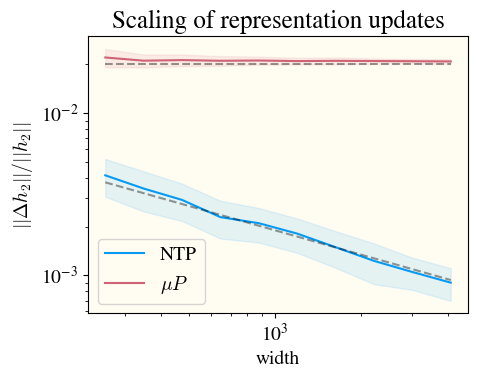

In [ ]:
plt.figure(figsize=(5, 4))

labels = ["NTP", r"$\mu P$"]
colors = ['xkcd:azure', 'xkcd:rose']
for i, label in enumerate(labels):
    update_sz = update_sizes[i].mean(axis=1)
    update_std = update_sizes[i].std(axis=1)
    plt.plot(widths, update_sz, color=colors[i], label=label)
    plt.fill_between(widths, update_sz-update_std, update_sz+update_std, color=colors[i], alpha=0.1)
plt.plot(widths, 0.06*widths**(-0.5), alpha=0.4, color='k', ls='--')
plt.plot(widths, 0.02*widths**0, alpha=0.4, color='k', ls='--')

plt.title('Scaling of representation updates')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$||\Delta h_2||/||h_2||$')
plt.xlabel('width')
plt.tight_layout()
plt.show()

### synth dataset

In [ ]:
dim = 10
N = 10_000
train_percent = 0.9
bsz = 64

X, y, H, monomials, fra_eigvals, v_true = get_synthetic_dataset(ytype="PowerLaw", d=dim, N=N, offset=1.3, alpha=1.5, cutoff_mode=1000,
                            noise_size=0.1, normalized=True, vi0 = 1, beta=1.02)

X_train, y_train = X[:int(train_percent*N)], y[:int(train_percent*N)]
X_test, y_test = X[int(train_percent*N):], y[int(train_percent*N):]

X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_train, y_train, X_test, y_test = [torch.Tensor(d).cuda() for d in (X_train, y_train, X_test, y_test)]

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=bsz, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=bsz, shuffle=False)

In [ ]:
param = 'mup-lr'

model = MLP(d_in=784, width=512, depth=2, d_out=10).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1, momentum=0.9)
inp = torch.normal(0, 1, size=(256, 784)).cuda()
print_model_measurements(model, optimizer, inp)
mupify(model, optimizer, param=param, verbose=True)

inp = torch.normal(0, 1, size=(256, 784)).cuda()
print_model_measurements(model, optimizer, inp)

== Output scale ==
0.0942

== Init weight scale ==
input_layer          0.0206
hidden_layers.0      0.0255
output_layer         0.0255

== Layerwise learning rates ==
input_layer          1.0000
hidden_layers.0      1.0000
output_layer         1.0000
== Model anatomy ==
d_in = 784
d_out = 10
widths: [512, 512]
	 using width = 512
readin layer: input_layer
readout layer: output_layer

== Output scale ==
0.0452

== Init weight scale ==
input_layer          0.0358
hidden_layers.0      0.0442
output_layer         0.0020

== Layerwise learning rates ==
input_layer          0.6531
hidden_layers.0      1.0000
output_layer         0.0020


In [ ]:
ntrials = 1000
widths = np.logspace(8, 12, num=10, base=2).astype(int)
update_sizes = np.empty((2, len(widths), ntrials))
gamma = 100

for i, param in enumerate(["ntp", "mup"]):
    for j, width in enumerate(widths):
        print('.', end='')
        model = MLP(d_in=dim, width=width, depth=2, d_out=1).to(device)
        for trial in range(ntrials):
            optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
            mupify(model, optimizer, param=param)
            rescale(model, gamma)

            data, target = next(iter(train_loader))
            optimizer.zero_grad()
            h, output = model.get_activations(data)
            h2 = h[-1]
            loss = F.mse_loss(output.squeeze(), target)
            loss.backward()
            optimizer.step()
            h_new, _ = model.get_activations(data)
            h2_new = h_new[-1]

            update_size = torch.linalg.norm(h2_new - h2) / torch.linalg.norm(h2)
            update_sizes[i, j, trial] = update_size
    print()

..........
..........


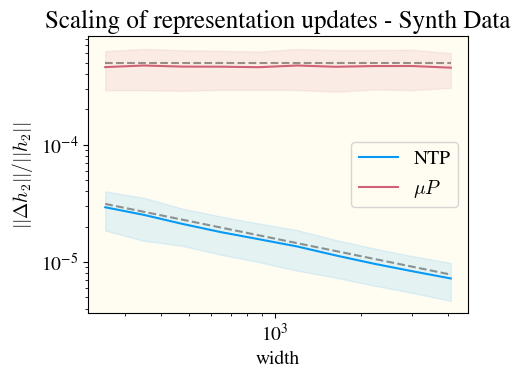

In [ ]:
plt.figure(figsize=(5, 4))

labels = ["NTP", r"$\mu P$"]
colors = ['xkcd:azure', 'xkcd:rose']
for i, label in enumerate(labels):
    update_sz = update_sizes[i].mean(axis=1)
    update_std = update_sizes[i].std(axis=1)
    plt.plot(widths, update_sz, color=colors[i], label=label)
    plt.fill_between(widths, update_sz-update_std, update_sz+update_std, color=colors[i], alpha=0.1)
plotoffset = 5e-4
plt.plot(widths, plotoffset*widths**(-0.5), alpha=0.4, color='k', ls='--')
plt.plot(widths, plotoffset*widths**0, alpha=0.4, color='k', ls='--')

plt.title('Scaling of representation updates - Synth Data')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$||\Delta h_2||/||h_2||$')
plt.xlabel('width')
plt.tight_layout()
plt.show()

## finding the optimal learning rate
note: synthetic task is finda funky with finding an optimal learning rate, but it seems like if we setup the problem with low enough dim and a relatively small lr, we can get something optimal

In [ ]:
ntrials = 5
widths = np.logspace(5, 9, num=5, base=2).astype(int)
mup_lrs = np.logspace(-5, -1, num=25, base=2)
# ntp_lrs = np.logspace(3, 8, num=30, base=2)
test_errors = np.empty((len(widths), len(mup_lrs), ntrials))

for j, width in enumerate(widths):
    for k, lr in enumerate(mup_lrs):
        print('.', end='')
        model = StandardMLP(d_in=dim, depth=2, d_out=1, width=width).to(device)
        for trial in range(ntrials):
            optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
            mupify(model, optimizer, param="mup")
            for epoch in range(1):
                for data, target in train_loader:
                    optimizer.zero_grad()
                    output = model(data).squeeze()
                    loss = F.mse_loss(output, target)
                    loss.backward()
                    optimizer.step()
            model.eval()
            test_loss = 0
            with torch.no_grad():
                for data, target in test_loader:
                    output = model(data).squeeze()
                    test_loss += F.mse_loss(output, target, reduction='sum').item()
            test_loss /= len(test_loader.dataset)
            if not test_loss < 1e5:
                test_loss = 1e5
            test_errors[j, k, trial] = test_loss
    print()

.........................
.........................
.........................
.........................
.........................


Width 32 has minlr 0.03610477177725852 at 0.03610477177725852
Width 64 has minlr 0.03610477177725852 at 0.03610477177725852
Width 128 has minlr 0.0556811698837712 at 0.0556811698837712
Width 256 has minlr 0.04171374544281358 at 0.04171374544281358
Width 512 has minlr 0.03610477177725852 at 0.03610477177725852


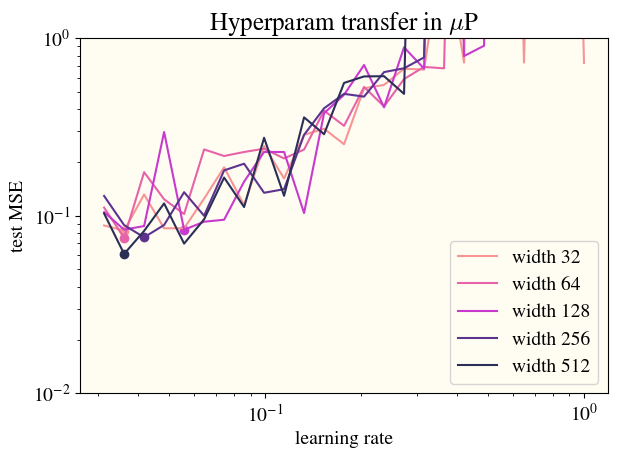

In [ ]:
colors = "#2b2f57 #5c3490 #c73acd #e763a8 #f79595".split(' ')[::-1]

plt.title(r"Hyperparam transfer in $\mu$P")
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-2, 1e-0)
plt.xlabel('learning rate')
for j, width in enumerate(widths):
    test_err = test_errors[j].mean(axis=1)
    # test_err[np.argwhere(test_err>1e1)[0, 0]:] = 1e5
    plt.plot(mup_lrs, test_err, color=colors[j], label=f'width {width}')
    min_lr = mup_lrs[np.argmin(test_err)]
    plt.scatter(min_lr, min(test_err), color=colors[j])
    print(f"Width {width} has minlr {min_lr} at {mup_lrs[np.where(test_err == min(test_err))[0][0]]}")
# plt.ylim(bottom=1e-6, top=1e-3)


plt.legend()
plt.ylabel('test MSE')

plt.tight_layout()
plt.show()

In [ ]:
optimal_lr = (mup_lrs[np.argmin(test_errors.mean(axis=2), axis=1)]).mean()
optimal_lr #0.041141846131672065

np.float64(0.041141846131672065)

# training MLPs - width 64, 1HL (early runs)
having such small width really messes with things

## fitting polynomials - first run

In [ ]:
dim = 10
N = 10_000
offset=3
alpha=2.01
train_percent = 0.9
bsz = 32
target_monomials = [Monomial({}), Monomial({0:1}), Monomial({0:2}), Monomial({9: 1}), Monomial({0: 2, 1:1}), Monomial({1:3}), Monomial({5:1, 8:1})]
lr = 1e-2#1e-1*0.041141846131672065#optimal_lr
width = 64

num_trials = 10

X, y, locs, H, monomials, fra_eigvals, data_eigvals = get_all_targets(target_monomials=target_monomials, dim=dim, N=N)
U, lambdas, Vt = torch.linalg.svd(X, full_matrices=False)

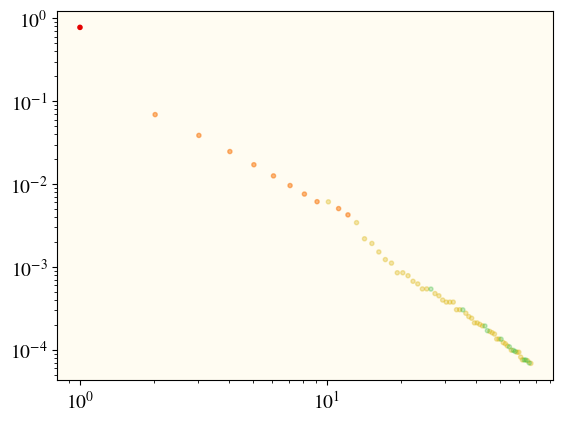

In [ ]:
colors = ['xkcd:red', 'xkcd:orange', 'xkcd:gold', 'xkcd:green', 'xkcd:blue', "xkcd:purple", "xkcd:black"]
degrees = np.array([monomial.degree() for monomial in monomials[:int(locs[-1])]])
indices = np.linspace(1, int(locs[-1])+1, int(locs[-1]))
for degree in np.unique(degrees):
    idxs = np.where(np.array(degrees) == degree)[0]
    plt.scatter(indices[idxs], fra_eigvals[idxs].cpu(), color=colors[degree%7], linestyle='', marker='.', alpha=1/(degree+1),)
plt.yscale("log")
plt.xscale('log')

In [ ]:
ntrials = 10
max_iter = int(5e3)
max_loss = 1e-3
all_losses = np.ones((len(target_monomials), ntrials, max_iter))*max_loss
breakpoints = np.empty((len(target_monomials), ntrials))
for idx, target_monomial in enumerate(target_monomials):
    print(f"Target = {target_monomial}")
    model = MLP(d_in=dim, depth=2, d_out=1, width=width).to(device)
    for trial in range(ntrials):
        model, losses, breakpoint = train_network_online(lambdas, Vt, target_monomial, dim, bsz=bsz, data_eigvals=data_eigvals, N=N, lr=lr, max_iter=max_iter, max_loss=max_loss,)
        all_losses[idx, trial] = losses
        breakpoints[idx, trial] = breakpoint
        print(f"Trial {trial} Breakpoint {breakpoint}")
# all_losses = all_losses[all_losses > 10] = max_loss

Target = 1
Trial 0
Breakpoint 834
Trial 1
Breakpoint 421
Trial 2
Breakpoint 683
Trial 3
Breakpoint 430
Trial 4
Breakpoint 691
Trial 5
Breakpoint 1426
Trial 6
Breakpoint 691
Trial 7
Breakpoint 809
Trial 8
Breakpoint 610
Trial 9
Breakpoint 422
Target = $x_{0}$
Trial 0
Breakpoint 1758
Trial 1
Breakpoint 1971
Trial 2
Breakpoint 2664
Trial 3
Breakpoint 2199
Trial 4
Breakpoint 3756
Trial 5
Breakpoint 2726
Trial 6
Breakpoint 2105
Trial 7
Breakpoint 2194
Trial 8
Breakpoint 2703
Trial 9
Breakpoint 2503
Target = $x_{0}^2$
Trial 0
Breakpoint 4999
Trial 1
Breakpoint 2872
Trial 2
Breakpoint 3694
Trial 3
Breakpoint 4079
Trial 4
Breakpoint 3330
Trial 5
Breakpoint 4640
Trial 6
Breakpoint 4999
Trial 7
Breakpoint 3435
Trial 8
Breakpoint 3264
Trial 9
Breakpoint 4407
Target = $x_{9}$
Trial 0
Breakpoint 1675
Trial 1
Breakpoint 1176
Trial 2
Breakpoint 1229
Trial 3
Breakpoint 1121
Trial 4
Breakpoint 1579
Trial 5
Breakpoint 1306
Trial 6
Breakpoint 1284
Trial 7
Breakpoint 1079
Trial 8
Breakpoint 1526
Trial 9
B

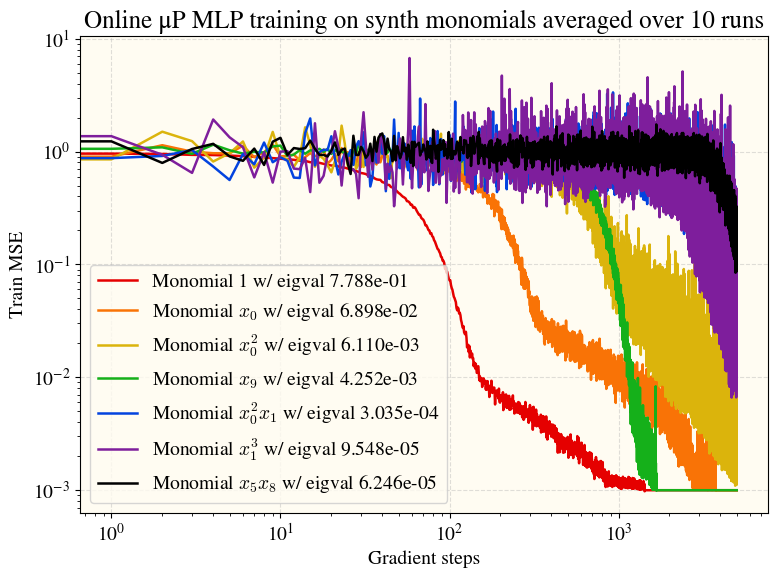

In [ ]:
plt.figure(figsize=(8,6))
for idx, target_monomial in enumerate(target_monomials):
    plt.plot(all_losses[idx].mean(axis=0), label=f"Monomial {target_monomial} w/ eigval {fra_eigvals[int(locs[idx].cpu().numpy())]:.3e}", color=colors[idx%7], lw=1.8)
plt.xscale('log')
plt.yscale('log')
plt.grid(True, ls='--', alpha=.4)
plt.xlabel("Gradient steps")
plt.ylabel("Train MSE")
plt.title("Online μP MLP training on synth monomials averaged over 10 runs")
plt.legend(); plt.tight_layout(); plt.show()

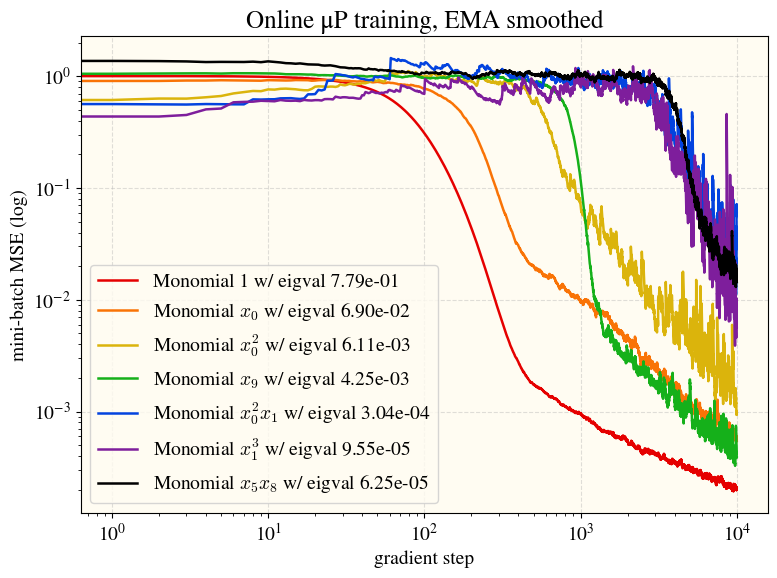

In [ ]:
plt.figure(figsize=(8,6))
for trial in range(num_trials):
    pass
for idx, target_monomial in enumerate(target_monomials):
    model, losses, breakpoint = train_network_online_minibatch_new(target_monomial, colors[idx%7], eval=fra_eigvals[int(locs.cpu().numpy()[idx])], steps=int(1e4))
    plt.plot(losses, label=f"Monomial {target_monomial} w/ eigval {fra_eigvals[int(locs[idx].cpu().numpy())]}", color=colors[idx%7], lw=1.8)
plt.xscale('log')
plt.yscale('log')
plt.grid(True, ls='--', alpha=.4)
plt.xlabel("Gradient steps")
plt.ylabel("Train MSE")
plt.title("Online μP MLP training on synth monomials")
plt.legend(); plt.tight_layout(); plt.show()

## first run - lower learning rate
maybe kinks in MSE plots are due to EOS-like effects?
no - the kinks are purely a biproduct of the low width

In [ ]:
dim = 10
N = 10_000*10
offset=3
alpha=2.01
train_percent = 0.9
bsz = 512
target_monomials = [Monomial({}), Monomial({0:1}), Monomial({0:2}), Monomial({9: 1}), Monomial({0: 2, 1:1}), Monomial({1:3})]
lr = 1e-2/10
width = 64

num_trials = 5
max_iter = int(5e4)
max_loss = 1e-3

X, y, locs, H, monomials, fra_eigvals, data_eigvals = get_all_targets(target_monomials=target_monomials, dim=dim, N=N)
U, lambdas, Vt = torch.linalg.svd(X, full_matrices=False)

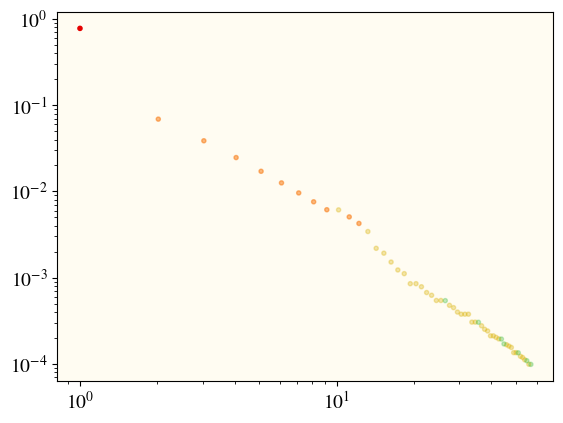

In [ ]:
colors = ['xkcd:red', 'xkcd:orange', 'xkcd:gold', 'xkcd:green', 'xkcd:blue', "xkcd:purple", "xkcd:black"]
degrees = np.array([monomial.degree() for monomial in monomials[:int(locs[-1])]])
indices = np.linspace(1, int(locs[-1])+1, int(locs[-1]))
for degree in np.unique(degrees):
    idxs = np.where(np.array(degrees) == degree)[0]
    plt.scatter(indices[idxs], fra_eigvals[idxs].cpu(), color=colors[degree%7], linestyle='', marker='.', alpha=1/(degree+1),)
plt.yscale("log")
plt.xscale('log')

In [ ]:
all_losses = np.ones((len(target_monomials), num_trials, max_iter))*max_loss
breakpoints = np.empty((len(target_monomials), num_trials))
for idx, target_monomial in enumerate(target_monomials):
    print(f"Target = {target_monomial}")
    model = MLP(d_in=dim, depth=2, d_out=1, width=width).to(device)
    for trial in range(num_trials):
        model, losses, breakpoint = train_network_online(lambdas, Vt, target_monomial, dim, bsz=bsz, data_eigvals=data_eigvals, N=N, lr=lr, max_iter=max_iter, max_loss=max_loss,)
        all_losses[idx, trial] = losses
        breakpoints[idx, trial] = breakpoint
        print(f"Trial {trial} Breakpoint {breakpoint}")

Target = 1
Trial 0 Breakpoint 15299
Trial 1 Breakpoint 9176
Trial 2 Breakpoint 13782
Trial 3 Breakpoint 15292
Trial 4 Breakpoint 9707
Target = $x_{0}$
Trial 0 Breakpoint 46937
Trial 1 Breakpoint 32193
Trial 2 Breakpoint 37918
Trial 3 Breakpoint 41526
Trial 4 Breakpoint 45725
Target = $x_{0}^2$
Trial 0 Breakpoint 49999
Trial 1 Breakpoint 49999
Trial 2 Breakpoint 49999
Trial 3 Breakpoint 49999
Trial 4 Breakpoint 49999
Target = $x_{9}$
Trial 0 Breakpoint 25822
Trial 1 Breakpoint 32691
Trial 2 Breakpoint 35839
Trial 3 Breakpoint 26734
Trial 4 Breakpoint 24443
Target = $x_{0}^2x_{1}$
Trial 0 Breakpoint 49999
Trial 1 Breakpoint 49999
Trial 2 Breakpoint 49999
Trial 3 Breakpoint 49999
Trial 4 Breakpoint 49999
Target = $x_{1}^3$
Trial 0 Breakpoint 49999
Trial 1 Breakpoint 49999
Trial 2 Breakpoint 49999
Trial 3 Breakpoint 49999
Trial 4 Breakpoint 49999


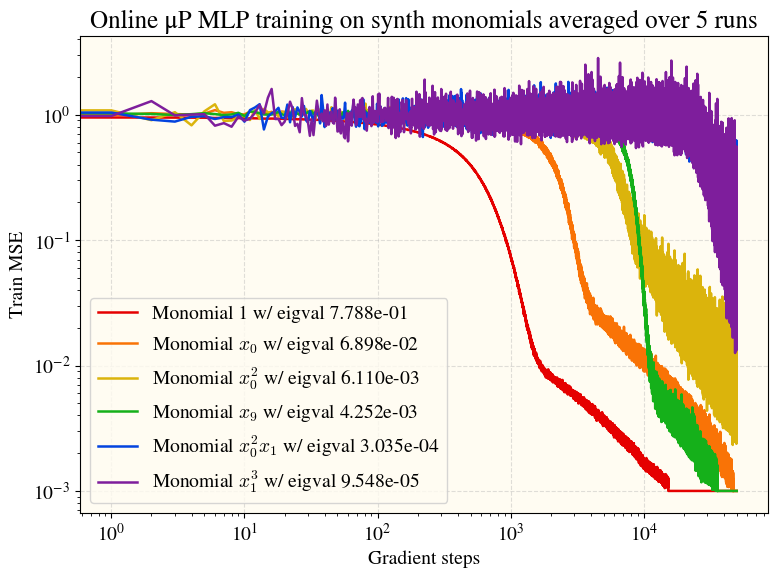

In [ ]:
plt.figure(figsize=(8,6))
for idx, target_monomial in enumerate(target_monomials):
    plt.plot(all_losses[idx].mean(axis=0), label=f"Monomial {target_monomial} w/ eigval {fra_eigvals[int(locs[idx].cpu().numpy())]:.3e}", color=colors[idx%7], lw=1.8)
plt.xscale('log')
plt.yscale('log')
plt.grid(True, ls='--', alpha=.4)
plt.xlabel("Gradient steps")
plt.ylabel("Train MSE")
plt.title(f"Online μP MLP training on synth monomials averaged over {num_trials} runs")
plt.legend(); plt.tight_layout(); plt.show()

## second run - tanh
maybe kinks in MSE plots are due to relu nonlin?

In [ ]:
class TaNLP(nn.Module):
    def __init__(self, d_in=1, width=50, depth=2, d_out=1, bias=True):
        super().__init__()
        self.d_in, self.width, self.depth, self.d_out = d_in, width, depth, d_out

        self.input_layer = nn.Linear(d_in, width, bias)
        self.hidden_layers = nn.ModuleList([nn.Linear(width, width, bias) for _ in range(depth - 1)])
        self.output_layer = nn.Linear(width, d_out, bias)
        self.tanh = nn.Tanh()

    def forward(self, x):
        h = self.tanh(self.input_layer(x))
        for layer in self.hidden_layers:
            h = self.tanh(layer(h))
        out = self.output_layer(h)
        return out

    def get_activations(self, x):
        h_acts = []
        h = self.tanh(self.input_layer(x))
        h_acts.append(h)
        for layer in self.hidden_layers:
            h = self.tanh(layer(h))
            h_acts.append(h)
        h_out = self.output_layer(h)
        return h_acts, h_out

In [ ]:
dim = 10
N = 10_000
offset=3
alpha=2.01
train_percent = 0.9
bsz = 512
target_monomials = [Monomial({}), Monomial({0:1}), Monomial({0:2}), Monomial({9: 1}), Monomial({0: 2, 1:1}), Monomial({1:3})]
lr = 1e-2
width = 64

num_trials = 5
max_iter = int(5e4)
max_loss = 1e-3

X, y, locs, H, monomials, fra_eigvals, data_eigvals = get_all_targets(target_monomials=target_monomials, dim=dim, N=N)
U, lambdas, Vt = torch.linalg.svd(X, full_matrices=False)

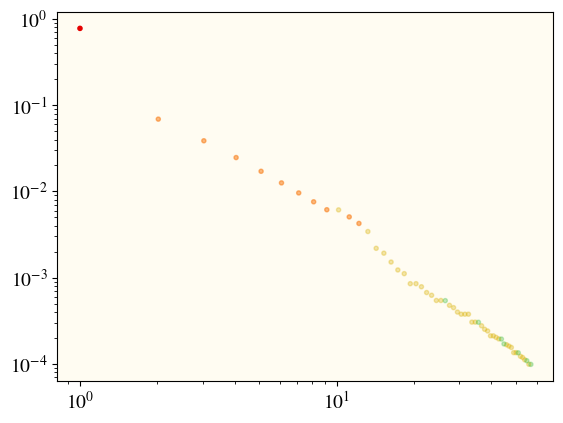

In [ ]:
colors = ['xkcd:red', 'xkcd:orange', 'xkcd:gold', 'xkcd:green', 'xkcd:blue', "xkcd:purple", "xkcd:black"]
degrees = np.array([monomial.degree() for monomial in monomials[:int(locs[-1])]])
indices = np.linspace(1, int(locs[-1])+1, int(locs[-1]))
for degree in np.unique(degrees):
    idxs = np.where(np.array(degrees) == degree)[0]
    plt.scatter(indices[idxs], fra_eigvals[idxs].cpu(), color=colors[degree%7], linestyle='', marker='.', alpha=1/(degree+1),)
plt.yscale("log")
plt.xscale('log')

In [ ]:
all_losses = np.ones((len(target_monomials), num_trials, max_iter))*max_loss
breakpoints = np.empty((len(target_monomials), num_trials))
for idx, target_monomial in enumerate(target_monomials):
    print(f"Target = {target_monomial}")
    model = TaNLP(d_in=dim, depth=2, d_out=1, width=width).to(device)
    for trial in range(num_trials):
        model, losses, breakpoint = train_network_online(lambdas, Vt, target_monomial, dim, bsz=bsz, data_eigvals=data_eigvals, N=N, lr=lr, max_iter=max_iter, max_loss=max_loss,)
        all_losses[idx, trial] = losses
        breakpoints[idx, trial] = breakpoint
        print(f"Trial {trial} Breakpoint {breakpoint}")

Target = 1
Trial 0 Breakpoint 1235
Trial 1 Breakpoint 1347
Trial 2 Breakpoint 1396
Trial 3 Breakpoint 1368
Trial 4 Breakpoint 1163
Target = $x_{0}$
Trial 0 Breakpoint 5915
Trial 1 Breakpoint 4356
Trial 2 Breakpoint 3921
Trial 3 Breakpoint 3441
Trial 4 Breakpoint 3697
Target = $x_{0}^2$
Trial 0 Breakpoint 7564
Trial 1 Breakpoint 15459
Trial 2 Breakpoint 7582
Trial 3 Breakpoint 11703
Trial 4 Breakpoint 7696
Target = $x_{9}$
Trial 0 Breakpoint 2415
Trial 1 Breakpoint 2623
Trial 2 Breakpoint 2366
Trial 3 Breakpoint 3356
Trial 4 Breakpoint 3474
Target = $x_{0}^2x_{1}$
Trial 0 Breakpoint 49999
Trial 1 Breakpoint 29755
Trial 2 Breakpoint 49999
Trial 3 Breakpoint 49999
Trial 4 Breakpoint 47072
Target = $x_{1}^3$
Trial 0 Breakpoint 20776
Trial 1 Breakpoint 14926
Trial 2 Breakpoint 13506
Trial 3 Breakpoint 26736
Trial 4 Breakpoint 19478


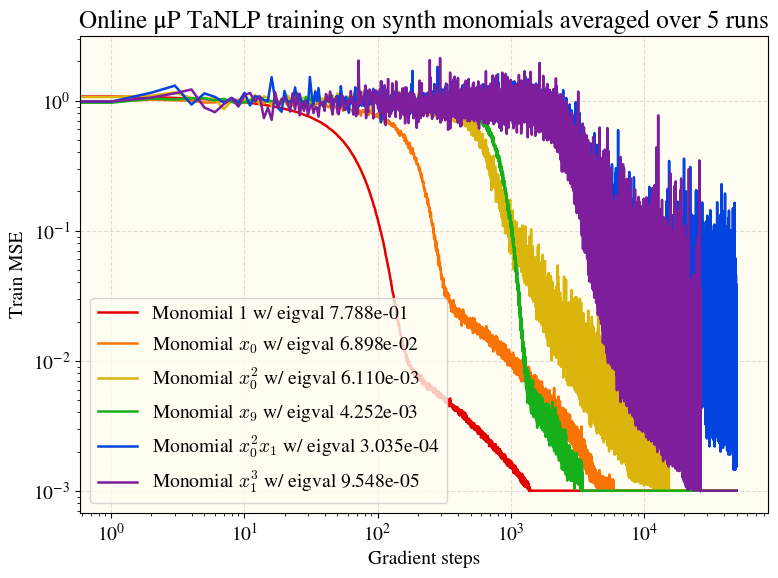

In [ ]:
plt.figure(figsize=(8,6))
for idx, target_monomial in enumerate(target_monomials):
    plt.plot(all_losses[idx].mean(axis=0), label=f"Monomial {target_monomial} w/ eigval {fra_eigvals[int(locs[idx].cpu().numpy())]:.3e}", color=colors[idx%7], lw=1.8)
plt.xscale('log')
plt.yscale('log')
plt.grid(True, ls='--', alpha=.4)
plt.xlabel("Gradient steps")
plt.ylabel("Train MSE")
plt.title(f"Online μP TaNLP training on synth monomials averaged over {num_trials} runs")
plt.legend(); plt.tight_layout(); plt.show()

## third run - many eigenvalues

In [ ]:
dim = 10
N = 10_000
offset=3
alpha=2.01
train_percent = 0.9
bsz = 512
target_monomials = [Monomial({}), Monomial({0:1}), Monomial({0:2}), Monomial({9: 1}), Monomial({0: 2, 1:1}), Monomial({1:3})]
lr = 1e-2
width = 64

num_trials = 3
max_iter = int(5e4)
loss_checkpoints = [5e-1, 2e-1]

X, y, locs, H, monomials, fra_eigvals, data_eigvals = get_all_targets(target_monomials=target_monomials, dim=dim, N=N)
target_monomials = monomials[:100]
X, y, locs, H, monomials, fra_eigvals, data_eigvals = get_all_targets(target_monomials=target_monomials, dim=dim, N=N)
U, lambdas, Vt = torch.linalg.svd(X, full_matrices=False)

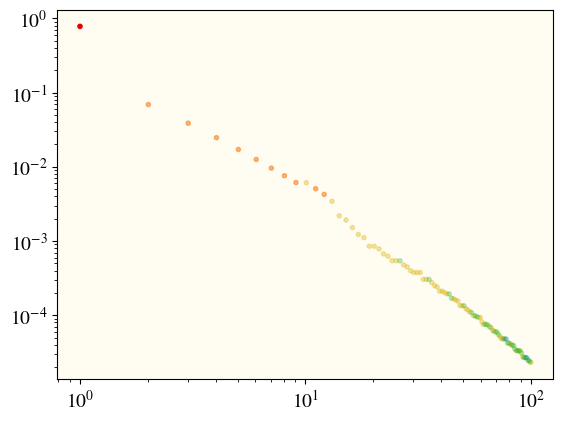

In [ ]:
colors = ['xkcd:red', 'xkcd:orange', 'xkcd:gold', 'xkcd:green', 'xkcd:blue', "xkcd:purple", "xkcd:black"]
degrees = np.array([monomial.degree() for monomial in monomials[:int(locs[-1])]])
indices = np.linspace(1, int(locs[-1])+1, int(locs[-1]))
for degree in np.unique(degrees):
    idxs = np.where(np.array(degrees) == degree)[0]
    plt.scatter(indices[idxs], fra_eigvals[idxs].cpu(), color=colors[degree%7], linestyle='', marker='.', alpha=1/(degree+1),)
plt.yscale("log")
plt.xscale('log')

In [ ]:
all_losses = np.ones((len(target_monomials), num_trials, max_iter))*max(loss_checkpoints)
breakpoints = np.empty((len(target_monomials), len(loss_checkpoints), num_trials))
for idx, target_monomial in enumerate(target_monomials):
    print(f"Target = {target_monomial}")
    model = MLP(d_in=dim, depth=2, d_out=1, width=width).to(device)
    for trial in range(num_trials):
        model, losses, breakpoint = train_network_online(lambdas, Vt, target_monomial, dim, bsz=bsz, data_eigvals=data_eigvals, N=N, lr=lr, max_iter=max_iter, loss_checkpoints=loss_checkpoints,)
        all_losses[idx, trial] = losses
        breakpoints[idx, :, trial] = breakpoint
        print(f"Trial {trial} Breakpoint {breakpoint}")

Target = $x_{0}x_{2}x_{5}$
Trial 0 Breakpoint [ 970. 6594.]
Trial 1 Breakpoint [5694. 7333.]
Trial 2 Breakpoint [1058. 6127.]
Target = $x_{0}x_{1}x_{7}$
Trial 0 Breakpoint [1793. 7913.]
Trial 1 Breakpoint [1144. 7241.]
Trial 2 Breakpoint [2015. 7312.]
Target = $x_{1}x_{2}x_{3}$
Trial 0 Breakpoint [3271. 6807.]
Trial 1 Breakpoint [4784. 6263.]
Trial 2 Breakpoint [1982. 5799.]
Target = $x_{0}^3x_{1}$
Trial 0 Breakpoint [1.000e+00 3.551e+03]
Trial 1 Breakpoint [   5. 3649.]
Trial 2 Breakpoint [3.000e+00 3.091e+03]
Target = $x_{2}^3$
Trial 0 Breakpoint [  82. 3792.]
Trial 1 Breakpoint [  74. 4460.]
Trial 2 Breakpoint [  16. 3089.]
Target = $x_{0}x_{3}x_{4}$
Trial 0 Breakpoint [  43. 7674.]
Trial 1 Breakpoint [ 180. 5706.]
Trial 2 Breakpoint [2064. 6478.]
Target = $x_{1}^2x_{5}$
Trial 0 Breakpoint [ 143. 5242.]
Trial 1 Breakpoint [ 268. 4754.]
Trial 2 Breakpoint [ 150. 5330.]
Target = $x_{9}^2$
Trial 0 Breakpoint [3497. 4509.]
Trial 1 Breakpoint [2640. 4000.]
Trial 2 Breakpoint [3006. 4152.

In [ ]:
plt.figure(figsize=(8,6))
for idx, target_monomial in enumerate(target_monomials):
    plt.plot(all_losses[idx].mean(axis=0), label=f"Monomial {target_monomial} w/ eigval {fra_eigvals[int(locs[idx].cpu().numpy())]:.3e}", color=colors[idx%7], lw=1.8)
plt.xscale('log')
plt.yscale('log')
plt.grid(True, ls='--', alpha=.4)
plt.xlabel("Gradient steps")
plt.ylabel("Train MSE")
plt.title(f"Online μP MLP training on synth monomials averaged over {num_trials} runs")
plt.legend(); plt.tight_layout(); plt.show()

NameError: name 'plt' is not defined

In [ ]:
breakindex = -1
plot_time_to_learn_eigenvalue(fra_eigvals[locs.long()].cpu(), breakpoints.mean(axis=-1)[:, breakindex], target_monomials, scale='log', breakpoint=f"(error < {loss_checkpoints[breakindex]:.1e})")
# plt.title("Time to learn vs FRA eigval")
plt.show()

## annoying af colab exiting runtime in the middle of my run

In [ ]:
text = '''Target = 1
Trial 0 Breakpoint [51. 78.]
Trial 1 Breakpoint [51. 82.]
Trial 2 Breakpoint [27. 53.]
Target = $x_{0}$
Trial 0 Breakpoint [169. 242.]
Trial 1 Breakpoint [135. 206.]
Trial 2 Breakpoint [171. 244.]
Target = $x_{1}$
Trial 0 Breakpoint [251. 335.]
Trial 1 Breakpoint [204. 294.]
Trial 2 Breakpoint [199. 293.]
Target = $x_{2}$
Trial 0 Breakpoint [206. 285.]
Trial 1 Breakpoint [231. 314.]
Trial 2 Breakpoint [271. 364.]
Target = $x_{3}$
Trial 0 Breakpoint [237. 328.]
Trial 1 Breakpoint [352. 446.]
Trial 2 Breakpoint [307. 412.]
Target = $x_{4}$
Trial 0 Breakpoint [389. 486.]
Trial 1 Breakpoint [295. 408.]
Trial 2 Breakpoint [393. 491.]
Target = $x_{5}$
Trial 0 Breakpoint [383. 488.]
Trial 1 Breakpoint [318. 443.]
Trial 2 Breakpoint [444. 545.]
Target = $x_{6}$
Trial 0 Breakpoint [566. 670.]
Trial 1 Breakpoint [425. 560.]
Trial 2 Breakpoint [508. 631.]
Target = $x_{7}$
Trial 0 Breakpoint [560. 671.]
Trial 1 Breakpoint [603. 724.]
Trial 2 Breakpoint [560. 656.]
Target = $x_{0}^2$
Trial 0 Breakpoint [202. 753.]
Trial 1 Breakpoint [450. 657.]
Trial 2 Breakpoint [556. 811.]
Target = $x_{8}$
Trial 0 Breakpoint [488. 626.]
Trial 1 Breakpoint [569. 693.]
Trial 2 Breakpoint [630. 760.]
Target = $x_{9}$
Trial 0 Breakpoint [812. 952.]
Trial 1 Breakpoint [853. 990.]
Trial 2 Breakpoint [649. 784.]
Target = $x_{0}x_{1}$
Trial 0 Breakpoint [761. 997.]
Trial 1 Breakpoint [ 821. 1049.]
Trial 2 Breakpoint [ 713. 1024.]
Target = $x_{0}x_{2}$
Trial 0 Breakpoint [ 748. 1060.]
Trial 1 Breakpoint [ 847. 1143.]
Trial 2 Breakpoint [ 806. 1151.]
Target = $x_{1}^2$
Trial 0 Breakpoint [468. 739.]
Trial 1 Breakpoint [646. 901.]
Trial 2 Breakpoint [ 820. 1108.]
Target = $x_{0}x_{3}$
Trial 0 Breakpoint [1434. 1761.]
Trial 1 Breakpoint [ 944. 1345.]
Trial 2 Breakpoint [1144. 1512.]
Target = $x_{1}x_{2}$
Trial 0 Breakpoint [1040. 1342.]
Trial 1 Breakpoint [1129. 1473.]
Trial 2 Breakpoint [1033. 1317.]
Target = $x_{0}x_{4}$
Trial 0 Breakpoint [ 985. 1362.]
Trial 1 Breakpoint [1552. 1893.]
Trial 2 Breakpoint [1290. 1758.]
Target = $x_{0}x_{5}$
Trial 0 Breakpoint [1199. 1552.]
Trial 1 Breakpoint [1128. 1564.]
Trial 2 Breakpoint [1358. 1783.]
Target = $x_{1}x_{3}$
Trial 0 Breakpoint [1212. 1649.]
Trial 1 Breakpoint [1130. 1584.]
Trial 2 Breakpoint [1173. 1532.]
Target = $x_{2}^2$
Trial 0 Breakpoint [ 948. 1307.]
Trial 1 Breakpoint [ 880. 1249.]
Trial 2 Breakpoint [ 963. 1234.]
Target = $x_{0}x_{6}$
Trial 0 Breakpoint [1383. 2015.]
Trial 1 Breakpoint [1680. 2186.]
Trial 2 Breakpoint [1647. 2045.]
Target = $x_{1}x_{4}$
Trial 0 Breakpoint [1509. 1911.]
Trial 1 Breakpoint [1873. 2210.]
Trial 2 Breakpoint [1564. 1908.]
Target = $x_{0}x_{7}$
Trial 0 Breakpoint [1466. 2063.]
Trial 1 Breakpoint [1836. 2171.]
Trial 2 Breakpoint [1728. 2148.]
Target = $x_{2}x_{3}$
Trial 0 Breakpoint [1259. 1645.]
Trial 1 Breakpoint [1254. 1688.]
Trial 2 Breakpoint [1675. 2105.]
Target = $x_{0}^3$
Trial 0 Breakpoint [  30. 1607.]
Trial 1 Breakpoint [  73. 1991.]
Trial 2 Breakpoint [   7. 2117.]
Target = $x_{1}x_{5}$
Trial 0 Breakpoint [1325. 1905.]
Trial 1 Breakpoint [1555. 1971.]
Trial 2 Breakpoint [1596. 2039.]
Target = $x_{0}x_{8}$
Trial 0 Breakpoint [1836. 2292.]
Trial 1 Breakpoint [1748. 2307.]
Trial 2 Breakpoint [1763. 2182.]
Target = $x_{2}x_{4}$
Trial 0 Breakpoint [1824. 2222.]
Trial 1 Breakpoint [1757. 2130.]
Trial 2 Breakpoint [1911. 2283.]
Target = $x_{0}x_{9}$
Trial 0 Breakpoint [2230. 2820.]
Trial 1 Breakpoint [2003. 2480.]
Trial 2 Breakpoint [1744. 2333.]
Target = $x_{3}^2$
Trial 0 Breakpoint [1490. 1772.]
Trial 1 Breakpoint [1211. 1588.]
Trial 2 Breakpoint [1190. 1476.]
Target = $x_{1}x_{6}$
Trial 0 Breakpoint [1778. 2110.]
Trial 1 Breakpoint [1437. 1897.]
Trial 2 Breakpoint [2097. 2493.]
Target = $x_{2}x_{5}$
Trial 0 Breakpoint [2108. 2478.]
Trial 1 Breakpoint [2133. 2624.]
Trial 2 Breakpoint [1633. 2130.]
Target = $x_{1}x_{7}$
Trial 0 Breakpoint [2267. 2820.]
Trial 1 Breakpoint [2308. 2955.]
Trial 2 Breakpoint [2150. 2680.]
Target = $x_{0}^2x_{1}$
Trial 0 Breakpoint [ 153. 2926.]
Trial 1 Breakpoint [ 559. 2664.]
Trial 2 Breakpoint [ 527. 2820.]
Target = $x_{3}x_{4}$
Trial 0 Breakpoint [2030. 2450.]
Trial 1 Breakpoint [2099. 2664.]
Trial 2 Breakpoint [1880. 2369.]
Target = $x_{1}x_{8}$
Trial 0 Breakpoint [1935. 2505.]
Trial 1 Breakpoint [2141. 2812.]
Trial 2 Breakpoint [2187. 2759.]
Target = $x_{2}x_{6}$
Trial 0 Breakpoint [2050. 2563.]
Trial 1 Breakpoint [3304. 3677.]
Trial 2 Breakpoint [1928. 2487.]
Target = $x_{3}x_{5}$
Trial 0 Breakpoint [2094. 2627.]
Trial 1 Breakpoint [2758. 3304.]
Trial 2 Breakpoint [2025. 2488.]
Target = $x_{1}x_{9}$
Trial 0 Breakpoint [2513. 3120.]
Trial 1 Breakpoint [2324. 2831.]
Trial 2 Breakpoint [2403. 3098.]
Target = $x_{4}^2$
Trial 0 Breakpoint [1271. 1564.]
Trial 1 Breakpoint [1878. 2170.]
Trial 2 Breakpoint [1762. 2114.]
Target = $x_{2}x_{7}$
Trial 0 Breakpoint [2089. 2607.]
Trial 1 Breakpoint [2365. 2898.]
Trial 2 Breakpoint [2707. 3207.]
Target = $x_{0}^2x_{2}$
Trial 0 Breakpoint [  88. 2724.]
Trial 1 Breakpoint [  20. 3513.]
Trial 2 Breakpoint [ 120. 3551.]
Target = $x_{0}x_{1}^2$
Trial 0 Breakpoint [ 353. 3186.]
Trial 1 Breakpoint [ 149. 2924.]
Trial 2 Breakpoint [ 208. 3327.]
Target = $x_{3}x_{6}$
Trial 0 Breakpoint [3273. 3937.]
Trial 1 Breakpoint [2348. 3058.]
Trial 2 Breakpoint [2251. 2832.]
Target = $x_{2}x_{8}$
Trial 0 Breakpoint [2976. 3409.]
Trial 1 Breakpoint [2666. 3188.]
Trial 2 Breakpoint [2759. 3227.]
Target = $x_{4}x_{5}$
Trial 0 Breakpoint [2406. 2968.]
Trial 1 Breakpoint [2716. 3213.]
Trial 2 Breakpoint [2093. 2708.]
Target = $x_{2}x_{9}$
Trial 0 Breakpoint [2370. 3059.]
Trial 1 Breakpoint [2526. 3036.]
Trial 2 Breakpoint [2415. 2990.]
Target = $x_{3}x_{7}$
Trial 0 Breakpoint [2864. 3494.]
Trial 1 Breakpoint [2876. 3331.]
Trial 2 Breakpoint [2983. 3652.]
Target = $x_{0}^2x_{3}$
Trial 0 Breakpoint [  94. 3519.]
Trial 1 Breakpoint [ 545. 3700.]
Trial 2 Breakpoint [ 906. 3235.]
Target = $x_{4}x_{6}$
Trial 0 Breakpoint [2200. 2676.]
Trial 1 Breakpoint [2590. 3080.]
Trial 2 Breakpoint [2939. 3749.]
Target = $x_{5}^2$
Trial 0 Breakpoint [1958. 2323.]
Trial 1 Breakpoint [1652. 2126.]
Trial 2 Breakpoint [1823. 2256.]
Target = $x_{3}x_{8}$
Trial 0 Breakpoint [2956. 3503.]
Trial 1 Breakpoint [2784. 3375.]
Trial 2 Breakpoint [2920. 3604.]
Target = $x_{0}x_{1}x_{2}$
Trial 0 Breakpoint [ 461. 4920.]
Trial 1 Breakpoint [ 100. 4570.]
Trial 2 Breakpoint [ 292. 4515.]
Target = $x_{4}x_{7}$
Trial 0 Breakpoint [2974. 3545.]
Trial 1 Breakpoint [2709. 3299.]
Trial 2 Breakpoint [3047. 3596.]
Target = $x_{0}^2x_{4}$
Trial 0 Breakpoint [  43. 3668.]
Trial 1 Breakpoint [ 744. 4162.]
Trial 2 Breakpoint [1147. 3546.]
Target = $x_{1}^3$
Trial 0 Breakpoint [  41. 2338.]
Trial 1 Breakpoint [  65. 2362.]
Trial 2 Breakpoint [   5. 2296.]
Target = $x_{3}x_{9}$
Trial 0 Breakpoint [2640. 3405.]
Trial 1 Breakpoint [2934. 3545.]
Trial 2 Breakpoint [2558. 3051.]
Target = $x_{5}x_{6}$
Trial 0 Breakpoint [3590. 4284.]
Trial 1 Breakpoint [3292. 3681.]
Trial 2 Breakpoint [2826. 3481.]
Target = $x_{4}x_{8}$
Trial 0 Breakpoint [2557. 3172.]
Trial 1 Breakpoint [2948. 3388.]
Trial 2 Breakpoint [3144. 3573.]
Target = $x_{5}x_{7}$
Trial 0 Breakpoint [2433. 3071.]
Trial 1 Breakpoint [2357. 2979.]
Trial 2 Breakpoint [3122. 3734.]
Target = $x_{0}^2x_{5}$
Trial 0 Breakpoint [ 139. 4955.]
Trial 1 Breakpoint [  44. 4617.]
Trial 2 Breakpoint [ 238. 4334.]
Target = $x_{0}x_{1}x_{3}$
Trial 0 Breakpoint [2271. 5279.]
Trial 1 Breakpoint [1588. 4987.]
Trial 2 Breakpoint [3121. 5014.]
Target = $x_{6}^2$
Trial 0 Breakpoint [2140. 2822.]
Trial 1 Breakpoint [1434. 2182.]
Trial 2 Breakpoint [2152. 2678.]
Target = $x_{0}x_{2}^2$
Trial 0 Breakpoint [  34. 3835.]
Trial 1 Breakpoint [ 419. 3786.]
Trial 2 Breakpoint [2053. 4009.]
Target = $x_{4}x_{9}$
Trial 0 Breakpoint [3208. 3775.]
Trial 1 Breakpoint [3359. 4050.]
Trial 2 Breakpoint [3443. 3899.]
Target = $x_{5}x_{8}$
Trial 0 Breakpoint [3181. 4040.]
Trial 1 Breakpoint [3288. 3855.]
Trial 2 Breakpoint [3290. 3906.]
Target = $x_{1}^2x_{2}$
Trial 0 Breakpoint [ 850. 4491.]
Trial 1 Breakpoint [ 297. 4770.]
Trial 2 Breakpoint [ 242. 4379.]
Target = $x_{6}x_{7}$
Trial 0 Breakpoint [3484. 4292.]
Trial 1 Breakpoint [3845. 4511.]
Trial 2 Breakpoint [4138. 4708.]
Target = $x_{0}^2x_{6}$
Trial 0 Breakpoint [ 366. 5168.]
Trial 1 Breakpoint [3.000e+00 5.107e+03]
Trial 2 Breakpoint [  96. 4605.]
Target = $x_{0}x_{1}x_{4}$
Trial 0 Breakpoint [ 501. 5752.]
Trial 1 Breakpoint [4111. 5780.]
Trial 2 Breakpoint [2322. 4928.]
Target = $x_{5}x_{9}$
Trial 0 Breakpoint [4338. 5057.]
Trial 1 Breakpoint [3786. 4409.]
Trial 2 Breakpoint [3635. 4180.]
Target = $x_{6}x_{8}$
Trial 0 Breakpoint [4073. 4605.]
Trial 1 Breakpoint [3964. 4522.]
Trial 2 Breakpoint [4382. 5043.]
Target = $x_{7}^2$
Trial 0 Breakpoint [3455. 3977.]
Trial 1 Breakpoint [2847. 3322.]
Trial 2 Breakpoint [2564. 3087.]
Target = $x_{0}^2x_{7}$
Trial 0 Breakpoint [ 157. 5584.]
Trial 1 Breakpoint [  30. 5026.]
Trial 2 Breakpoint [ 207. 4470.]
Target = $x_{0}x_{2}x_{3}$
Trial 0 Breakpoint [2765. 5769.]
Trial 1 Breakpoint [2705. 5600.]
Trial 2 Breakpoint [2629. 5459.]
Target = $x_{0}^4$
Trial 0 Breakpoint [   0. 2136.]
Trial 1 Breakpoint [2.000e+00 2.182e+03]
Trial 2 Breakpoint [   0. 2000.]
Target = $x_{0}x_{1}x_{5}$
Trial 0 Breakpoint [ 493. 7095.]
Trial 1 Breakpoint [ 816. 6026.]
Trial 2 Breakpoint [1279. 6143.]
Target = $x_{1}^2x_{3}$
Trial 0 Breakpoint [  90. 4175.]
Trial 1 Breakpoint [ 242. 4642.]
Trial 2 Breakpoint [ 926. 4446.]
Target = $x_{6}x_{9}$
Trial 0 Breakpoint [5561. 6235.]
Trial 1 Breakpoint [4518. 5039.]
Trial 2 Breakpoint [3466. 4240.]
Target = $x_{7}x_{8}$
Trial 0 Breakpoint [3962. 4664.]
Trial 1 Breakpoint [4082. 4687.]
Trial 2 Breakpoint [4923. 6132.]
Target = $x_{0}^2x_{8}$
Trial 0 Breakpoint [ 112. 5740.]
Trial 1 Breakpoint [ 668. 5893.]
Trial 2 Breakpoint [ 162. 5276.]
Target = $x_{1}x_{2}^2$
Trial 0 Breakpoint [1211. 4673.]
Trial 1 Breakpoint [ 173. 4096.]
Trial 2 Breakpoint [ 320. 4407.]
Target = $x_{0}x_{2}x_{4}$
Trial 0 Breakpoint [2709. 6212.]
Trial 1 Breakpoint [4256. 6145.]
Trial 2 Breakpoint [2273. 7096.]
Target = $x_{7}x_{9}$
Trial 0 Breakpoint [4081. 4898.]
Trial 1 Breakpoint [4478. 5553.]
Trial 2 Breakpoint [3781. 4500.]
Target = $x_{0}^2x_{9}$
Trial 0 Breakpoint [  73. 5509.]
Trial 1 Breakpoint [ 146. 6335.]
Trial 2 Breakpoint [ 214. 5499.]
Target = $x_{0}x_{3}^2$
Trial 0 Breakpoint [ 198. 4742.]
Trial 1 Breakpoint [ 916. 4952.]
Trial 2 Breakpoint [ 208. 4827.]
Target = $x_{0}x_{1}x_{6}$
Trial 0 Breakpoint [1015. 6992.]
Trial 1 Breakpoint [   7. 6305.]
Trial 2 Breakpoint [ 267. 7055.]
Target = $x_{8}^2$
Trial 0 Breakpoint [3117. 3835.]
Trial 1 Breakpoint [4037. 5053.]
Trial 2 Breakpoint [4026. 4597.]
Target = $x_{1}^2x_{4}$
Trial 0 Breakpoint [ 295. 4850.]
Trial 1 Breakpoint [1690. 6416.]
Trial 2 Breakpoint [ 663. 5736.]
Target = $x_{8}x_{9}$
Trial 0 Breakpoint [4801. 5725.]
Trial 1 Breakpoint [4185. 4992.]
Trial 2 Breakpoint [4658. 5478.]
Target = $x_{0}x_{2}x_{5}$
Trial 0 Breakpoint [ 970. 6594.]
Trial 1 Breakpoint [5694. 7333.]
Trial 2 Breakpoint [1058. 6127.]
Target = $x_{0}x_{1}x_{7}$
Trial 0 Breakpoint [1793. 7913.]
Trial 1 Breakpoint [1144. 7241.]
Trial 2 Breakpoint [2015. 7312.]
Target = $x_{1}x_{2}x_{3}$
Trial 0 Breakpoint [3271. 6807.]
Trial 1 Breakpoint [4784. 6263.]
Trial 2 Breakpoint [1982. 5799.]
Target = $x_{0}^3x_{1}$
Trial 0 Breakpoint [1.000e+00 3.551e+03]
Trial 1 Breakpoint [   5. 3649.]
Trial 2 Breakpoint [3.000e+00 3.091e+03]
Target = $x_{2}^3$
Trial 0 Breakpoint [  82. 3792.]
Trial 1 Breakpoint [  74. 4460.]
Trial 2 Breakpoint [  16. 3089.]
Target = $x_{0}x_{3}x_{4}$
Trial 0 Breakpoint [  43. 7674.]
Trial 1 Breakpoint [ 180. 5706.]
Trial 2 Breakpoint [2064. 6478.]
Target = $x_{1}^2x_{5}$
Trial 0 Breakpoint [ 143. 5242.]
Trial 1 Breakpoint [ 268. 4754.]
Trial 2 Breakpoint [ 150. 5330.]
Target = $x_{9}^2$
Trial 0 Breakpoint [3497. 4509.]
Trial 1 Breakpoint [2640. 4000.]
Trial 2 Breakpoint [3006. 4152.]
Target = $x_{0}x_{1}x_{8}$
Trial 0 Breakpoint [3207. 7704.]
Trial 1 Breakpoint [2783. 7706.]
Trial 2 Breakpoint [  21. 5590.]'''

In [ ]:
dim = 10
N = 10_000
offset=3
alpha=2.01
train_percent = 0.9
bsz = 512
target_monomials = [Monomial({}), Monomial({0:1}), Monomial({0:2}), Monomial({9: 1}), Monomial({0: 2, 1:1}), Monomial({1:3})]
lr = 1e-2
width = 64

num_trials = 3
max_iter = int(5e4)
loss_checkpoints = [5e-1, 2e-1]

X, y, locs, H, monomials, fra_eigvals, data_eigvals = get_all_targets(target_monomials=target_monomials, dim=dim, N=N)
target_monomials = monomials[:100]
X, y, locs, H, monomials, fra_eigvals, data_eigvals = get_all_targets(target_monomials=target_monomials, dim=dim, N=N)

Eigval Finder: 100%|██████████| 1000/1000 [00:00<00:00, 10421.41step/s]


In [ ]:
import re
def extract_breakpoints(text):
    lines = text.strip().split('\n')
    breakpoints = []
    current_target = []
    marked_indices = []
    target_index = 0

    for line in lines:
        if line.startswith("Target"):
            if current_target:
                breakpoints.append(np.array(current_target).T)  # shape (2, num_trials)
                current_target = []
                target_index += 1
            if '^' in line:
                marked_indices.append(target_index)
        elif line.startswith("Trial"):
            match = re.search(r"\[([^\]]+)\]", line)
            if match:
                values = list(map(float, match.group(1).split()))
                current_target.append(values)

    # Append the last target group
    if current_target:
        breakpoints.append(np.array(current_target).T)

    return np.array(breakpoints), np.array(marked_indices)  # shape [num_targets, num_breakpoints, num_trials]

breakpoint_extraction, exponentiated_terms = extract_breakpoints(text)
print(breakpoint_extraction.shape)  # (2, 2, 3)
non_exponentiated = np.array([loc for loc in locs.long() if not loc in exponentiated_terms])

(100, 2, 3)


In [ ]:
xaxis = (fra_eigvals[locs.long()].cpu())**(-1.)
log_x = torch.log10(ensure_torch(xaxis))
log_x_centered_w_intercept = torch.column_stack((log_x, torch.ones_like(log_x)))

sol = torch.linalg.lstsq(log_x_centered_w_intercept, ensure_torch(torch.log10(ensure_torch(breakpoint_extraction).mean(axis=-1)[:, breakindex])).unsqueeze(1)).solution.squeeze()
slope          = float(sol[0])
intercept     = float(sol[1])

<>:7: SyntaxWarning: invalid escape sequence '\g'
<>:7: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipython-input-845803057.py:7: SyntaxWarning: invalid escape sequence '\g'
  plt.title(f"Time to learn vs FRA eigval, MLP $\gamma = 1$")


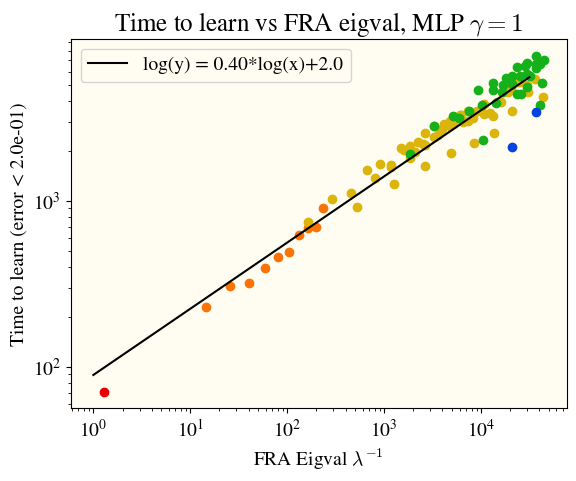

In [ ]:
breakindex = -1
plot_time_to_learn_eigenvalue(fra_eigvals[locs.long()].cpu(), breakpoint_extraction.mean(axis=-1)[:, breakindex], target_monomials, scale='log', breakpoint=f"(error < {loss_checkpoints[breakindex]:.1e})")
# plt.title("Time to learn vs FRA eigval")
xaxis = np.logspace(0, 4.5, 20)
plt.plot(xaxis, 10**(intercept)*xaxis**(slope), color='k', label=f"log(y) = {slope:.2f}*log(x)+{intercept:.1f}")
plt.legend()
plt.title(f"Time to learn vs FRA eigval, MLP $\gamma = 1$")
plt.show()

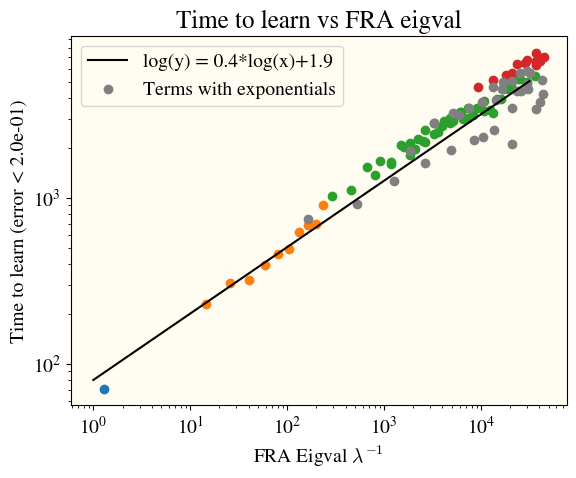

In [ ]:
breakindex = -1
fra_eigvals_plain = fra_eigvals[non_exponentiated].cpu()
plain_tfs = np.array(monomials)[non_exponentiated.flatten()]
plot_time_to_learn_eigenvalue(fra_eigvals_plain, breakpoint_extraction.mean(axis=-1)[non_exponentiated, breakindex], plain_tfs, scale='log', breakpoint=f"(error < {loss_checkpoints[breakindex]:.1e})")
plt.title("Time to learn vs FRA eigval")
xaxis = np.logspace(0, 4.5, 20)
plt.plot(xaxis, 8e1*xaxis**(0.4), color='k', label=f"log(y) = 0.4*log(x)+1.9")
plt.scatter(fra_eigvals[exponentiated_terms].cpu()**(-1.), breakpoint_extraction.mean(axis=-1)[exponentiated_terms, breakindex], color='gray', label='Terms with exponentials')
plt.legend()
plt.show()

/tmp/ipython-input-4166802240.py:83: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar((eigvals[idxs])**(-1), timekeys[idxs], yerr=kwargs.get("yerr")[idxs], marker=kwargs.get("marker", None), color=colors[degree%7], alpha=kwargs.get("alpha", 1),


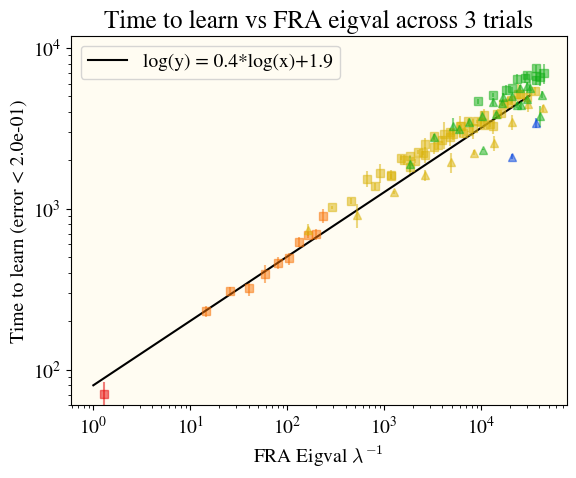

In [ ]:
breakindex = -1
fra_eigvals_plain = fra_eigvals[non_exponentiated].cpu()
plain_tfs = np.array(monomials)[non_exponentiated.flatten()]
plot_time_to_learn_eigenvalue(fra_eigvals_plain, breakpoint_extraction.mean(axis=-1)[non_exponentiated, breakindex], plain_tfs, scale='log', breakpoint=f"(error < {loss_checkpoints[breakindex]:.1e})",
                              marker='s', alpha=0.5, errorbar=True, yerr=breakpoint_extraction.var(axis=-1)[non_exponentiated, breakindex]**(0.5))
xaxis = np.logspace(0, 4.5, 20)
plt.plot(xaxis, 8e1*xaxis**(0.4), color='k', label=f"log(y) = 0.4*log(x)+1.9")
wacky_tfs = np.array(monomials)[exponentiated_terms.flatten()]
plot_time_to_learn_eigenvalue(fra_eigvals[exponentiated_terms].cpu(), breakpoint_extraction.mean(axis=-1)[exponentiated_terms, breakindex], wacky_tfs, scale='log', breakpoint=f"(error < {loss_checkpoints[breakindex]:.1e})",
                              marker='^', alpha=0.5, errorbar=True, yerr=breakpoint_extraction.var(axis=-1)[exponentiated_terms, breakindex]**(0.5))
plt.legend()
plt.ylim(bottom=6e1)
plt.title(f"Time to learn vs FRA eigval across {num_trials} trials")
plt.show()

#### sidequest to find the smallest discrepancy between eigval with a large difference in TTL for exponentiated terms

In [ ]:
wacky_tfs[np.where(np.array([tf.degree() for tf in wacky_tfs]) == 3)[0]]

array([$x_{0}^3$, $x_{0}^2x_{1}$, $x_{0}^2x_{2}$, $x_{0}x_{1}^2$,
       $x_{0}^2x_{3}$, $x_{0}^2x_{4}$, $x_{1}^3$, $x_{0}^2x_{5}$,
       $x_{0}x_{2}^2$, $x_{1}^2x_{2}$, $x_{0}^2x_{6}$, $x_{0}^2x_{7}$,
       $x_{1}^2x_{3}$, $x_{0}^2x_{8}$, $x_{1}x_{2}^2$, $x_{0}^2x_{9}$,
       $x_{0}x_{3}^2$, $x_{1}^2x_{4}$, $x_{2}^3$, $x_{1}^2x_{5}$],
      dtype=object)

In [ ]:
plain_cubic_terms = np.where(np.array([tf.degree() for tf in plain_tfs]) == 3)[0]
wacky_cubic_terms = np.where(np.array([tf.degree() for tf in wacky_tfs]) == 3)[0]
plain_cubics = (fra_eigvals[plain_cubic_terms])**(-1.)
wacky_cubics = (fra_eigvals[wacky_cubic_terms])**(-1.)
diffs = np.abs(plain_cubics.cpu().numpy().astype(np.float64)[:, None] - wacky_cubics.cpu().numpy().astype(np.float64)[None, :])

min_idx = np.unravel_index(np.argmin(diffs), diffs.shape)
min_diff = diffs[min_idx]

plain_val = plain_cubic_terms[min_idx[0]]
wacky_val = wacky_cubic_terms[min_idx[1]]
plain_val, wacky_val, min_idx[0], min_idx[1]

(np.int64(42), np.int64(30), np.int64(0), np.int64(19))

In [ ]:
(plain_cubics[min_idx[0]]**(-1.)).cpu().numpy()

array(0.00019382, dtype=float32)

In [ ]:
fra_eigvals[compterms]

tensor([2.2284e-05, 5.4114e-04], device='cuda:0')

In [ ]:
plain_tfs[plain_cubic_terms[min_idx[0]]], wacky_tfs[wacky_cubic_terms[min_idx[1]]], fra_eigvals[plain_cubic_terms[min_idx[0]]], fra_eigvals[wacky_cubic_terms[min_idx[1]]]
compterms = np.array([np.where(np.array(monomials) == term) for term in [plain_tfs[plain_cubic_terms[min_idx[0]]], wacky_tfs[wacky_cubic_terms[min_idx[1]]]]]).flatten()
# [np.where(np.array(monomials) == term for term in (plain_tfs[plain_cubic_terms[min_idx[0]]], wacky_tfs[wacky_cubic_terms[min_idx[1]]]))]

/tmp/ipython-input-4166802240.py:83: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar((eigvals[idxs])**(-1), timekeys[idxs], yerr=kwargs.get("yerr")[idxs], marker=kwargs.get("marker", None), color=colors[degree%7], alpha=kwargs.get("alpha", 1),


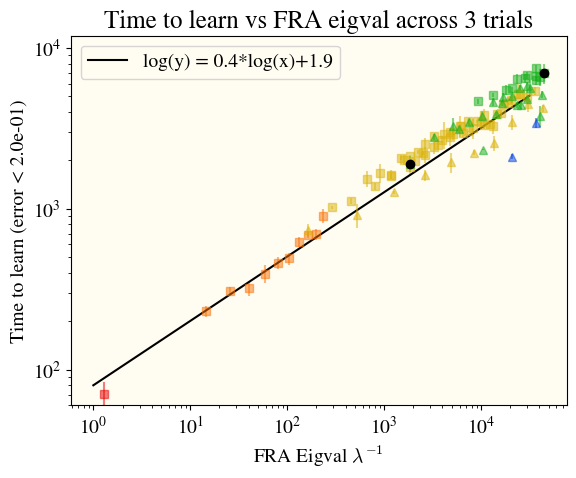

In [ ]:
breakindex = -1
fra_eigvals_plain = fra_eigvals[non_exponentiated].cpu()
plain_tfs = np.array(monomials)[non_exponentiated.flatten()]
plot_time_to_learn_eigenvalue(fra_eigvals_plain, breakpoint_extraction.mean(axis=-1)[non_exponentiated, breakindex], plain_tfs, scale='log', breakpoint=f"(error < {loss_checkpoints[breakindex]:.1e})",
                              marker='s', alpha=0.5, errorbar=True, yerr=breakpoint_extraction.var(axis=-1)[non_exponentiated, breakindex]**(0.5))
xaxis = np.logspace(0, 4.5, 20)
plt.plot(xaxis, 8e1*xaxis**(0.4), color='k', label=f"log(y) = 0.4*log(x)+1.9")
wacky_tfs = np.array(monomials)[exponentiated_terms.flatten()]
plot_time_to_learn_eigenvalue(fra_eigvals[exponentiated_terms].cpu(), breakpoint_extraction.mean(axis=-1)[exponentiated_terms, breakindex], wacky_tfs, scale='log', breakpoint=f"(error < {loss_checkpoints[breakindex]:.1e})",
                              marker='^', alpha=0.5, errorbar=True, yerr=breakpoint_extraction.var(axis=-1)[exponentiated_terms, breakindex]**(0.5))
plt.legend()
plt.ylim(bottom=6e1)
comp_tfs = np.array(monomials)[np.array(compterms).flatten()]
plt.scatter(fra_eigvals[compterms].cpu()**(-1.), breakpoint_extraction.mean(axis=-1)[compterms, breakindex], color = 'k', zorder=4)
plt.title(f"Time to learn vs FRA eigval across {num_trials} trials")
plt.show()

In [ ]:
exponentiated_terms, [term in exponentiated_terms for term in compterms]

(array([ 9, 14, 20, 25, 30, 34, 40, 42, 43, 49, 51, 55, 56, 61, 63, 64, 67,
        69, 73, 74, 76, 78, 81, 82, 85, 86, 88, 89, 94, 95, 97, 98]),
 [True, True])

/tmp/ipython-input-4166802240.py:83: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar((eigvals[idxs])**(-1), timekeys[idxs], yerr=kwargs.get("yerr")[idxs], marker=kwargs.get("marker", None), color=colors[degree%7], alpha=kwargs.get("alpha", 1),


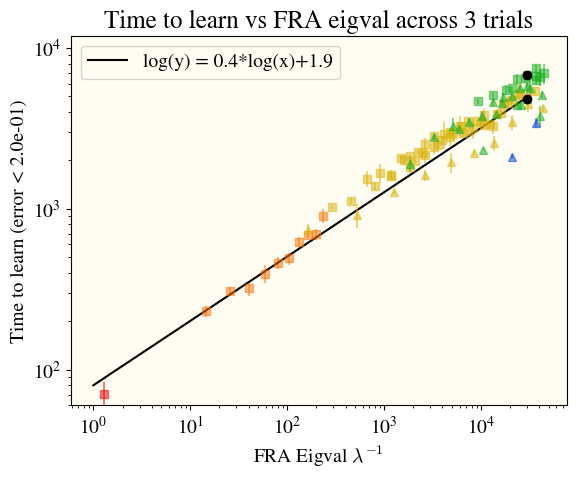

In [ ]:
breakindex = -1
fra_eigvals_plain = fra_eigvals[non_exponentiated].cpu()
plain_tfs = np.array(monomials)[non_exponentiated.flatten()]
plot_time_to_learn_eigenvalue(fra_eigvals_plain, breakpoint_extraction.mean(axis=-1)[non_exponentiated, breakindex], plain_tfs, scale='log', breakpoint=f"(error < {loss_checkpoints[breakindex]:.1e})",
                              marker='s', alpha=0.5, errorbar=True, yerr=breakpoint_extraction.var(axis=-1)[non_exponentiated, breakindex]**(0.5))
xaxis = np.logspace(0, 4.5, 20)
plt.plot(xaxis, 8e1*xaxis**(0.4), color='k', label=f"log(y) = 0.4*log(x)+1.9")
wacky_tfs = np.array(monomials)[exponentiated_terms.flatten()]
plot_time_to_learn_eigenvalue(fra_eigvals[exponentiated_terms].cpu(), breakpoint_extraction.mean(axis=-1)[exponentiated_terms, breakindex], wacky_tfs, scale='log', breakpoint=f"(error < {loss_checkpoints[breakindex]:.1e})",
                              marker='^', alpha=0.5, errorbar=True, yerr=breakpoint_extraction.var(axis=-1)[exponentiated_terms, breakindex]**(0.5))
plt.legend()
plt.ylim(bottom=6e1)
compterms = np.array([86, 87])
comp_tfs = np.array(monomials)[compterms]
plt.scatter(fra_eigvals[compterms].cpu()**(-1.), breakpoint_extraction.mean(axis=-1)[compterms, breakindex], color = 'k', zorder=4)
plt.title(f"Time to learn vs FRA eigval across {num_trials} trials")
plt.show()

In [ ]:
L = fra_eigvals.cpu().numpy()  # Example

# Step 2: Split into a and b (for example: even/odd index split)
a_indices = np.array(non_exponentiated)  # [0, 2, 4]
b_indices = np.array(exponentiated_terms)  # [1, 3, 5]
a = L[a_indices]                     # [1.0, 5.5, 9.1]
b = L[b_indices]                     # [3.2, 7.8, 11.0]

# Step 3: Apply conditions to get a_c and b_c
# For example: keep elements < 10
plain_tfs = np.array(monomials)[non_exponentiated.flatten()]
wacky_tfs = np.array(monomials)[exponentiated_terms.flatten()]

In [ ]:
plain_tfs = np.array(monomials)[non_exponentiated.flatten()]
wacky_tfs = np.array(monomials)[exponentiated_terms.flatten()]
a_mask = (np.array([tf.degree() for tf in plain_tfs]) == 3)
b_mask = (np.array([tf.degree() for tf in wacky_tfs]) == 3)

In [ ]:
a_c = a[a_mask]                      # [1.0, 5.5, 9.1]
b_c = b[b_mask]                      # [3.2, 7.8]

In [ ]:
# Step 4: Keep track of original indices
a_c_orig_indices = a_indices[a_mask]  # Indices in L
b_c_orig_indices = b_indices[b_mask]  # Indices in L

# Step 5: Compute pairwise differences
diffs = np.abs(a_c[:, None] - b_c[None, :])  # shape: (len(a_c), len(b_c))
min_idx = np.unravel_index(np.argmin(diffs), diffs.shape)
i, j = min_idx

# Step 6: Get back indices into L
idx_in_L_a = a_c_orig_indices[i]
idx_in_L_b = b_c_orig_indices[j]
print(i, j)

print(f"Minimum difference: {diffs[i, j]}")
print(f"Element from L (a side): L[{idx_in_L_a}] = {L[idx_in_L_a]}")
print(f"Element from L (b side): L[{idx_in_L_b}] = {L[idx_in_L_b]}")
# print(np.abs(a[:, None] - b[None, :]))

6 16
Minimum difference: 0.0
Element from L (a side): L[87] = 3.3355529012624174e-05
Element from L (b side): L[86] = 3.3355529012624174e-05


In [ ]:
# Step 1: Original list
L = fra_eigvals  # Example

# Step 2: Split into a and b (for example: even/odd index split)
a_indices = np.array(exponentiated_terms)  # [0, 2, 4]
b_indices = np.array(non_exponentiated)  # [1, 3, 5]
a = L[a_indices]                     # [1.0, 5.5, 9.1]
b = L[b_indices]                     # [3.2, 7.8, 11.0]

# Step 3: Apply conditions to get a_c and b_c
# For example: keep elements < 10
plain_tfs = np.array(monomials)[non_exponentiated.flatten()]
wacky_tfs = np.array(monomials)[exponentiated_terms.flatten()]
a_mask = np.where(np.array([tf.degree() for tf in plain_tfs]) == 3)[0]
b_mask = np.where(np.array([tf.degree() for tf in wacky_tfs]) == 3)[0]
a_c = a[a_mask]                      # [1.0, 5.5, 9.1]
b_c = b[b_mask]                      # [3.2, 7.8]

# Step 4: Keep track of original indices
a_c_orig_indices = a_indices[a_mask]  # Indices in L
b_c_orig_indices = b_indices[b_mask]  # Indices in L

# Step 5: Compute pairwise differences
diffs = np.abs(a_c[:, None] - b_c[None, :])  # shape: (len(a_c), len(b_c))
min_idx = np.unravel_index(np.argmin(diffs), diffs.shape)
i, j = min_idx

# Step 6: Get back indices into L
idx_in_L_a = a_c_orig_indices[i]
idx_in_L_b = b_c_orig_indices[j]
print(i, j)

print(f"Minimum difference: {diffs[i, j]}")
print(f"Element from L (a side): L[{idx_in_L_a}] = {L[idx_in_L_a]}")
print(f"Element from L (b side): L[{idx_in_L_b}] = {L[idx_in_L_b]}")
print(np.abs(a[:, None] - b[None, :]))

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


## fourth run - large gamma

In [ ]:
dim = 10
N = 10_000
offset=3
alpha=2.01
bsz = 512

X, y, locs, H, monomials, fra_eigvals, data_eigvals = get_all_targets(target_monomials=Monomial({}), dim=dim, N=N)
target_monomials = monomials[:100]#[Monomial({}), Monomial({0:1}), Monomial({0:2}), Monomial({9: 1}), Monomial({0: 2, 1:1}), Monomial({1:3})]
lr = 1e-2
width = 64
gamma = 10

num_trials = 3
max_iter = int(5e4)
loss_checkpoints = [5e-1, 2e-1]

X, y, locs, H, monomials, fra_eigvals, data_eigvals = get_all_targets(target_monomials=target_monomials, dim=dim, N=N)
U, lambdas, Vt = torch.linalg.svd(X, full_matrices=False)

Eigval Finder: 100%|██████████| 1000/1000 [00:00<00:00, 9586.74step/s]


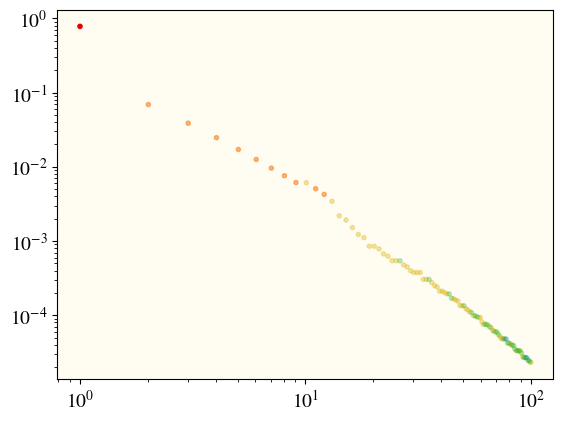

In [ ]:
colors = ['xkcd:red', 'xkcd:orange', 'xkcd:gold', 'xkcd:green', 'xkcd:blue', "xkcd:purple", "xkcd:black"]
degrees = np.array([monomial.degree() for monomial in monomials[:int(locs[-1])]])
indices = np.linspace(1, int(locs[-1])+1, int(locs[-1]))
for degree in np.unique(degrees):
    idxs = np.where(np.array(degrees) == degree)[0]
    plt.scatter(indices[idxs], fra_eigvals[idxs].cpu(), color=colors[degree%7], linestyle='', marker='.', alpha=1/(degree+1),)
plt.yscale("log")
plt.xscale('log')

In [ ]:
all_losses = np.ones((len(target_monomials), num_trials, max_iter))*max(loss_checkpoints)
breakpoints = np.empty((len(target_monomials), len(loss_checkpoints), num_trials))
pbar = tqdm(enumerate(target_monomials), total=len(target_monomials), desc="Processing items")


# for idx, target_monomial in tenumerate(target_monomials, desc="Target fitting", unit="step", total=len(monomials), ):
for idx, target_monomial in pbar:
    # print(f"Target = {target_monomial}")
    model = MLP(d_in=dim, depth=2, d_out=1, width=width).to(device)
    for trial in range(num_trials):
        model, losses, breakpoint = train_network_online(lambdas, Vt, target_monomial, dim, bsz=bsz, data_eigvals=data_eigvals, N=N, lr=lr, max_iter=max_iter,
                                                         loss_checkpoints=loss_checkpoints, gamma=gamma)
        all_losses[idx, trial] = losses
        breakpoints[idx, :, trial] = breakpoint
    pbar.set_postfix(current_item=target_monomial, iteration=idx + 1)
        # print(f"Trial {trial} Breakpoint {breakpoint}")

Processing items: 100%|██████████| 100/100 [38:07<00:00, 22.88s/it, current_item=$x_{0}x_{1}x_{8}$, iteration=100]


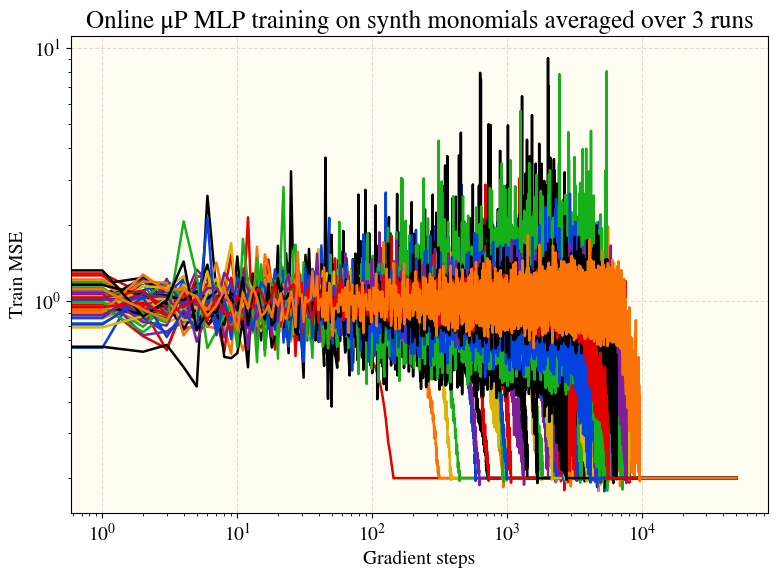

In [ ]:
plt.figure(figsize=(8,6))
for idx, target_monomial in enumerate(target_monomials):
    plt.plot(all_losses[idx].mean(axis=0), label=f"Monomial {target_monomial} w/ eigval {fra_eigvals[int(locs[idx].cpu().numpy())]:.3e}", color=colors[idx%7], lw=1.8)
plt.xscale('log')
plt.yscale('log')
plt.grid(True, ls='--', alpha=.4)
plt.xlabel("Gradient steps")
plt.ylabel("Train MSE")
plt.title(f"Online μP MLP training on synth monomials averaged over {num_trials} runs")
# plt.legend()
plt.tight_layout(); plt.show()

In [ ]:
breakindex = -1
xaxis = (fra_eigvals[locs.long()].cpu())**(-1.)
log_x = torch.log10(ensure_torch(xaxis))
log_x_centered_w_intercept = torch.column_stack((log_x, torch.ones_like(log_x)))

sol = torch.linalg.lstsq(log_x_centered_w_intercept, ensure_torch(torch.log10(ensure_torch(breakpoints).mean(axis=-1)[:, breakindex])).unsqueeze(1)).solution.squeeze()
slope          = float(sol[0])
intercept     = float(sol[1])

<>:7: SyntaxWarning: invalid escape sequence '\g'
<>:7: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipython-input-2912662992.py:7: SyntaxWarning: invalid escape sequence '\g'
  plt.title(f"Time to learn vs FRA eigval, MLP $\gamma ={gamma}$")
/tmp/ipython-input-3798012023.py:85: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar((eigvals[idxs])**(-1), timekeys[idxs], yerr=kwargs.get("yerr")[idxs], marker=kwargs.get("marker", None), color=colors[degree%7], alpha=kwargs.get("alpha", 1),


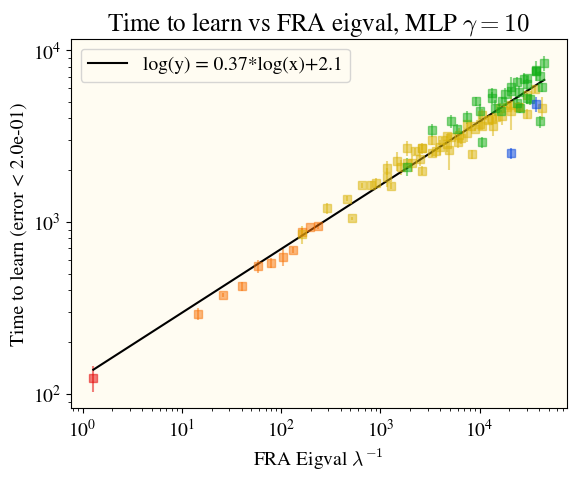

In [ ]:
plot_time_to_learn_eigenvalue(fra_eigvals[locs.long()].cpu(), breakpoints.mean(axis=-1)[:, breakindex], target_monomials, scale='log', breakpoint=f"(error < {loss_checkpoints[breakindex]:.1e})",
                              marker='s', alpha=0.5, errorbar=True, yerr=breakpoints.var(axis=-1)[:, breakindex]**(0.5))
plt.plot(xaxis, 10**(intercept)*xaxis**(slope), color='k', label=f"log(y) = {slope:.2f}*log(x)+{intercept:.1f}")
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.title(f"Time to learn vs FRA eigval, MLP $\gamma ={gamma}$")
plt.show()

In [ ]:
fra_eigvals[locs.long()], breakpoints.mean(axis=-1)[:, breakindex]

(tensor([7.7880e-01, 6.8980e-02, 3.8690e-02, 2.4706e-02, 1.7126e-02, 1.2563e-02,
         9.6056e-03, 7.5807e-03, 6.1339e-03, 6.1096e-03, 5.0645e-03, 4.2519e-03,
         3.4268e-03, 2.1883e-03, 1.9220e-03, 1.5169e-03, 1.2274e-03, 1.1127e-03,
         8.5078e-04, 8.5078e-04, 7.8376e-04, 6.7143e-04, 6.2410e-04, 5.4329e-04,
         5.4329e-04, 5.4114e-04, 4.7719e-04, 4.4857e-04, 3.9853e-04, 3.7659e-04,
         3.7659e-04, 3.7659e-04, 3.0472e-04, 3.0472e-04, 3.0352e-04, 2.7626e-04,
         2.5159e-04, 2.4048e-04, 2.1123e-04, 2.1123e-04, 2.0265e-04, 1.9459e-04,
         1.9382e-04, 1.7024e-04, 1.6670e-04, 1.6066e-04, 1.5495e-04, 1.3488e-04,
         1.3488e-04, 1.3435e-04, 1.2228e-04, 1.1847e-04, 1.1137e-04, 1.0871e-04,
         9.8945e-05, 9.8554e-05, 9.5483e-05, 9.3498e-05, 9.3498e-05, 8.1695e-05,
         7.5654e-05, 7.5355e-05, 7.5355e-05, 7.3788e-05, 6.9419e-05, 6.8587e-05,
         6.2464e-05, 6.0973e-05, 5.9706e-05, 5.9470e-05, 5.5277e-05, 5.2442e-05,
         4.9296e-05, 4.8311e

## fifth run - small gamma

In [ ]:
dim = 10
N = 10_000
offset=3
alpha=2.01
bsz = 512

X, y, locs, H, monomials, fra_eigvals, data_eigvals = get_all_targets(target_monomials=Monomial({}), dim=dim, N=N)
target_monomials = [Monomial({}), Monomial({0:1}), Monomial({0:2}), Monomial({9: 1}), Monomial({0: 2, 1:1}), Monomial({1:3})]#monomials[:100]#
lr = 1e-2
width = 64
gamma = 0.01

num_trials = 3
max_iter = int(1e4)
loss_checkpoints = [5e-1, 2e-1]

X, y, locs, H, monomials, fra_eigvals, data_eigvals = get_all_targets(target_monomials=target_monomials, dim=dim, N=N)
U, lambdas, Vt = torch.linalg.svd(X, full_matrices=False)

Eigval Finder: 100%|██████████| 1000/1000 [00:00<00:00, 5444.76step/s]


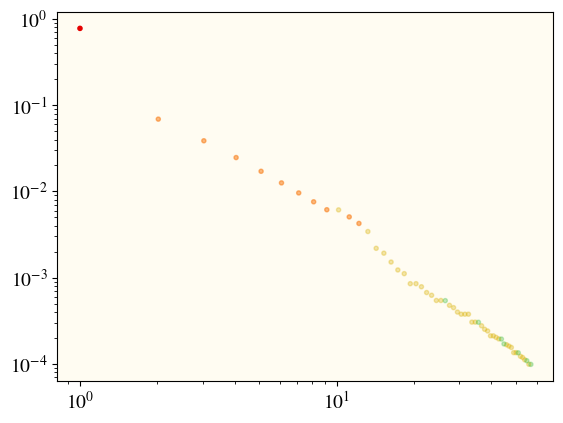

In [ ]:
colors = ['xkcd:red', 'xkcd:orange', 'xkcd:gold', 'xkcd:green', 'xkcd:blue', "xkcd:purple", "xkcd:black"]
degrees = np.array([monomial.degree() for monomial in monomials[:int(locs[-1])]])
indices = np.linspace(1, int(locs[-1])+1, int(locs[-1]))
for degree in np.unique(degrees):
    idxs = np.where(np.array(degrees) == degree)[0]
    plt.scatter(indices[idxs], fra_eigvals[idxs].cpu(), color=colors[degree%7], linestyle='', marker='.', alpha=1/(degree+1),)
plt.yscale("log")
plt.xscale('log')

In [ ]:
all_losses = np.ones((len(target_monomials), num_trials, max_iter))*max(loss_checkpoints)
breakpoints = np.empty((len(target_monomials), len(loss_checkpoints), num_trials))
pbar = tqdm(enumerate(target_monomials), total=len(target_monomials), desc="Processing items")


# for idx, target_monomial in tenumerate(target_monomials, desc="Target fitting", unit="step", total=len(monomials), ):
for idx, target_monomial in pbar:
    # print(f"Target = {target_monomial}")
    model = MLP(d_in=dim, depth=2, d_out=1, width=width).to(device)
    for trial in range(num_trials):
        model, losses, breakpoint = train_network_online(lambdas, Vt, target_monomial, dim, bsz=bsz, data_eigvals=data_eigvals, N=N, lr=lr, max_iter=max_iter,
                                                         loss_checkpoints=loss_checkpoints, gamma=gamma)
        all_losses[idx, trial] = losses
        breakpoints[idx, :, trial] = breakpoint
    pbar.set_postfix(current_item=target_monomial, iteration=idx + 1)
        # print(f"Trial {trial} Breakpoint {breakpoint}")

Processing items: 100%|██████████| 6/6 [06:59<00:00, 69.96s/it, current_item=$x_{1}^3$, iteration=6]


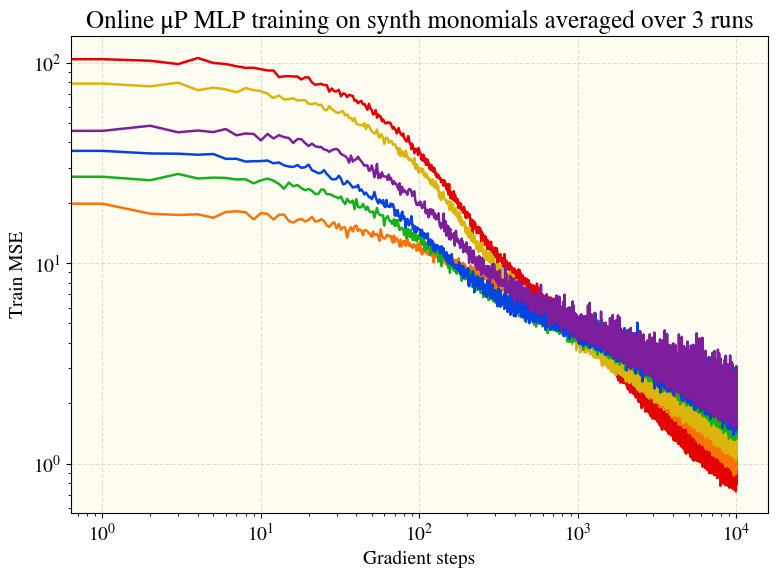

In [ ]:
plt.figure(figsize=(8,6))
for idx, target_monomial in enumerate(target_monomials):
    plt.plot(all_losses[idx].mean(axis=0), label=f"Monomial {target_monomial} w/ eigval {fra_eigvals[int(locs[idx].cpu().numpy())]:.3e}", color=colors[idx%7], lw=1.8)
plt.xscale('log')
plt.yscale('log')
plt.grid(True, ls='--', alpha=.4)
plt.xlabel("Gradient steps")
plt.ylabel("Train MSE")
plt.title(f"Online μP MLP training on synth monomials averaged over {num_trials} runs")
# plt.legend()
plt.tight_layout(); plt.show()

In [ ]:
breakindex = -1
xaxis = (fra_eigvals[locs.long()].cpu())**(-1.)
log_x = torch.log10(ensure_torch(xaxis))
log_x_centered_w_intercept = torch.column_stack((log_x, torch.ones_like(log_x)))

sol = torch.linalg.lstsq(log_x_centered_w_intercept, ensure_torch(torch.log10(ensure_torch(breakpoints).mean(axis=-1)[:, breakindex])).unsqueeze(1)).solution.squeeze()
slope          = float(sol[0])
intercept     = float(sol[1])

<>:7: SyntaxWarning: invalid escape sequence '\g'
<>:7: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipython-input-2912662992.py:7: SyntaxWarning: invalid escape sequence '\g'
  plt.title(f"Time to learn vs FRA eigval, MLP $\gamma ={gamma}$")
/tmp/ipython-input-1733474264.py:85: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar((eigvals[idxs])**(-1), timekeys[idxs], yerr=kwargs.get("yerr")[idxs], marker=kwargs.get("marker", None), color=colors[degree%7], alpha=kwargs.get("alpha", 1),


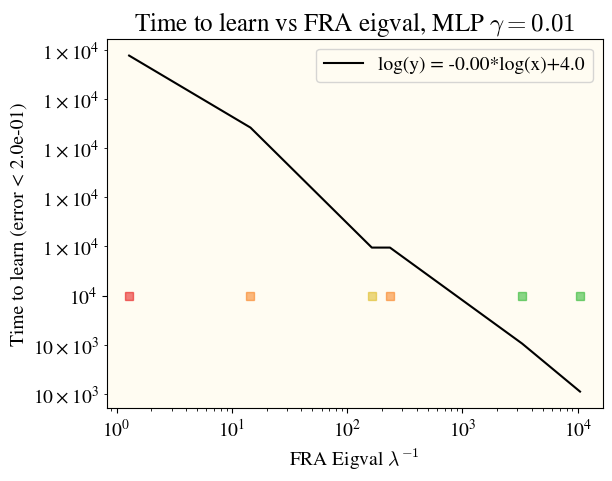

In [ ]:
plot_time_to_learn_eigenvalue(fra_eigvals[locs.long()].cpu(), breakpoints.mean(axis=-1)[:, breakindex], target_monomials, scale='log', breakpoint=f"(error < {loss_checkpoints[breakindex]:.1e})",
                              marker='s', alpha=0.5, errorbar=True, yerr=breakpoints.var(axis=-1)[:, breakindex]**(0.5))
plt.plot(xaxis, 10**(intercept)*xaxis**(slope), color='k', label=f"log(y) = {slope:.2f}*log(x)+{intercept:.1f}")
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.title(f"Time to learn vs FRA eigval, MLP $\gamma ={gamma}$")
plt.show()

In [ ]:
all_losses.shape

NameError: name 'all_losses' is not defined

# training MLPs - large width (8192)

## testing small but not super small gamma; increased width massively
seems like the issue of having everything learned unevenly goes away when the width becomes much larger (check recent plots over old ones)

In [48]:
dim = 10
N = 10_000
offset=3
alpha=2.01
bsz = 512

X, y, locs, H, monomials, fra_eigvals, data_eigvals = get_all_targets(target_monomials=Monomial({}), dim=dim, N=N, )
target_monomials = monomials[:100]
lr = 1e-2
width = 8192
gamma = 0.1

num_trials = 5
max_iter = int(5e4)
loss_checkpoints = (5e-1, 2e-1)
percent_thresholds = (0.75, 0.5, .2)

X, y, locs, H, monomials, fra_eigvals, data_eigvals = get_all_targets(target_monomials=target_monomials, dim=dim, N=N)
U, lambdas, Vt = torch.linalg.svd(X, full_matrices=False)

Generating monomials: 100%|██████████| 10000/10000 [00:01<00:00, 8221.74step/s]


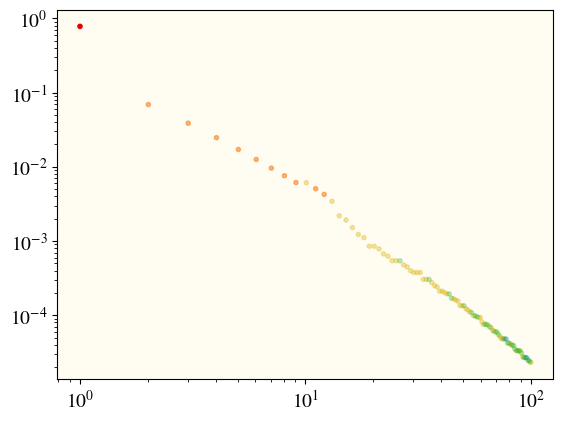

In [9]:
colors = ['xkcd:red', 'xkcd:orange', 'xkcd:gold', 'xkcd:green', 'xkcd:blue', "xkcd:purple", "xkcd:black"]
degrees = np.array([monomial.degree() for monomial in monomials[:int(locs[-1])]])
indices = np.linspace(1, int(locs[-1])+1, int(locs[-1]))
for degree in np.unique(degrees):
    idxs = np.where(np.array(degrees) == degree)[0]
    plt.scatter(indices[idxs], fra_eigvals[idxs].cpu(), color=colors[degree%7], linestyle='', marker='.', alpha=1/(degree+1),)
plt.yscale("log")
plt.xscale('log')

In [35]:
all_losses = np.ones((len(target_monomials), num_trials, max_iter))*max(loss_checkpoints)
breakpoints = np.empty((len(target_monomials), len(loss_checkpoints), num_trials))
pct_breakpoints = np.empty((len(target_monomials), len(loss_checkpoints), num_trials))
pbar = tqdm(enumerate(target_monomials), total=len(target_monomials), desc="Processing items")


# for idx, target_monomial in tenumerate(target_monomials, desc="Target fitting", unit="step", total=len(monomials), ):
for idx, target_monomial in pbar:
    # print(f"Target = {target_monomial}")
    model = MLP(d_in=dim, depth=2, d_out=1, width=width).to(device)
    for trial in range(num_trials):
        model, losses, breakpoint, pct_breakpoint = train_network_online_percents(lambdas, Vt, target_monomial, dim, bsz=bsz, data_eigvals=data_eigvals, N=N, lr=lr, max_iter=max_iter,
                                                         loss_checkpoints=loss_checkpoints, gamma=gamma, percent_thresholds=(0.75, 0.5), pct_use_ema=False)
        all_losses[idx, trial] = losses
        breakpoints[idx, :, trial] = breakpoint
        pct_breakpoints[idx, :, trial] = pct_breakpoint
    pbar.set_postfix(current_item=target_monomial, iteration=idx + 1)
        # print(f"Trial {trial} Breakpoint {breakpoint}")

Processing items:  19%|█▉        | 5/26 [11:03<46:25, 132.66s/it, current_item=$x_{3}$, iteration=5]


KeyboardInterrupt: 

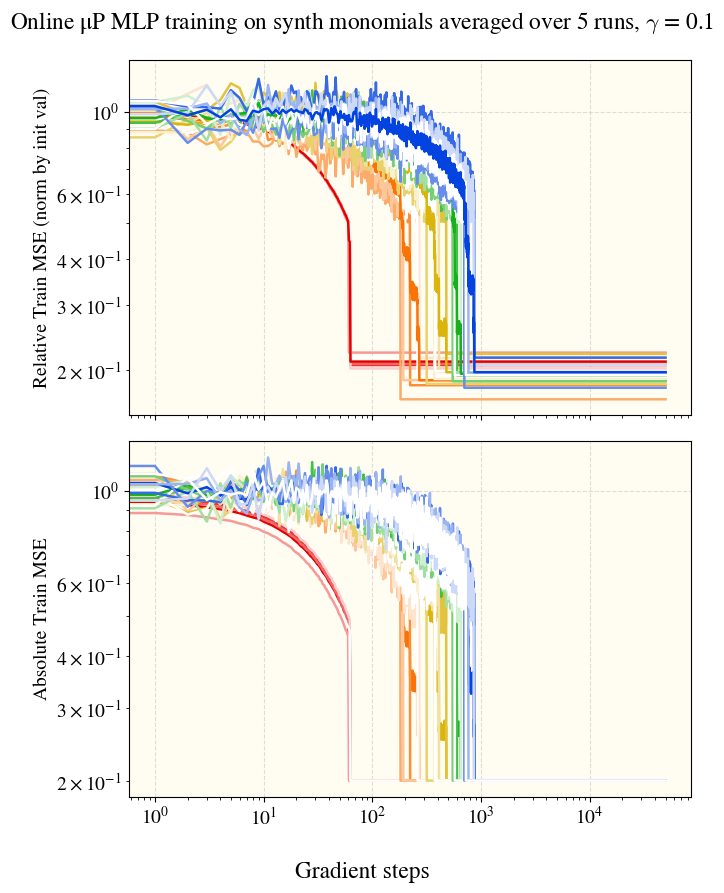

In [49]:
target_monomials = monomials[:26]
fig, axes = plt.subplots(2, 1, figsize=(7,9), sharex=True)
ax = axes[0]
for idx, target_monomial in enumerate(target_monomials):
    if idx > 4:
        break
    for run in range(num_trials):
        ax.plot(all_losses[idx][run]/all_losses[idx][run, 0], label=f"Monomial {target_monomial} w/ $\\lambda$ {fra_eigvals[int(locs[idx].cpu().numpy())]:.3e}", color=lighten(colors[idx%7], 0.2*(run+1)), lw=1.8)
    ax.plot(all_losses[idx].mean(axis=0)/all_losses[idx].mean(axis=0)[0], label=f"Monomial {target_monomial} w/ $\\lambda$ {fra_eigvals[int(locs[idx].cpu().numpy())]:.3e}", color=colors[idx%7], lw=1.8)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel("Relative Train MSE (norm by init val)")
ax.grid(True, ls='--', alpha=.4)
# ax.legend()
ax = axes[1]
for idx, target_monomial in enumerate(target_monomials):
    if idx > 4:
        break
    ax.plot(all_losses[idx].mean(axis=0), label=f"{target_monomial}, $\\lambda_{{FRA}}={fra_eigvals[int(locs[idx].cpu().numpy())]:.2e}$", color=colors[idx%7], lw=1.8)
    for run in range(num_trials):
        ax.plot(all_losses[idx][run], label=f"{target_monomial}, $\\lambda_{{FRA}}={fra_eigvals[int(locs[idx].cpu().numpy())]:.2e}$", color=lighten(colors[idx%7], 0.2*(run+1)), lw=1.8)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel("Absolute Train MSE")
ax.grid(True, ls='--', alpha=.4)
# ax.legend()

fig.supxlabel("Gradient steps")
fig.suptitle(f"Online μP MLP training on synth monomials averaged over {num_trials} runs, $\\gamma$ = {gamma}")
# plt.legend()
plt.tight_layout(); plt.show()

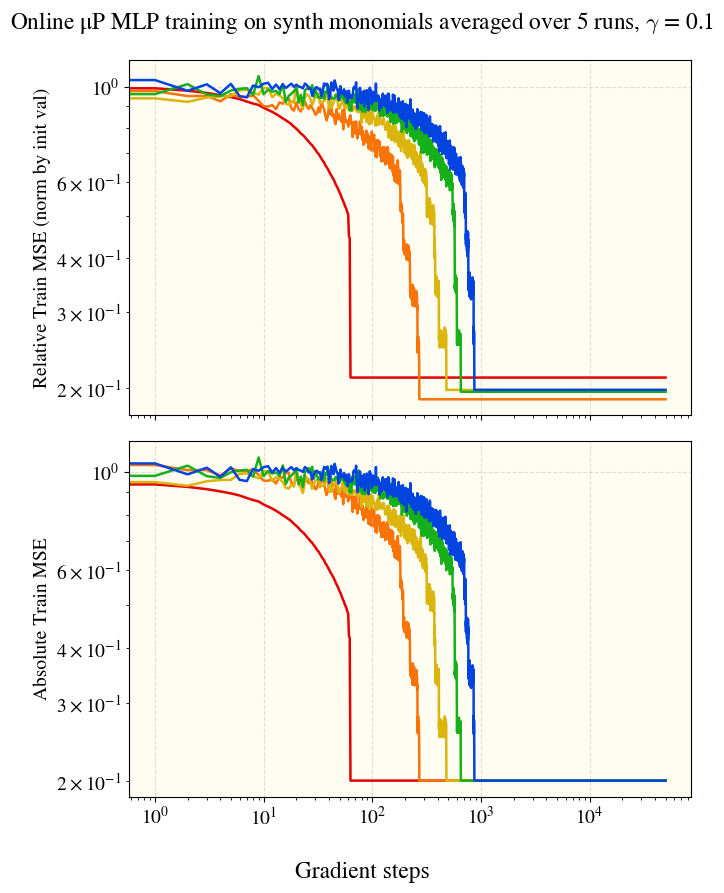

In [50]:
target_monomials = monomials[:26]
fig, axes = plt.subplots(2, 1, figsize=(7,9), sharex=True)
ax = axes[0]
for idx, target_monomial in enumerate(target_monomials):
    if idx > 4:
        break
    ax.plot(all_losses[idx].mean(axis=0)/all_losses[idx].mean(axis=0)[0], label=f"Monomial {target_monomial} w/ $\\lambda$ {fra_eigvals[int(locs[idx].cpu().numpy())]:.3e}", color=colors[idx%7], lw=1.8)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel("Relative Train MSE (norm by init val)")
ax.grid(True, ls='--', alpha=.4)
# ax.legend()
ax = axes[1]
for idx, target_monomial in enumerate(target_monomials):
    if idx > 4:
        break
    ax.plot(all_losses[idx].mean(axis=0), label=f"{target_monomial}, $\\lambda_{{FRA}}={fra_eigvals[int(locs[idx].cpu().numpy())]:.2e}$", color=colors[idx%7], lw=1.8)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel("Absolute Train MSE")
ax.grid(True, ls='--', alpha=.4)
# ax.legend()

fig.supxlabel("Gradient steps")
fig.suptitle(f"Online μP MLP training on synth monomials averaged over {num_trials} runs, $\\gamma$ = {gamma}")
# plt.legend()
plt.tight_layout(); plt.show()

In [51]:
breakindex = -1
xaxis = (fra_eigvals[locs.long()[:5]].cpu())**(-1.)
log_x = torch.log10(ensure_torch(xaxis))
log_x_centered_w_intercept = torch.column_stack((log_x, torch.ones_like(log_x)))

sol = torch.linalg.lstsq(log_x_centered_w_intercept, ensure_torch(torch.log10(ensure_torch(pct_breakpoints).mean(axis=-1)[:5, breakindex])).unsqueeze(1)).solution.squeeze()
slope          = float(sol[0])
intercept     = float(sol[1])

/tmp/ipython-input-2131616977.py:164: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar((eigvals[idxs])**(-1), timekeys[idxs], yerr=kwargs.get("yerr")[idxs], marker=kwargs.get("marker", None), color=colors[degree%7], alpha=kwargs.get("alpha", 1),


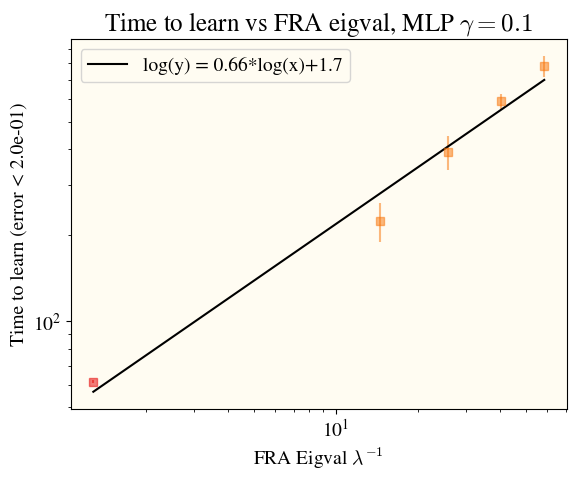

In [52]:
plot_time_to_learn_eigenvalue(fra_eigvals[locs.long()].cpu(), pct_breakpoints.mean(axis=-1)[:5, breakindex], target_monomials[:5], scale='log', breakpoint=f"(error < {loss_checkpoints[breakindex]:.1e})",
                              marker='s', alpha=0.5, errorbar=True, yerr=pct_breakpoints.var(axis=-1)[:5, breakindex]**(0.5))
plt.plot(xaxis, 10**(intercept)*xaxis**(slope), color='k', label=f"log(y) = {slope:.2f}*log(x)+{intercept:.1f}")
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.title(f"Time to learn vs FRA eigval, MLP $\\gamma ={gamma}$")
plt.show()

## testing larger gamma
hopefully this has a similar effect to the above test

yes! also, the error on when terms are learned is quite small when gamma is larger, so can probably do 1 trial for everything during testing

In [53]:
dim = 10
N = 10_000
offset=3
alpha=2.01
bsz = 512

X, y, locs, H, monomials, fra_eigvals, data_eigvals = get_all_targets(target_monomials=Monomial({}), dim=dim, N=N, )
target_monomials = monomials[:100]#[Monomial({}), Monomial({0:1}), Monomial({0:2}), Monomial({9: 1}), Monomial({0: 2, 1:1}), Monomial({1:3})]#
lr = 1e-2
width = 8192
gamma = 10

num_trials = 5
max_iter = int(5e4)
loss_checkpoints = (5e-1, 2e-1)
percent_thresholds = (0.75, 0.5, .2)

X, y, locs, H, monomials, fra_eigvals, data_eigvals = get_all_targets(target_monomials=target_monomials, dim=dim, N=N)
U, lambdas, Vt = torch.linalg.svd(X, full_matrices=False)

Generating monomials: 100%|██████████| 10000/10000 [00:01<00:00, 6257.62step/s]


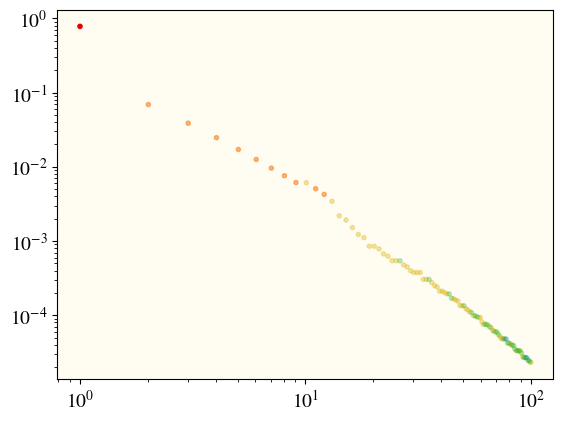

In [54]:
colors = ['xkcd:red', 'xkcd:orange', 'xkcd:gold', 'xkcd:green', 'xkcd:blue', "xkcd:purple", "xkcd:black"]
degrees = np.array([monomial.degree() for monomial in monomials[:int(locs[-1])]])
indices = np.linspace(1, int(locs[-1])+1, int(locs[-1]))
for degree in np.unique(degrees):
    idxs = np.where(np.array(degrees) == degree)[0]
    plt.scatter(indices[idxs], fra_eigvals[idxs].cpu(), color=colors[degree%7], linestyle='', marker='.', alpha=1/(degree+1),)
plt.yscale("log")
plt.xscale('log')

In [59]:
all_losses = np.ones((len(target_monomials), num_trials, max_iter))*max(loss_checkpoints)
breakpoints = np.empty((len(target_monomials), len(loss_checkpoints), num_trials))
pct_breakpoints = np.empty((len(target_monomials), len(loss_checkpoints), num_trials))
pbar = tqdm(enumerate(target_monomials), total=len(target_monomials), desc="Processing items")

for idx, target_monomial in pbar:
    # print(f"Target = {target_monomial}")
    model = MLP(d_in=dim, depth=2, d_out=1, width=width).to(device)
    for trial in range(num_trials):
        model, losses, breakpoint, pct_breakpoint = train_network_online_percents(lambdas, Vt, target_monomial, dim, bsz=bsz, data_eigvals=data_eigvals, N=N, lr=lr, max_iter=max_iter,
                                                         loss_checkpoints=loss_checkpoints, gamma=gamma, percent_thresholds=percent_thresholds, pct_use_ema=False)
        all_losses[idx, trial] = losses
        breakpoints[idx, :, trial] = breakpoint
        pct_breakpoints[idx, :, trial] = pct_breakpoint
    pbar.set_postfix(current_item=target_monomial, iteration=idx + 1)
        # print(f"Trial {trial} Breakpoint {breakpoint}")

Processing items:   6%|▌         | 6/100 [10:02<2:37:26, 100.49s/it, current_item=$x_{4}$, iteration=6]


KeyboardInterrupt: 

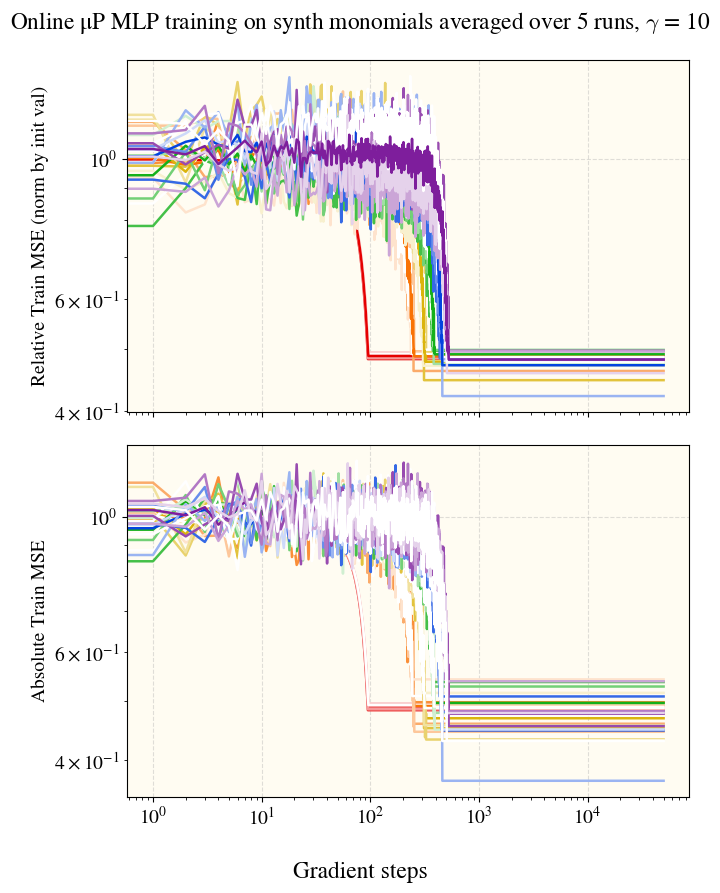

In [61]:
# target_monomials = monomials[:26]
fig, axes = plt.subplots(2, 1, figsize=(7,9), sharex=True)
ax = axes[0]
for idx, target_monomial in enumerate(target_monomials):
    if idx > 5:
        break
    for run in range(num_trials):
        ax.plot(all_losses[idx][run]/all_losses[idx][run, 0], label=f"Monomial {target_monomial} w/ $\\lambda$ {fra_eigvals[int(locs[idx].cpu().numpy())]:.3e}", color=lighten(colors[idx%7], 0.2*(run+1)), lw=1.8)
    ax.plot(all_losses[idx].mean(axis=0)/all_losses[idx].mean(axis=0)[0], label=f"Monomial {target_monomial} w/ $\\lambda$ {fra_eigvals[int(locs[idx].cpu().numpy())]:.3e}", color=colors[idx%7], lw=1.8)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel("Relative Train MSE (norm by init val)")
ax.grid(True, ls='--', alpha=.4)
# ax.legend()
ax = axes[1]
for idx, target_monomial in enumerate(target_monomials):
    if idx > 5:
        break
    ax.plot(all_losses[idx].mean(axis=0), label=f"{target_monomial}, $\\lambda_{{FRA}}={fra_eigvals[int(locs[idx].cpu().numpy())]:.2e}$", color=colors[idx%7], lw=1.8)
    for run in range(num_trials):
        ax.plot(all_losses[idx][run], label=f"{target_monomial}, $\\lambda_{{FRA}}={fra_eigvals[int(locs[idx].cpu().numpy())]:.2e}$", color=lighten(colors[idx%7], 0.2*(run+1)), lw=1.8)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel("Absolute Train MSE")
ax.grid(True, ls='--', alpha=.4)
# ax.legend()

fig.supxlabel("Gradient steps")
fig.suptitle(f"Online μP MLP training on synth monomials averaged over {num_trials} runs, $\\gamma$ = {gamma}")
# plt.legend()
plt.tight_layout(); plt.show()

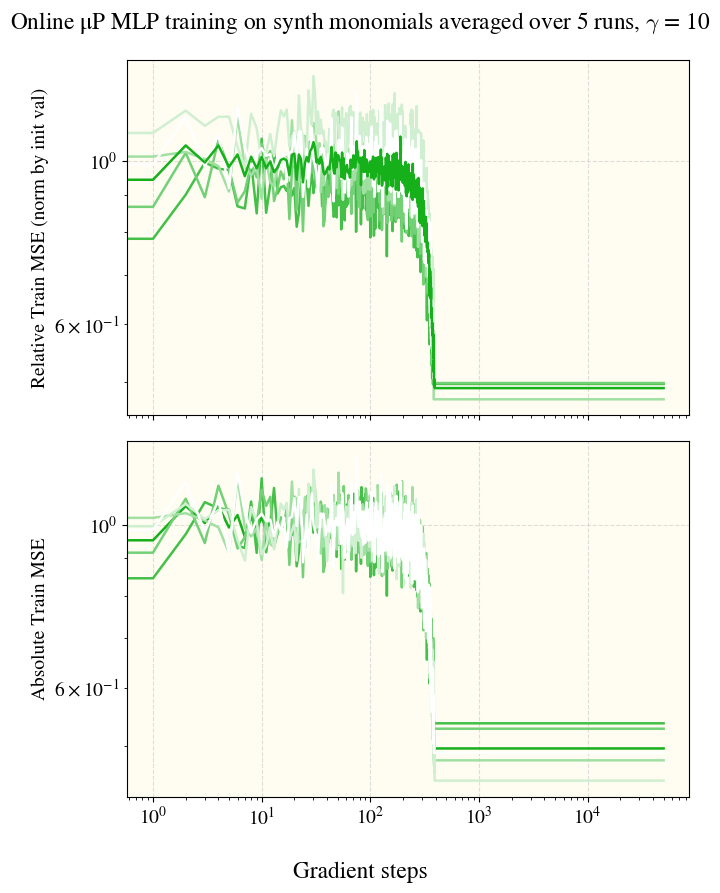

In [67]:
# target_monomials = monomials[:26]
fig, axes = plt.subplots(2, 1, figsize=(7,9), sharex=True)
ax = axes[0]
for idx, target_monomial in enumerate(target_monomials):
    if idx != 3:
        continue
    for run in range(num_trials):
        ax.plot(all_losses[idx][run]/all_losses[idx][run, 0], label=f"Monomial {target_monomial} w/ $\\lambda$ {fra_eigvals[int(locs[idx].cpu().numpy())]:.3e}", color=lighten(colors[idx%7], 0.2*(run+1)), lw=1.8)
    ax.plot(all_losses[idx].mean(axis=0)/all_losses[idx].mean(axis=0)[0], label=f"Monomial {target_monomial} w/ $\\lambda$ {fra_eigvals[int(locs[idx].cpu().numpy())]:.3e}", color=colors[idx%7], lw=1.8)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel("Relative Train MSE (norm by init val)")
ax.grid(True, ls='--', alpha=.4)
# ax.legend()
ax = axes[1]
for idx, target_monomial in enumerate(target_monomials):
    if idx != 3:
        continue
    ax.plot(all_losses[idx].mean(axis=0), label=f"{target_monomial}, $\\lambda_{{FRA}}={fra_eigvals[int(locs[idx].cpu().numpy())]:.2e}$", color=colors[idx%7], lw=1.8)
    for run in range(num_trials):
        ax.plot(all_losses[idx][run], label=f"{target_monomial}, $\\lambda_{{FRA}}={fra_eigvals[int(locs[idx].cpu().numpy())]:.2e}$", color=lighten(colors[idx%7], 0.2*(run+1)), lw=1.8)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel("Absolute Train MSE")
ax.grid(True, ls='--', alpha=.4)
# ax.legend()

fig.supxlabel("Gradient steps")
fig.suptitle(f"Online μP MLP training on synth monomials averaged over {num_trials} runs, $\\gamma$ = {gamma}")
# plt.legend()
plt.tight_layout(); plt.show()

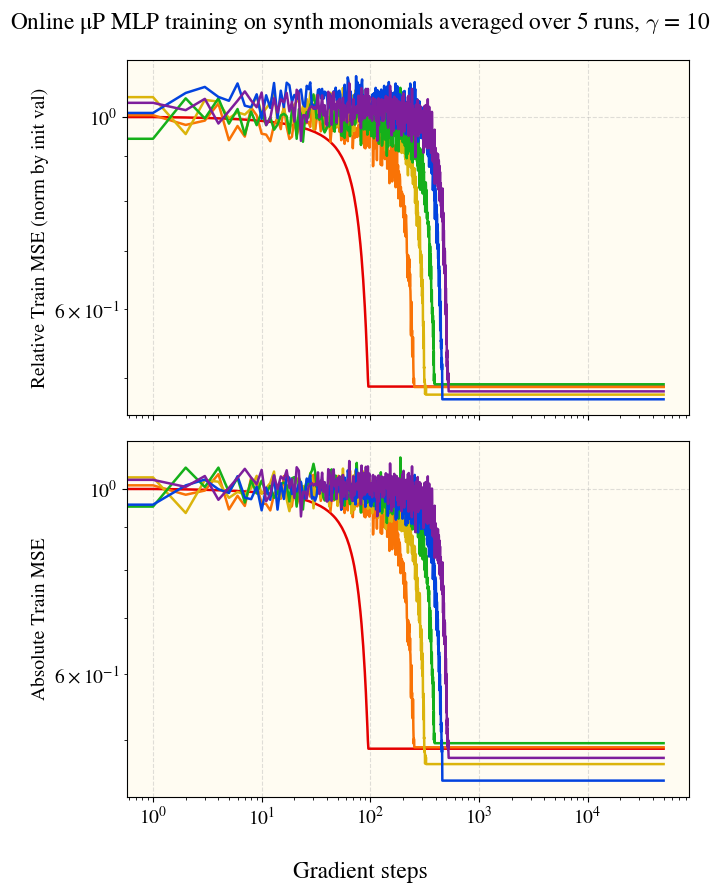

In [64]:
target_monomials = monomials[:26]
fig, axes = plt.subplots(2, 1, figsize=(7,9), sharex=True)
ax = axes[0]
for idx, target_monomial in enumerate(target_monomials):
    if idx > 5:
        break
    ax.plot(all_losses[idx].mean(axis=0)/all_losses[idx].mean(axis=0)[0], label=f"Monomial {target_monomial} w/ $\\lambda$ {fra_eigvals[int(locs[idx].cpu().numpy())]:.3e}", color=colors[idx%7], lw=1.8)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel("Relative Train MSE (norm by init val)")
ax.grid(True, ls='--', alpha=.4)
# ax.legend()
ax = axes[1]
for idx, target_monomial in enumerate(target_monomials):
    if idx > 5:
        break
    ax.plot(all_losses[idx].mean(axis=0), label=f"{target_monomial}, $\\lambda_{{FRA}}={fra_eigvals[int(locs[idx].cpu().numpy())]:.2e}$", color=colors[idx%7], lw=1.8)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel("Absolute Train MSE")
ax.grid(True, ls='--', alpha=.4)
# ax.legend()

fig.supxlabel("Gradient steps")
fig.suptitle(f"Online μP MLP training on synth monomials averaged over {num_trials} runs, $\\gamma$ = {gamma}")
# plt.legend()
plt.tight_layout(); plt.show()

In [65]:
breakindex = -1
xaxis = (fra_eigvals[locs.long()[:5]].cpu())**(-1.)
log_x = torch.log10(ensure_torch(xaxis))
log_x_centered_w_intercept = torch.column_stack((log_x, torch.ones_like(log_x)))

sol = torch.linalg.lstsq(log_x_centered_w_intercept, ensure_torch(torch.log10(ensure_torch(pct_breakpoints).mean(axis=-1)[:5, breakindex])).unsqueeze(1)).solution.squeeze()
slope          = float(sol[0])
intercept     = float(sol[1])

/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:188: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/tmp/ipython-input-1141240279.py:166: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar((eigvals[idxs])**(-1), timekeys[idxs], yerr=kwargs.get("yerr")[idxs], marker=kwargs.get("marker", None), color=colors[degree%7], alpha=kwargs.get("alpha", 1),


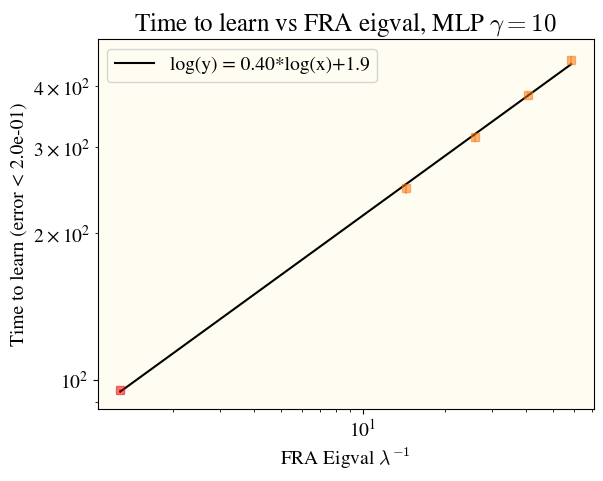

In [66]:
plot_time_to_learn_eigenvalue(fra_eigvals[locs.long()].cpu(), pct_breakpoints.mean(axis=-1)[:5, breakindex], target_monomials[:5], scale='log', breakpoint=f"(error < {loss_checkpoints[breakindex]:.1e})",
                              marker='s', alpha=0.5, errorbar=True, yerr=pct_breakpoints.var(axis=-1)[:5, breakindex]**(0.5))
plt.plot(xaxis, 10**(intercept)*xaxis**(slope), color='k', label=f"log(y) = {slope:.2f}*log(x)+{intercept:.1f}")
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.title(f"Time to learn vs FRA eigval, MLP $\\gamma ={gamma}$")
plt.show()

## testing gamma = 1
trying to get that 0.5 slope

In [15]:
dim = 10
N = 10_000
offset=3
alpha=1.2
bsz = 512

X, y, locs, H, monomials, fra_eigvals, data_eigvals = get_all_targets(target_monomials=Monomial({}), dim=dim, N=N)
target_monomials = monomials[:10]
lr = 1e-2
width = 8192
gamma = 1

colors = ['xkcd:red', 'xkcd:orange', 'xkcd:gold', 'xkcd:green', 'xkcd:blue', "xkcd:purple", "xkcd:black"]

num_trials = 2
max_iter = int(5e4)
loss_checkpoints = (5e-1, 2e-2)
percent_thresholds = (0.75, 0.5)

X, y, locs, H, monomials, fra_eigvals, data_eigvals = get_all_targets(target_monomials=target_monomials, dim=dim, N=N)
U, lambdas, Vt = torch.linalg.svd(X, full_matrices=False)

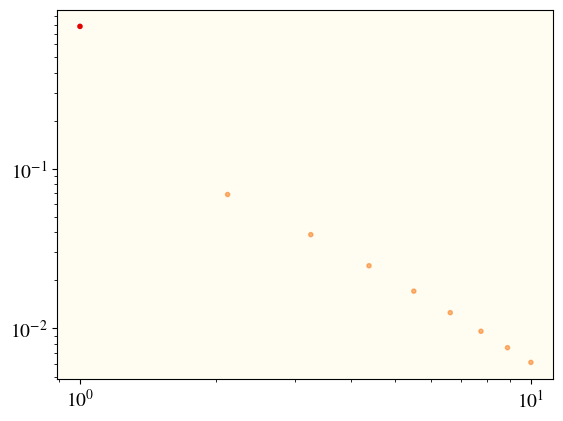

In [13]:
degrees = np.array([monomial.degree() for monomial in monomials[:int(locs[-1])]])
indices = np.linspace(1, int(locs[-1])+1, int(locs[-1]))
for degree in np.unique(degrees):
    idxs = np.where(np.array(degrees) == degree)[0]
    plt.scatter(indices[idxs], fra_eigvals[idxs].cpu(), color=colors[degree%7], linestyle='', marker='.', alpha=1/(degree+1),)
plt.yscale("log")
plt.xscale('log')

In [22]:
all_losses = np.ones((len(target_monomials), num_trials, max_iter))*max(loss_checkpoints)
pct_breakpoints = np.empty((len(target_monomials), len(percent_thresholds), num_trials))
pbar = tqdm(enumerate(target_monomials), total=len(target_monomials), desc="Processing items")

for idx, target_monomial in pbar:
    for trial in range(num_trials):
        model = MLP(d_in=dim, depth=2, d_out=1, width=width).to(device)
        _, losses, pct_breakpoint = train_network(model=model, lambdas=lambdas, Vt=Vt, monomial=target_monomial, dim=dim, bsz=bsz,
                                                  data_eigvals=data_eigvals, N=N, lr=lr, max_iter=max_iter,
                                                  percent_thresholds=percent_thresholds, gamma=gamma, ema_smoother=0.9)
        all_losses[idx, trial] = losses
        pct_breakpoints[idx, :, trial] = pct_breakpoint
    pbar.set_postfix(current_item=target_monomial, iteration=idx + 1)
    if not(idx%10) and idx!=0:
        fig, axes = plot_time_vs_error(all_losses, target_monomials, fra_eigvals, locs, plotindex=idx)
        fig.suptitle(f"Online μP MLP training on synth monomials averaged over {num_trials} runs, $\\gamma$ = {gamma}")
        plt.tight_layout(); plt.show()
        slope, intercept, xaxis = get_slope_and_intercept(fra_eigvals, locs, pct_breakpoints, breakindex = 1, trainindex = idx)
        plot_eigval_vs_traintime(slope, intercept, xaxis, fra_eigvals, locs, pct_breakpoints, target_monomials, breakindex = 1, trainindex = idx)
        plt.show()
        print(f"Breakpoints: {pct_breakpoints[:idx, 1, :].mean(axis=-1)}")

Processing items:   0%|          | 0/10 [00:00<?, ?it/s]

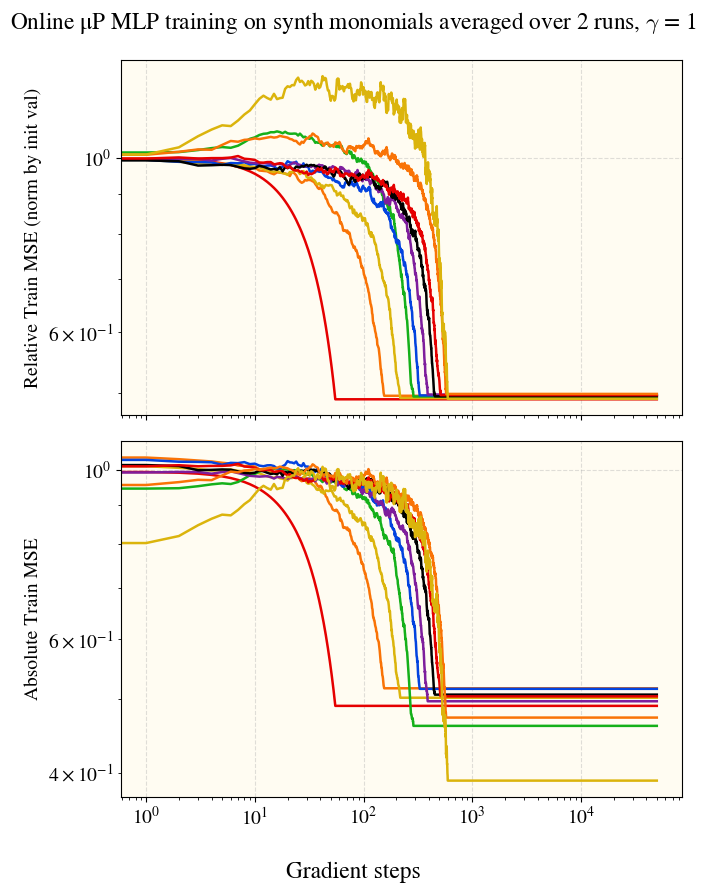

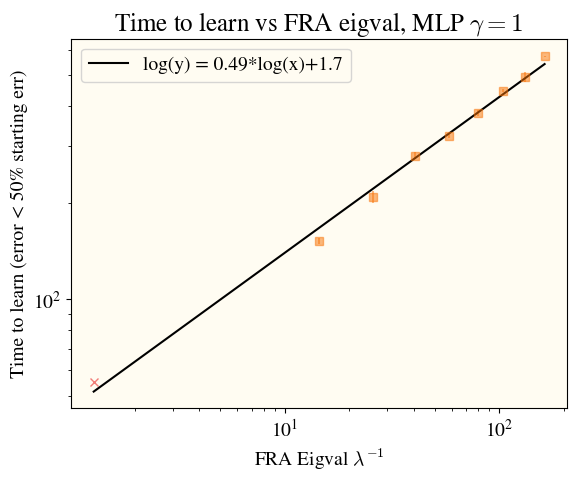

Breakpoints: [ 55.  152.  208.5 280.5 323.5 381.  447.5 494.  572.5]


In [17]:
fig, axes = plot_time_vs_error(all_losses, target_monomials, fra_eigvals, locs, plotindex=idx)
fig.suptitle(f"Online μP MLP training on synth monomials averaged over {num_trials} runs, $\\gamma$ = {gamma}")
plt.tight_layout(); plt.show()
slope, intercept, xaxis = get_slope_and_intercept(fra_eigvals, locs, pct_breakpoints, breakindex = 1, trainindex = idx)
plot_eigval_vs_traintime(slope, intercept, xaxis, fra_eigvals, locs, pct_breakpoints, target_monomials, breakindex = 1, trainindex = idx)
plt.show()
print(f"Breakpoints: {pct_breakpoints[:idx, 1, :].mean(axis=-1)}")

### testing new data gen

In [26]:
all_losses

array([[[1.1182847 , 1.10277927, 1.1072278 , ..., 0.54735869,
         0.54735869, 0.54735869],
        [0.92241007, 0.92963321, 0.93327027, ..., 0.45955277,
         0.45955277, 0.45955277],
        [0.90082133, 0.90995547, 0.92507569, ..., 0.44669178,
         0.44669178, 0.44669178],
        [1.02848196, 1.02100505, 1.02210209, ..., 0.51032804,
         0.51032804, 0.51032804],
        [1.02304995, 1.02173135, 1.03568279, ..., 0.50820383,
         0.50820383, 0.50820383]],

       [[0.5       , 0.5       , 0.5       , ..., 0.5       ,
         0.5       , 0.5       ],
        [0.5       , 0.5       , 0.5       , ..., 0.5       ,
         0.5       , 0.5       ],
        [0.5       , 0.5       , 0.5       , ..., 0.5       ,
         0.5       , 0.5       ],
        [0.5       , 0.5       , 0.5       , ..., 0.5       ,
         0.5       , 0.5       ],
        [0.5       , 0.5       , 0.5       , ..., 0.5       ,
         0.5       , 0.5       ]]])


Processing items:   0%|          | 0/10 [03:11<?, ?it/s]

Processing items:   0%|          | 0/20 [03:12<?, ?it/s, iteration=19]

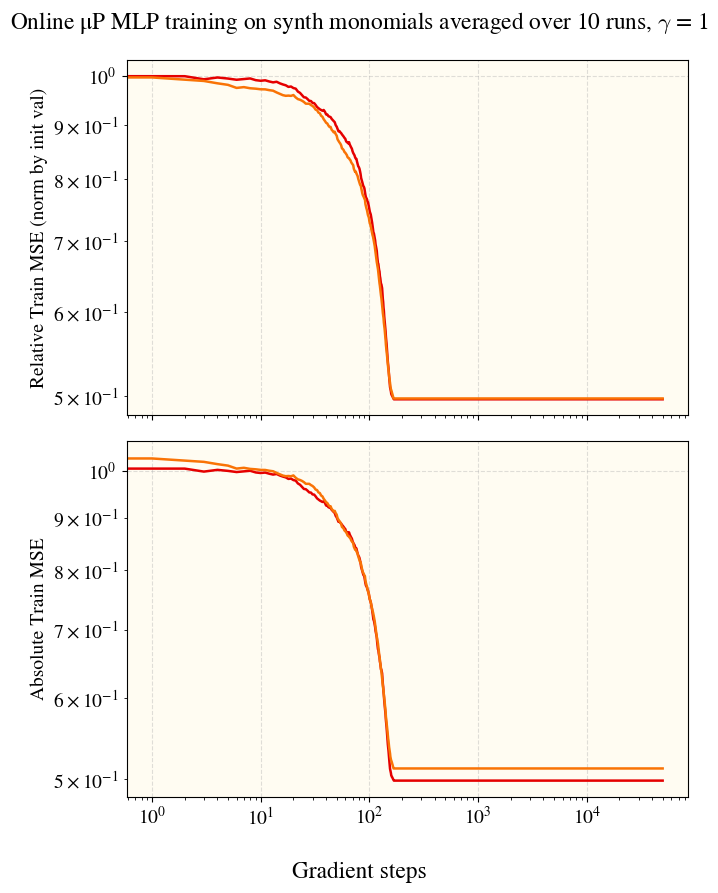

Breakpoints: [156.]


In [29]:
num_trials = 10
all_losses = np.ones((len([0, 1]), num_trials, max_iter))*max(loss_checkpoints)
pct_breakpoints = np.empty((len([0, 1]), len(percent_thresholds), num_trials))
pbar = tqdm(range(2*num_trials), total=2*num_trials, desc="Processing items")
target_monomial = Monomial({0:1})
idx = 1

for mode in ["new", "old"]:
    if mode == "new":
        ppp = 0
    else:
        ppp = 1
    for trial in range(num_trials):
        model = MLP(d_in=dim, depth=2, d_out=1, width=width).to(device)
        _, losses, pct_breakpoint = train_network(model=model, lambdas=lambdas, Vt=Vt, monomial=target_monomial, dim=dim, bsz=bsz,
                                                  data_eigvals=data_eigvals, N=N, lr=lr, max_iter=max_iter,
                                                  percent_thresholds=percent_thresholds, gamma=gamma, ema_smoother=0.9, mode=mode)
        all_losses[ppp, trial] = losses
        pct_breakpoints[ppp, :, trial] = pct_breakpoint
        pbar.set_postfix(iteration=(1+ppp)*trial + 1)

fig, axes = plot_time_vs_error(all_losses, target_monomials, fra_eigvals, locs, plotindex=1)
fig.suptitle(f"Online μP MLP training on synth monomials averaged over {num_trials} runs, $\\gamma$ = {gamma}")
plt.tight_layout(); plt.show()
slope, intercept, xaxis = get_slope_and_intercept(fra_eigvals, locs, pct_breakpoints, breakindex = 1, trainindex = idx)
# plot_eigval_vs_traintime(slope, intercept, xaxis, fra_eigvals, locs, pct_breakpoints, target_monomials, breakindex = 1, trainindex = idx)
# plt.show()
print(f"Breakpoints: {pct_breakpoints[:idx, 1, :].mean(axis=-1)}")

## grabbing data from earlier runs since runtime stopped

In [19]:
dim = 10
N = 10_000
offset=3
alpha=1.2
bsz = 512

X, y, locs, H, monomials, fra_eigvals, data_eigvals = get_all_targets(target_monomials=Monomial({}), dim=dim, N=N)
target_monomials = monomials[:40]
lr = 1e-2
width = 8192
gamma = 1

num_trials = 2
max_iter = int(5e4)
percent_thresholds = (0.75, 0.5)

X, y, locs, H, monomials, fra_eigvals, data_eigvals = get_all_targets(target_monomials=target_monomials, dim=dim, N=N)
U, lambdas, Vt = torch.linalg.svd(X, full_matrices=False)

Generating monomials: 100%|██████████| 10000/10000 [00:01<00:00, 8358.36step/s]


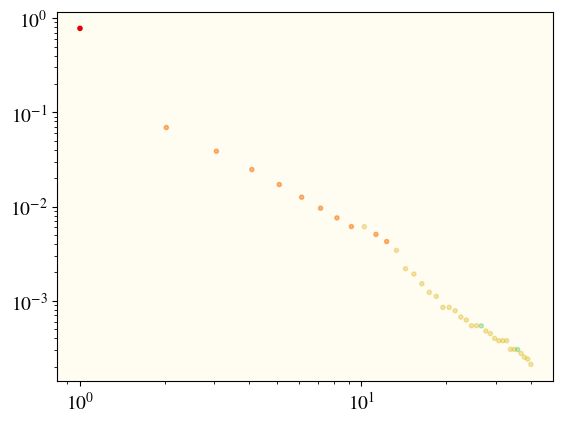

In [20]:
colors = ['xkcd:red', 'xkcd:orange', 'xkcd:gold', 'xkcd:green', 'xkcd:blue', "xkcd:purple", "xkcd:black"]
degrees = np.array([monomial.degree() for monomial in monomials[:int(locs[-1])]])
indices = np.linspace(1, int(locs[-1])+1, int(locs[-1]))
for degree in np.unique(degrees):
    idxs = np.where(np.array(degrees) == degree)[0]
    plt.scatter(indices[idxs], fra_eigvals[idxs].cpu(), color=colors[degree%7], linestyle='', marker='.', alpha=1/(degree+1),)
plt.yscale("log")
plt.xscale('log')

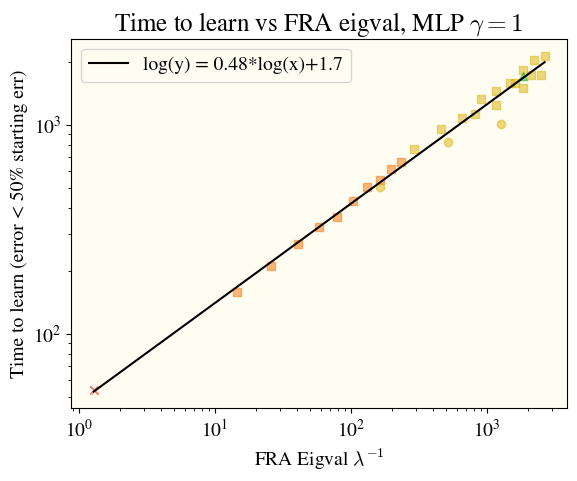

In [26]:
breakpoints_means = np.array([53.5, 159.,  212.,  268.,  322.5, 361.5, 432.,  505.5, 543.5, 504.5, 613.5, 665.,  767.,  959.5, 828.5, 1081.,
                     1128.5, 1324., 1457., 1251.5, 1005., 1582.5, 1586., 1827., 1499.5, 1717.5, 1741., 2050.5, 1742.5, 2147.5])
trainindex = 30

xaxis = (fra_eigvals[locs.long()][:trainindex].cpu())**(-1.)
ys = ensure_torch(breakpoints_means)[:trainindex]
slope, intercept = get_log_log_linear_fit(xaxis, ys)

plot_time_to_learn_eigenvalue(fra_eigvals[locs.long()][:trainindex].cpu(), ys.cpu(), target_monomials[:trainindex],
                                scale='log', breakpoint="(error < 50% starting err)", alpha=0.5, errorbar=False)
plt.plot(xaxis, 10**(intercept)*xaxis**(slope), color='k', label=f"log(y) = {slope:.2f}*log(x)+{intercept:.1f}")
plt.ylabel("Time to learn (error < 50% starting err)")
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.title(f"Time to learn vs FRA eigval, MLP $\\gamma ={gamma}$")
plt.show()

### without const mode

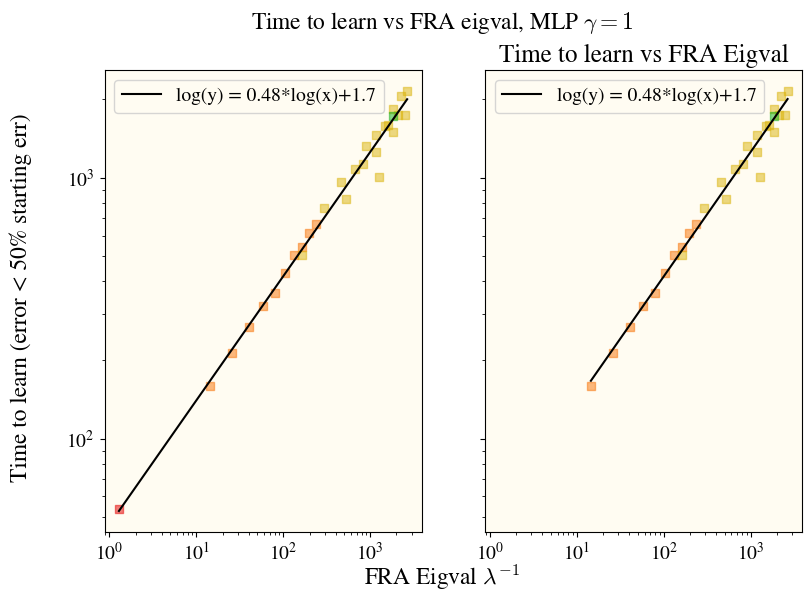

In [28]:
def plot_time_to_learn_eigenvalue_ax(ax, eigvals, timekeys, target_monomials, scale='log', **kwargs):
    degrees = np.array([target_monomial.degree() for target_monomial in target_monomials])
    colors = kwargs.get("colors", ['xkcd:red', 'xkcd:orange', 'xkcd:gold', 'xkcd:green', 'xkcd:blue', "xkcd:purple", "xkcd:black"])
    for degree in np.unique(degrees):
        idxs = np.where(np.array(degrees) == degree)[0]
        if kwargs.get("errorbar", False):
            ax.errorbar((eigvals[idxs])**(-1), timekeys[idxs], yerr=kwargs.get("yerr")[idxs], marker=kwargs.get("marker", None), color=colors[degree%7], alpha=kwargs.get("alpha", 1),
                         fmt='o')
        else:
            ax.scatter((eigvals[idxs])**(-1), timekeys[idxs], marker=kwargs.get("marker", None), color=colors[degree%7], alpha=kwargs.get("alpha", 1))
    ax.set_xscale(scale)
    ax.set_yscale(scale)
    # ax.set_xlabel(f"FRA Eigval $\\lambda^{{-1}}$")
    # ax.set_ylabel(f"Time to learn "+kwargs.get("breakpoint", ""))
    plt.title(f"Time to learn vs FRA Eigval")

breakpoints_means = np.array([53.5, 159.,  212.,  268.,  322.5, 361.5, 432.,  505.5, 543.5, 504.5, 613.5, 665.,  767.,  959.5, 828.5, 1081.,
                     1128.5, 1324., 1457., 1251.5, 1005., 1582.5, 1586., 1827., 1499.5, 1717.5, 1741., 2050.5, 1742.5, 2147.5])
trainindex = 30

fig, axes = plt.subplots(1, 2, figsize=(9,6), sharex=True, sharey=True)

xaxis = (fra_eigvals[locs.long()][:trainindex].cpu())**(-1.)
ys = ensure_torch(breakpoints_means)[:trainindex]
slope, intercept = get_log_log_linear_fit(xaxis, ys)

ax = axes[0]
plot_time_to_learn_eigenvalue_ax(ax, fra_eigvals[locs.long()][:trainindex].cpu(), ys.cpu(), target_monomials[:trainindex],
                                scale='log', breakpoint="(error < 50% starting err)", marker='s', alpha=0.5, errorbar=False)
ax.plot(xaxis, 10**(intercept)*xaxis**(slope), color='k', label=f"log(y) = {slope:.2f}*log(x)+{intercept:.1f}")
ax.legend()

xaxis = (fra_eigvals[locs.long()][1:trainindex].cpu())**(-1.)
ys = ensure_torch(breakpoints_means)[1:trainindex]
slope, intercept = get_log_log_linear_fit(xaxis, ys)

ax = axes[1]
plot_time_to_learn_eigenvalue_ax(ax, fra_eigvals[locs.long()][1:trainindex].cpu(), ys.cpu(), target_monomials[1:trainindex],
                                scale='log', breakpoint="(error < 50% starting err)", marker='s', alpha=0.5, errorbar=False)
ax.plot(xaxis, 10**(intercept)*xaxis**(slope), color='k', label=f"log(y) = {slope:.2f}*log(x)+{intercept:.1f}")
fig.supylabel("Time to learn (error < 50% starting err)")
# ax.set_xscale('log')
# ax.yscale('log')
ax.legend()
fig.suptitle(f"Time to learn vs FRA eigval, MLP $\\gamma ={gamma}$")
fig.supxlabel(f"FRA Eigval $\\lambda^{{-1}}$")
plt.show()

tensor([1.2840e+00, 1.4497e+01, 2.5847e+01, 4.0476e+01, 5.8392e+01, 7.9600e+01,
        1.0411e+02, 1.3191e+02, 1.6303e+02, 1.6368e+02, 1.9745e+02, 2.3519e+02,
        2.9182e+02, 4.5698e+02, 5.2028e+02, 6.5926e+02, 8.1476e+02, 8.9871e+02,
        1.1754e+03, 1.1754e+03, 1.2759e+03, 1.4894e+03, 1.6023e+03, 1.8407e+03,
        1.8407e+03, 1.8480e+03, 2.0956e+03, 2.2293e+03, 2.5092e+03, 2.6554e+03])
tensor([  14.4970,   25.8468,   40.4758,   58.3915,   79.6000,  104.1062,
         131.9147,  163.0294,  163.6762,  197.4537,  235.1907,  291.8183,
         456.9846,  520.2827,  659.2587,  814.7578,  898.7086, 1175.3920,
        1175.3922, 1275.9028, 1489.3586, 1602.3073, 1840.6528, 1840.6528,
        1847.9557, 2095.6060, 2229.3137, 2509.1978, 2655.3767])


Text(0.5, 1.0, 'Time to learn vs FRA eigval, MLP $\\gamma =1$')

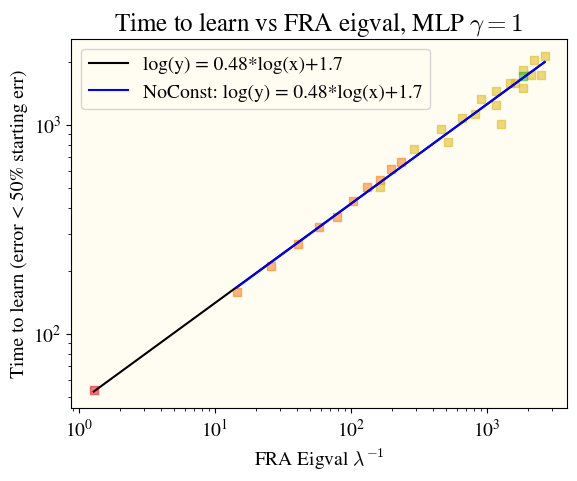

In [29]:
breakpoints_means = np.array([53.5, 159.,  212.,  268.,  322.5, 361.5, 432.,  505.5, 543.5, 504.5, 613.5, 665.,  767.,  959.5, 828.5, 1081.,
                     1128.5, 1324., 1457., 1251.5, 1005., 1582.5, 1586., 1827., 1499.5, 1717.5, 1741., 2050.5, 1742.5, 2147.5])
trainindex = 30

xaxis = (fra_eigvals[locs.long()][:trainindex].cpu())**(-1.)
ys = ensure_torch(breakpoints_means)[:trainindex]
slope, intercept = get_log_log_linear_fit(xaxis, ys)

plot_time_to_learn_eigenvalue(fra_eigvals[locs.long()][:trainindex].cpu(), ys.cpu(), target_monomials[:trainindex],
                                scale='log', breakpoint="(error < 50% starting err)", marker='s', alpha=0.5, errorbar=False)
plt.plot(xaxis, 10**(intercept)*xaxis**(slope), color='k', label=f"log(y) = {slope:.2f}*log(x)+{intercept:.1f}")
xaxis = (fra_eigvals[locs.long()][1:trainindex].cpu())**(-1.)
ys = ensure_torch(breakpoints_means)[1:trainindex]
slope, intercept = get_log_log_linear_fit(xaxis, ys)
plt.plot(xaxis, 10**(intercept)*xaxis**(slope), color='b', label=f"NoConst: log(y) = {slope:.2f}*log(x)+{intercept:.1f}")
plt.ylabel("Time to learn (error < 50% starting err)")
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.title(f"Time to learn vs FRA eigval, MLP $\\gamma ={gamma}$")

## stuff with n_pred vs n_emp

In [58]:
dim = 3072
ns = np.logspace(0, 3.3, 10, dtype=int)
# N = max(ns)
N = 5_000
offset=3
alpha=1.2
bsz = 512
cutoff_mode = 40_000
kerneltype = GaussianKernel
normalized = True

X, y, locs, H, monomials, fra_eigvals, data_eigvals = get_all_targets(target_monomials=Monomial({}), dim=dim, N=N, offset=offset,
                                                                      alpha=alpha, cutoff_mode=cutoff_mode, kerneltype=kerneltype,
                                                                      normalized=normalized)
target_monomials = [Monomial({10: 1}), Monomial({190:1}), Monomial({0:2}), Monomial({2:1, 3:1}), Monomial({15:1, 20:1}), Monomial({0:3})]
X_full, y_full, locs, H, monomials, fra_eigvals, data_eigvals = get_all_targets(target_monomials=target_monomials, dim=dim, N=N, offset=offset,
                                                                      alpha=alpha, cutoff_mode=cutoff_mode, kerneltype=kerneltype,
                                                                      normalized=normalized)
lr = 1e-2
width = 8192
gamma = 1

colors = ['xkcd:red', 'xkcd:orange', 'xkcd:gold', 'xkcd:green', 'xkcd:blue', "xkcd:purple", "xkcd:black"]
markers = ['x', 's', 'o', '^', 'D', '*', 'v', 'p', 'h']

loss_checkpoints = (5e-1, 2e-2)
percent_thresholds = (0.75, 0.01)
U, lambdas, Vt = torch.linalg.svd(X_full, full_matrices=False)

max_iter = int(1e4)
min_iter = int(1e2)
window = 60
eval_every = 10
patience = 2
slope_eps = 8e-5
rel_improve_eps = 8e-2
ema_smoother = 0.9
use_log_time = True
stopper = PlateauStopper(min_iter=min_iter, window=window, eval_every=eval_every, patience=patience, slope_eps=slope_eps,
                                     rel_improve_eps=rel_improve_eps, ema_smoother=ema_smoother, use_log_time=use_log_time)

Generating monomials: 100%|██████████| 10000/10000 [00:00<00:00, 22564.46step/s]


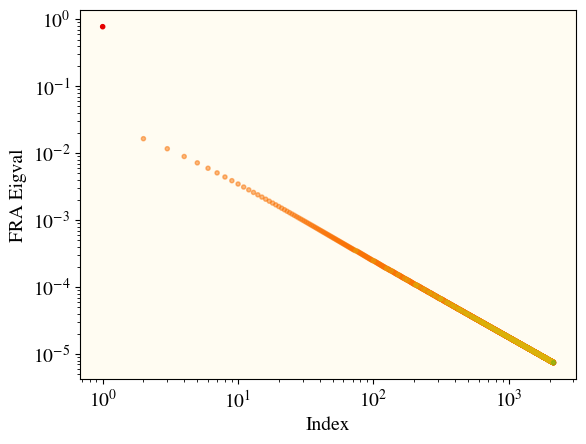

In [59]:
degrees = np.array([monomial.degree() for monomial in monomials[:1+int(locs[-1])]])
indices = np.linspace(1, int(locs[-1])+1, 1+int(locs[-1]))
for degree in np.unique(degrees):
    idxs = np.where(np.array(degrees) == degree)[0]
    plt.scatter(indices[idxs], fra_eigvals[idxs].cpu(), color=colors[degree%7], linestyle='', marker='.', alpha=1/(degree+1),)
plt.yscale("log")
plt.xscale('log')
plt.xlabel("Index")
plt.ylabel("FRA Eigval")
plt.show()

In [60]:
def trial_count_fn(n):
    # if n <= 10:
    #     return 30
    if n <= 50:
        return 20
    elif n <= 500:
        return 10
    elif n <= 5000:
        return 3
    else:
        return 1

trial_counts = np.array([trial_count_fn(n) for n in ns], dtype=int)
max_trials   = int(trial_counts.max())

all_losses = np.full((len(ns), len(target_monomials), max_trials, max_iter), np.nan, dtype=float)
# final_losses = np.full((len(ns), len(target_monomials), max_trials), np.nan, dtype=float)
pct_breakpoints = np.full((len(ns), len(target_monomials), len(percent_thresholds), max_trials), np.nan, dtype=float)

total_iters = int(len(target_monomials) * trial_counts.sum())
pbar = tqdm(total=total_iters, desc="Processing items")

Processing items:   0%|          | 0/816 [00:31<?, ?it/s]


In [ ]:
import gc

for idx, target_monomial in enumerate(target_monomials):
    for nidx, n in enumerate(ns):
        num_trials_n = int(trial_counts[nidx])

        for trial in range(num_trials_n):
            pbar.set_postfix(
                current_item=f"Mon:{target_monomial} n:{n} trial:{trial+1}/{num_trials_n}",
                refresh=False
            )
            X, y = get_new_data(lambdas, Vt, target_monomial, dim, n, data_eigvals, N)
            model = MLP(d_in=dim, depth=2, d_out=1, width=width).to(device)

            outdict = train_network(model=model, lambdas=lambdas, Vt=Vt, monomial=target_monomial, dim=dim, bsz=bsz,
                                    data_eigvals=data_eigvals, N=N, lr=lr, max_iter=max_iter, percent_thresholds=percent_thresholds,
                                    gamma=gamma, ema_smoother=ema_smoother, fixed_X=X, fixed_y=y, stopper=stopper)

            # final_losses[nidx, idx, trial] = outdict["test_losses"][-1]
            all_losses[nidx, idx, trial] = outdict["test_losses"]
            pct_breakpoints[nidx, idx, :, trial] = outdict["timekeys"]

            del outdict, model, X, y
            gc.collect()
            stopper.reset()

            pbar.update(1)

        # term_losses = all_losses[nidx, idx]
        # loss_mean = np.nanmean(term_losses, axis=0)
        # loss_std  = np.nanstd(term_losses, axis=0, ddof=1)
        # ec = mcolors.to_rgba(colors[target_monomial.degree()%7], 0.15)


        # plt.errorbar(np.arange(1, max_iter+1, 1), loss_mean, yerr=loss_std, fmt=markers[target_monomial.max_degree()%len(markers)],
        #              color=colors[target_monomial.degree()%7], label=f"n={n}", ecolor=ec)#, color=colors[degree%7], alpha=kwargs.get("alpha", 1), fmt=md2marker[md])

        # plt.title(f"MLP Learning Monomial {target_monomials[idx]} from fixed n")
        # plt.xlabel("Timestep")
        # plt.ylabel(f"Test Error")
        # plt.xscale("log")
        # plt.legend()
        # plt.show()
pbar.close()

Processing items:   4%|▍         | 32/816 [1:19:48<32:44:10, 150.32s/it, current_item=Mon:$x_{10}$ n:2 trial:12/20]

In [ ]:
np.save("losses", all_losses)

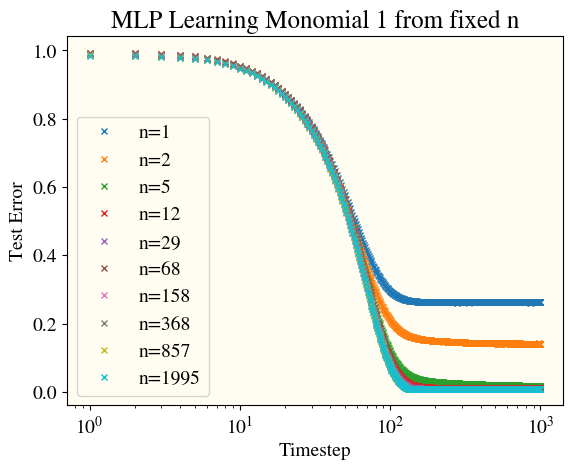

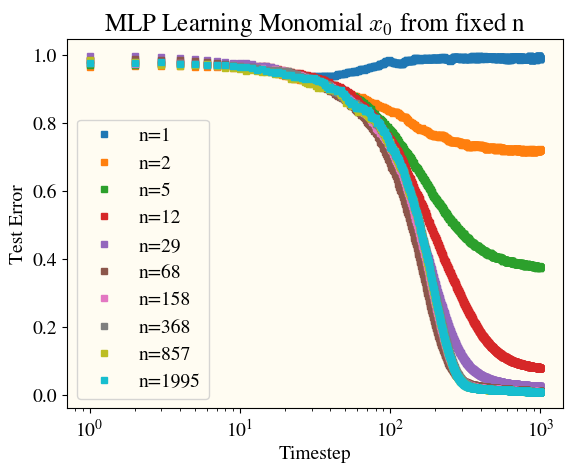

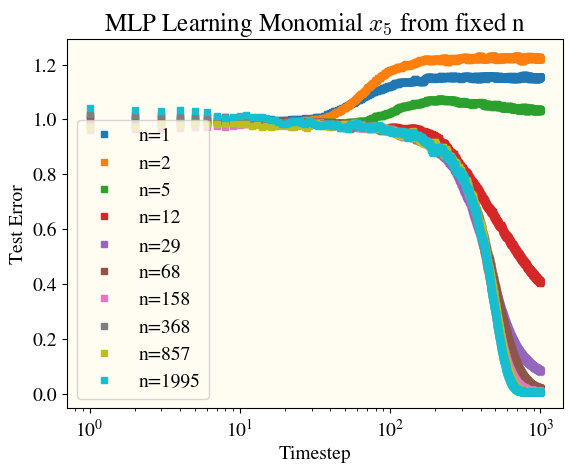

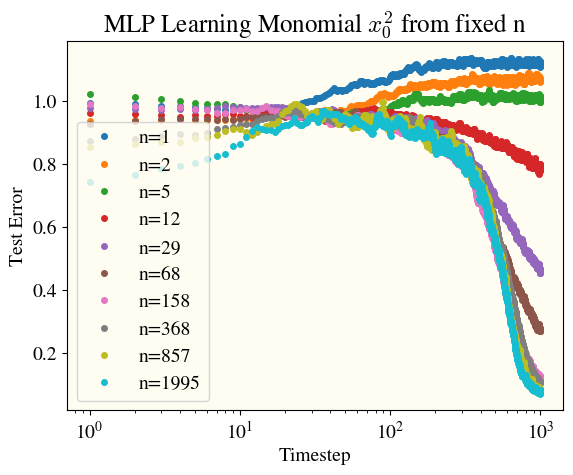

In [ ]:
for term in range(len(target_monomials)):
    target_monomial = target_monomials[term]
    for i in range(len(all_losses)):
        term_losses = all_losses[i, term]
        loss_mean = np.nanmean(term_losses, axis=0)
        loss_std  = np.nanstd(term_losses, axis=0, ddof=1)
        ec = mcolors.to_rgba(colors[target_monomial.degree()%7], 0.15)
        plt.errorbar(np.arange(1, max_iter+1, 1), loss_mean, fmt=markers[target_monomial.max_degree()%len(markers)], label=f"n={ns[i]}", ms=4, yerr=None)#, yerr=loss_std, ecolor=ec)#, color=colors[degree%7], alpha=kwargs.get("alpha", 1), fmt=md2marker[md])
    plt.title(f"MLP Learning Monomial {target_monomials[term]} from fixed n")
    plt.xlabel("Timestep")
    plt.ylabel(f"Test Error")
    plt.xscale("log")
    plt.legend()
    plt.show()

In [1]:
use_ots_correction = False
from eigenlearning import eigenlearning

ns_dense = np.logspace(0, 4, 100, dtype=int)

for idx, target_monomial in enumerate(target_monomials):
    eigvals = fra_eigvals
    coeffs = np.zeros_like(eigvals.cpu())
    coeffs[int(locs[idx])] = 1.0

    fra_ridge = max(0, 1 - eigvals.sum())
    el_fra = lambda n: eigenlearning(n, eigvals.cpu().numpy(), coeffs, ridge=fra_ridge)
    mse_el_fra = np.array([el_fra(n)["test_mse"] for n in ns_dense])

    if use_ots_correction:
        train_mse = np.array([el_fra(n)["train_mse"] for n in ns_dense])
        mse_el_fra = (N*mse_el_fra - train_mse*ns) / (N - ns_dense)
    
    plt.plot(ns, mse_el_fra,
             color=colors[target_monomial.degree()%7], lw=2)

for term, target_monomial in enumerate(target_monomials):
    term_losses = all_losses[:, term]
    loss_mean = np.nanmean(term_losses, axis=1)
    loss_std  = np.nanstd(term_losses, axis=1, ddof=1)
    plt.errorbar(ns, loss_mean[:, -1], label=target_monomial, fmt=markers[target_monomial.max_degree()%len(markers)],
                color=colors[term%7],
                yerr=loss_std[:, -1], alpha=0.7)
# plt.scatter(ns, all_losses[:, 1, :, -1].mean(axis=-1), label=target_monomials[1])
plt.xscale("log")
plt.xlabel("n")
plt.ylabel(f"(ema .9) Test Loss at {max_iter}")
plt.legend()
plt.title("MLP Num train samples vs final test error")
plt.show()

ModuleNotFoundError: No module named 'eigenlearning'

# what affects the slope

### testing slopes against different gamma factors

In [ ]:
import matplotlib.colors as mcolors
colors = ['xkcd:red', 'xkcd:orange', 'xkcd:gold', 'xkcd:green', 'xkcd:blue', "xkcd:purple", "xkcd:black"]

def lighten(color, amount=0.5):
    rgb = mcolors.to_rgb(mcolors.XKCD_COLORS.get(color, color))
    if amount >= 0:
        new_rgb = tuple(c + (1 - c) * amount for c in rgb)
    else:
        new_rgb = tuple(c * (1 + amount) for c in rgb)
    # Clip values to [0, 1]
    new_rgb = tuple(min(max(x, 0), 1) for x in new_rgb)
    return new_rgb

# scratch

### old training regimine

In [ ]:
import math

def get_new_hermites(X_pca, monomials):
    N = len(X_pca)

    hermites = {
        1: lambda x: x,
        2: lambda x: x**2 - 1,
        3: lambda x: x**3 - 3*x,
        4: lambda x: x**4 - 6*x**2 + 3,
        5: lambda x: x**5 - 10*x**3 + 15*x,
        6: lambda x: x**6 - 15*x**4 + 45*x**2 - 15,
        7: lambda x: x**7 - 21*x**5 + 105*x**3 - 105*x,
        8: lambda x: x**8 - 28*x**6 + 210*x**4 - 420*x**2 + 105,
        9: lambda x: x**9 - 36*x**7 + 378*x**5 - 1260*x**3 + 945*x,
        10: lambda x: x**10 - 45*x**8 + 630*x**6 - 3150*x**4 + 4725*x**2 - 945,
    }
    if type(monomials) != list:
        monomials = [monomials]
    H = ensure_torch(torch.zeros((N, len(monomials))))
    for i, monomial in enumerate(monomials):
        h = ensure_torch(torch.ones(N) / np.sqrt(N))
        for d_i, exp in monomial.items():
            Z = np.sqrt(math.factorial(exp))
            h *= hermites[exp](X_pca[:, d_i]) / Z
        H[:, i] = h
    return H

In [ ]:
def train_network_online(
    lambdas, Vt, monomial, dim, bsz, data_eigvals, N, lr, max_iter=int(1e3), loss_checkpoints=None,
    percent_thresholds=None, gamma=1., ema_smoother=0.0, **kwargs):
    """
    Returns:
        model, losses, timekeys

    - timekeys[j]: first gradient step where the loss drops below the j-th threshold.
    - If RELATIVE mode, thresholds are `percent_thresholds * init_loss`.
    - If ABSOLUTE mode, thresholds are raw absolutes and the comparison metric is raw loss.
    """
    has_abs = (loss_checkpoints is not None) and len(loss_checkpoints) > 0
    is_relative = (percent_thresholds is not None) and len(percent_thresholds) > 0
    if has_abs and is_relative:
        raise ValueError("Provide exactly one of loss_checkpoints OR percent_thresholds.")
    if not has_abs and not is_relative:
        raise ValueError("You must provide one of loss_checkpoints or percent_thresholds.")

    # model stuff
    model = MLP(d_in=dim, depth=2, d_out=1, width=width).to(device)
    lr = lr * gamma if gamma >= 1 else lr * (gamma**2.)
    opt = torch.optim.SGD(model.parameters(), lr=lr)
    mupify(model, opt, param="mup")
    rescale(model, gamma)
    loss_fn = torch.nn.MSELoss()

    # thresholding
    thresholds = np.asarray(percent_thresholds if is_relative else loss_checkpoints, dtype=float)
    thresholds = np.sort(thresholds)[::-1]               # descending
    timekeys = np.full(thresholds.shape, max_iter, dtype=int)

    losses = np.empty(max_iter, dtype=float)
    ema = None
    pointer = 0

    # --- training loop ---
    for i in range(max_iter):
        with torch.no_grad():
            X_new, y_new = get_new_data(lambdas, Vt, monomial, dim, bsz, data_eigvals, N)
        X_new, y_new = map(ensure_torch, (X_new, y_new))

        opt.zero_grad()
        out = model(X_new)
        loss = loss_fn(out, y_new)
        print(loss, y_new.shape, X_new.shape)
        loss.backward()
        opt.step()

        loss_val = float(loss.item())

        # initialize thresholds & loss trace baseline at first step
        if i == 0:
            ema = loss_val
            if is_relative:
                thresholds *= loss_val
            #prefill losses after init val calculated
            losses[:] = loss_val

        ema = (ema_smoother * ema + (1.0 - ema_smoother) * loss_val)
        losses[i] = ema

        while pointer < len(thresholds) and losses[i] < thresholds[pointer]:
            timekeys[pointer] = i
            losses[i:] = losses[i]
            pointer += 1

        # early exit if all thresholds crossed
        if pointer == len(thresholds):
            return model, losses, timekeys

    return model, losses, timekeys

In [ ]:
def train_network_online(lambdas, Vt, monomial, dim, bsz, data_eigvals, N, lr, max_iter=int(1e3), max_loss=1e-3, **kwargs):
    model = MLP(d_in=dim, depth=2, d_out=1, width=width).to(device)
    opt    = torch.optim.SGD(model.parameters(), lr=lr)
    mupify(model, opt, param="mup")
    loss_fn = torch.nn.MSELoss()

    losses = np.ones(max_iter)*max_loss

    for i in range(max_iter):
        with torch.no_grad():
            X_new, y_new = get_new_data(lambdas, Vt, monomial,
                                        dim, bsz,
                                        data_eigvals, N)
        X_new, y_new = X_new.to(device), y_new.to(device)

        opt.zero_grad()
        loss = loss_fn(model(X_new), y_new)
        loss.backward()
        opt.step()

        loss_val = loss.item()
        if kwargs.get("ema_smoothing", False):
            ema = loss_val if i == 0 else kwargs.get("ema_smoother", 0.98) * ema + (1 - kwargs.get("ema_smoother", 0.98)) * loss_val
            losses[i] = ema
        else:
            losses[i] = loss_val
        if loss_val < max_loss:
            return model, losses, i
    return model, losses, i

In [ ]:
def train_network_online_minibatch_new(monomial, color, steps=int(1e3), ema_smoother: float = 0.98, label_raw: bool = False):
    net = MLP(d_in=dim, depth=2, d_out=1, width=width).to(device)
    opt    = torch.optim.SGD(net.parameters(), lr=lr)
    mupify(net, opt, param="mup")
    loss_fn = torch.nn.MSELoss()

    raw_losses, ema_losses = [], []
    ema = None                            # initialise on first step

    for _ in range(steps):
        # ── generate a fresh mini-batch ──────────────────
        with torch.no_grad():                # no autograd for data gen
            X_new, H_new = get_new_data(lambdas, Vt, monomial,
                                        dim, bsz, None, None,
                                        data_eigvals, N)
        X_new, H_new = X_new.to(device), H_new.to(device)

        # ── SGD step ─────────────────────────────────────
        opt.zero_grad()
        # loss = ((net(X_new) - H_new)**2).mean()
        loss = loss_fn(net(X_new), H_new)
        loss.backward()
        opt.step()
        # losses.append(loss.item())

        loss_val = loss.item()
        ema = loss_val if ema is None else ema_smoother * ema + (1 - ema_smoother) * loss_val
        raw_losses.append(loss_val)
        ema_losses.append(ema)

    # -------- plotting --------------------
    if label_raw:
        plt.plot(raw_losses, ls=':', label=f'Monomial {monomial}', lw=0.7, alpha=0.4, color=color)

    plt.plot(ema_losses, label=f'Monomial {monomial}', color=color, lw=1.8)


In [ ]:
dim = 10
N = 10_000
train_percent = 0.8
bsz = 64

X, y, H, monomials, fra_eigvals, v_true = get_synthetic_dataset(ytype="PowerLaw", d=dim, N=N, offset=3, alpha=1.5, cutoff_mode=500,
                          noise_size=0.01, normalized=True, vi0=1, beta=1.01)
U, lambdas, Vt = torch.linalg.svd(X, full_matrices=False)

X_train, y_train = X[:int(train_percent*N)], y[:int(train_percent*N)]
X_test, y_test = X[int(train_percent*N):], y[int(train_percent*N):]

X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_train, y_train, X_test, y_test = [torch.Tensor(d).cuda() for d in (X_train, y_train, X_test, y_test)]

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=bsz, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=bsz, shuffle=False)

In [ ]:
#error somewhere in here
def train_network_online_minibatch(model, lambdas, Vt, monomial, offset, alpha, data_eigvals, lr=1e0, bsz=32, max_loss=1e-3, max_iter=10_000, N_original=10_000, **kwargs):
    losses = np.ones(max_iter)*max_loss
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    mupify(model, optimizer, param="mup")
    loss_fn = torch.nn.MSELoss()

    X_new, H_new = get_new_data(lambdas, Vt, monomial, dim, bsz, offset, alpha, data_eigvals, N_original)
    X_new, H_new = ensure_torch(X_new), ensure_torch(H_new)
    pred = model(ensure_torch(X_new))

    model.train()
    loss = loss_fn(pred, H_new)
    litem = loss.item()
    i=0
    losses[i] = loss.item()
    while litem > max_loss:
        i = i+1
        X_new, H_new = get_new_data(lambdas, Vt, monomial, dim, bsz, offset, alpha, data_eigvals, N_original)
        X_new, H_new = ensure_torch(X_new), ensure_torch(H_new)

        optimizer.zero_grad()
        pred = model(X_new)
        loss = loss_fn(pred, H_new)
        loss.backward()
        optimizer.step()

        # if (i // bsz + 1) % 100 == 0:
            # print(f"Step {i // bsz + 1}: Loss = {loss.item():.4f}")
        losses[i] = loss.item()
        litem = loss.item()
        if i >= max_iter:
            return model, losses, max_iter
    return model, losses, i

In [ ]:
## don't need train/test atm since everything is online
X_train, y_train = X[:int(train_percent*N)], y[:int(train_percent*N), :]
X_test, y_test = X[int(train_percent*N):], y[int(train_percent*N):, :]

X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_train, y_train, X_test, y_test = [torch.Tensor(d).cuda() for d in (X_train, y_train, X_test, y_test)]

# train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=bsz, shuffle=True)
# test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=bsz, shuffle=False)

In [ ]:
U.shape, Vt.shape
(X @ Vt.T @ torch.diag(lambdas**(-1.))), H[:, np.where([monomial.degree() == 1 for monomial in monomials])[0]].cpu()#/(U)
#np.allclose(H[:, np.where([monomial.degree() == 1 for monomial in monomials])[0]].cpu(), U.cpu())

(tensor([[-6.6634e-03, -2.8928e-04,  2.4606e-03,  ...,  4.7317e-03,
           7.9509e-03, -8.9848e-03],
         [ 4.9882e-03, -1.3617e-03,  1.8039e-02,  ...,  1.6977e-02,
           1.4127e-02,  1.6172e-02],
         [-2.1759e-03, -4.6086e-03, -8.7484e-03,  ..., -1.9475e-03,
           5.6960e-03, -1.3148e-02],
         ...,
         [ 1.9370e-03, -1.0337e-02,  6.7557e-03,  ..., -1.1038e-02,
          -2.5259e-02,  3.7007e-03],
         [-2.5281e-04,  2.5016e-02, -3.9720e-02,  ...,  1.6772e-03,
           2.2838e-03,  8.5490e-03],
         [ 7.8996e-03,  8.4276e-03, -1.1299e-02,  ..., -9.2043e-03,
           1.6577e-05, -1.5671e-02]], device='cuda:0'),
 tensor([[-6.6634e-03, -2.8928e-04,  2.4606e-03,  ...,  4.7317e-03,
           7.9509e-03, -8.9848e-03],
         [ 4.9882e-03, -1.3617e-03,  1.8039e-02,  ...,  1.6977e-02,
           1.4127e-02,  1.6172e-02],
         [-2.1759e-03, -4.6086e-03, -8.7484e-03,  ..., -1.9475e-03,
           5.6959e-03, -1.3148e-02],
         ...,
        

### chatgpt code to test if the anisotropic data can be learned at different time scales or if im losing my mind

0
100


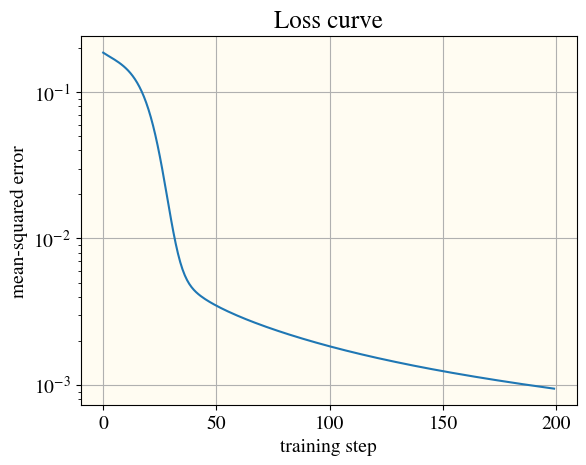

0
100


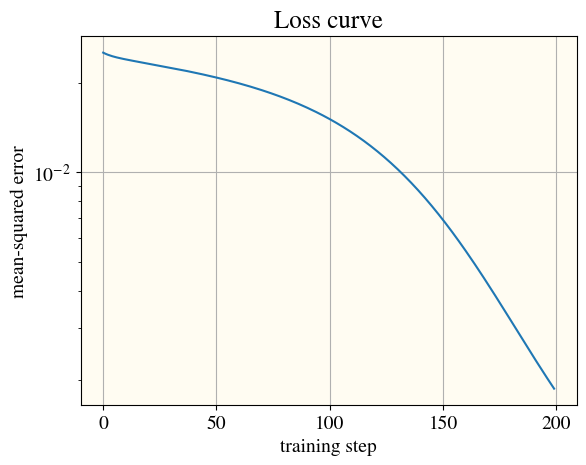

In [ ]:
import torch, torch.nn as nn
from torch.optim import SGD
N, d, width = 50_000, 32, 64          # plenty of samples, big width
gamma = torch.exp(-0.2*torch.arange(d))  # γ₀>γ₁>…
gamma /= gamma.sum()                    # Σ γ=1
Σ = torch.diag(gamma)
X = (torch.randn(N, d) @ Σ.sqrt()).to(device)        # X ~ N(0, Γ)

targets = [0, 10]
for j in targets:
    y = X[:, j:j+1]                     # one-hot target
    net = StandardMLP(d_in=d, depth=2, d_out=1, width=width).to(device)       # your μP-scaled module
    opt = SGD(net.parameters(), lr=5e-1)  # μP LR
    mupify(net, opt, param="mup")
    losses = []
    for t in range(200):
        opt.zero_grad()
        loss = ((net(X) - y) ** 2).mean()
        loss.backward(); opt.step()
        losses.append(loss.item())
        if not(t%100):
            print(t)
    plt.plot(losses)        # draw a line connecting successive loss values
    plt.yscale('log')       # (optional) log-scale makes exponential decay straight
    plt.xlabel('training step')
    plt.ylabel('mean-squared error')
    plt.title('Loss curve')
    plt.grid(True)
    plt.show()


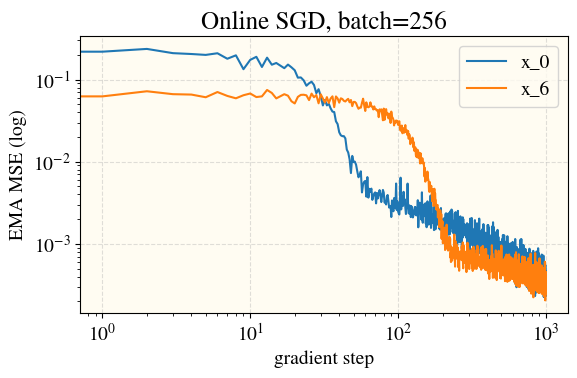

In [ ]:
# quick_verif_online.py
import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from functools import partial
torch.manual_seed(0)

# ---------- hyper-parameters ----------
N, d          = 16_384, 8          # samples, dimension
width         = 128              # hidden width (same for both layers)
batch_size    = 256               # <-- fixed mini-batch size
steps         = 1000              # total gradient steps (≃ epochs*N/B)
ema_beta      = 0.98              # smoothing for the loss curve
# lr_muP        = 1e-3 * width      # μP: lr ∝ width on first layer
targets       = [0, 10]           # which coords to learn
# device        = 'cuda' if torch.cuda.is_available() else 'cpu'

# ---------- input covariance Γ ----------
gamma = torch.exp(-0.2*torch.arange(d))   # γ0>γ1>…
gamma /= gamma.sum()
Σsqrt = torch.diag(gamma.sqrt())

# ---------- dataset ----------
X = torch.randn(N, d) @ Σsqrt                   # N(0, Γ)
def make_loader(coord):
    y = X[:, coord:coord+1]
    ds = TensorDataset(X, y)
    return DataLoader(ds, batch_size=batch_size, shuffle=True, drop_last=True)

# # ---------- μP-scaled 2-HL MLP ----------
# class TwoHL_MLP_muP(nn.Module):
#     def __init__(self, d_in, width):
#         super().__init__()
#         self.fc1 = nn.Linear(d_in, width, bias=False)
#         self.fc2 = nn.Linear(width, width, bias=False)
#         self.fc3 = nn.Linear(width, 1,    bias=False)
#         # μP init:  W^(ℓ) ~ N(0, 1/width) except last layer
#         for m in (self.fc1, self.fc2):
#             nn.init.normal_(m.weight, 0., 1./width**0.5)
#         nn.init.normal_(self.fc3.weight, 0., 1.)   # projector layer
#         self.relu = nn.ReLU()
#     def forward(self, x):
#         h1 = self.relu(self.fc1(x))
#         h2 = self.relu(self.fc2(h1))
#         return self.fc3(h2)

# ---------- training loop ----------
def train_one_target(coord, color):
    loader = make_loader(coord)
    net = StandardMLP(d_in=d, depth=2, d_out=1, width=width).to(device)
    opt    = torch.optim.SGD(net.parameters(), lr=1e-1)
    mupify(net, opt, param="mup")

    ema, losses = 0., []
    itr_loader = iter(loader)   # fresh iterator

    for step in range(steps):
        try:
            xb, yb = next(itr_loader)
        except StopIteration:          # epoch finished → restart iterator
            itr_loader = iter(loader)
            xb, yb = next(itr_loader)

        xb, yb = xb.to(device), yb.to(device)

        opt.zero_grad()
        loss = ((net(xb) - yb)**2).mean()
        loss.backward(); opt.step()

        losses.append(loss.item())

    plt.plot(losses, label=f"x_{coord}", color=color)

# ---------- run & plot ----------
plt.figure(figsize=(6,4))
train_one_target(0 , color="tab:blue")
train_one_target(6, color="tab:orange")
plt.yscale('log'); plt.grid(True, ls='--', alpha=.4)
plt.xlabel("gradient step"); plt.ylabel("MSE (log)")
plt.title(f"Online SGD, batch={batch_size}")
plt.xscale('log')
plt.legend(); plt.tight_layout(); plt.show()


In [ ]:
# quick_verif_online.py
import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
# torch.manual_seed(0)

steps         = 1000              # total gradient steps (≃ epochs*N/B)

def make_loader(coord):
    y = X[:, coord:coord+1]
    ds = TensorDataset(X, y)
    return DataLoader(ds, batch_size=batch_size, shuffle=True, drop_last=True)


# ---------- training loop ----------
def train_one_target(coord, color):
    loader = make_loader(coord)
    net = StandardMLP(d_in=d, depth=2, d_out=1, width=width).to(device)
    opt    = torch.optim.SGD(net.parameters(), lr=1e-1)
    mupify(net, opt, param="mup")

    losses = []
    itr_loader = iter(loader)   # fresh iterator

    for step in range(steps):
        try:
            xb, yb = next(itr_loader)
        except StopIteration:          # epoch finished → restart iterator
            itr_loader = iter(loader)
            xb, yb = next(itr_loader)

        xb, yb = xb.to(device), yb.to(device)

        opt.zero_grad()
        loss = ((net(xb) - yb)**2).mean()
        loss.backward(); opt.step()

        losses.append(loss.item())

    plt.plot(losses, label=f"x_{coord}", color=color)

# ---------- run & plot ----------
plt.figure(figsize=(6,4))
train_one_target(0 , color="tab:blue")
train_one_target(6, color="tab:orange")
plt.yscale('log'); plt.grid(True, ls='--', alpha=.4)
plt.xlabel("gradient step"); plt.ylabel("MSE (log)")
plt.title(f"Online SGD, batch={batch_size}")
plt.xscale('log')
plt.legend(); plt.tight_layout(); plt.show()


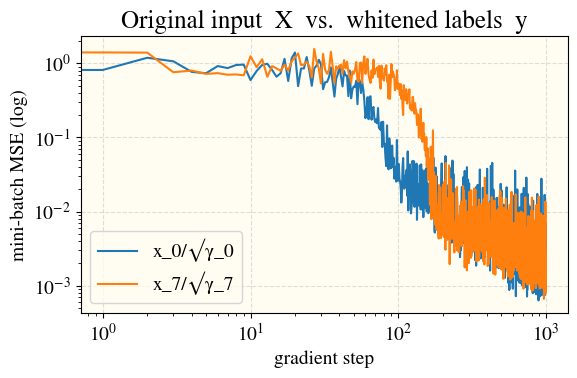

In [ ]:
import torch, torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
torch.manual_seed(0)

# ---------------- data -----------------
gamma         = torch.exp(-0.2*torch.arange(d)); gamma /= gamma.sum()
X             = torch.randn(N, d) * gamma.sqrt()        # anisotropic input
batch_size    = 32

def loader(j):
    y = X[:, j:j+1] / gamma[j].sqrt()                   # whitened label
    return DataLoader(TensorDataset(X, y), batch_size=batch_size,
                      shuffle=True, drop_last=True)

def train(j, color):
    net = StandardMLP(d_in=d, depth=2, d_out=1, width=width).to(device)
    opt    = torch.optim.SGD(net.parameters(), lr=3e-2)
    mupify(net, opt, param="mup")
    losses, it = [], iter(loader(j))
    for step in range(1000):
        try: xb, yb = next(it)
        except StopIteration:
            it = iter(loader(j)); xb, yb = next(it)
        xb, yb = ensure_torch(xb), ensure_torch(yb)
        opt.zero_grad()
        loss = ((net(xb) - yb)**2).mean()
        loss.backward(); opt.step()
        losses.append(loss.item())
    plt.plot(losses, label=f"x_{j}/√γ_{j}", color=color)

plt.figure(figsize=(6,4))
train(0 , "tab:blue")
train(7, "tab:orange")
plt.yscale('log'); plt.grid(True, ls='--', alpha=.4)
plt.xlabel("gradient step"); plt.ylabel("mini-batch MSE (log)")
plt.title("Original input  X  vs.  whitened labels  y")
plt.xscale('log')
plt.legend(); plt.tight_layout(); plt.show()


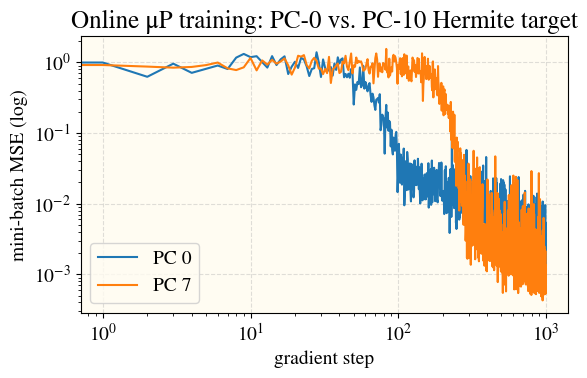

In [ ]:
device      = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size  = 32
steps       = 1000

def train_one_pc(pc_index, color):
    monomial = Monomial({pc_index: 1})                 # first-order Hermite
    net = StandardMLP(d_in=d, depth=2, d_out=1, width=width).to(device)
    opt    = torch.optim.SGD(net.parameters(), lr=3e-2)
    mupify(net, opt, param="mup")

    losses = []
    for _ in range(steps):
        # ── generate a fresh mini-batch ──────────────────
        with torch.no_grad():                # no autograd for data gen
            X_new, H_new = get_new_data(lambdas, Vt, monomial,
                                        dim, batch_size, None, None,
                                        data_eigvals, N)
        X_new, H_new = X_new.to(device), H_new.to(device)

        # ── SGD step ─────────────────────────────────────
        opt.zero_grad()
        loss = ((net(X_new) - H_new)**2).mean()
        loss.backward()
        opt.step()
        losses.append(loss.item())

    plt.plot(losses, label=f'PC {pc_index}', color=color)

# -----------------------------------------------------------
# 5.  Run the experiment
# -----------------------------------------------------------
plt.figure(figsize=(6,4))
train_one_pc(0 , "tab:blue")
train_one_pc(7, "tab:orange")
plt.yscale('log'); plt.grid(True, ls='--', alpha=.4)
plt.xscale('log')
plt.xlabel("gradient step"); plt.ylabel("mini-batch MSE (log)")
plt.title("Online μP training: PC-0 vs. PC-10 Hermite target")
plt.legend(); plt.tight_layout(); plt.show()

### old code on linear monomials that wasn't working out

In [ ]:
dim = 8
N = 10_000
offset=3
alpha=2.01
train_percent = 0.9
bsz = 32
target_monomials = [Monomial({0:1}), Monomial({2:1}), Monomial({4:1}), Monomial({6:1}), Monomial({7: 1})]
lr = 1e-2
width = 64

def get_all_targets(target_monomials, dim=500, N=10_000, offset=3, alpha=2.01, cutoff_mode=1000, noise_size=1, normalized=True, **kwargs):
    y_all = torch.zeros((N, len(target_monomials)))
    locs = torch.zeros(len(target_monomials))

    X, data_eigvals = get_synthetic_X(d=dim, N=N, offset=offset, alpha=alpha)
    X, _, H, monomials, fra_eigvals, _ = get_synthetic_dataset(X, data_eigvals, ytype="OneHot", cutoff_mode=cutoff_mode,
                            noise_size=noise_size, normalized=True, OneHotIndex = 1, **kwargs)

    for i, monomial in enumerate(target_monomials):
        loc = np.where(np.array(monomials) == monomial)[0][0]
        locs[i] = loc
        y_all[:, i] = H[:, loc] if not normalized else H[:, loc]*N**(0.5)

    return X, y_all, locs, H, monomials, fra_eigvals, data_eigvals

X, y, locs, H, monomials, fra_eigvals, data_eigvals = get_all_targets(target_monomials=target_monomials, dim=dim, N=N)
U, lambdas, Vt = torch.linalg.svd(X, full_matrices=False)

X_train, y_train = X[:int(train_percent*N)], y[:int(train_percent*N), :]
X_test, y_test = X[int(train_percent*N):], y[int(train_percent*N):, :]

X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_train, y_train, X_test, y_test = [torch.Tensor(d).cuda() for d in (X_train, y_train, X_test, y_test)]

# train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=bsz, shuffle=True)
# test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=bsz, shuffle=False)

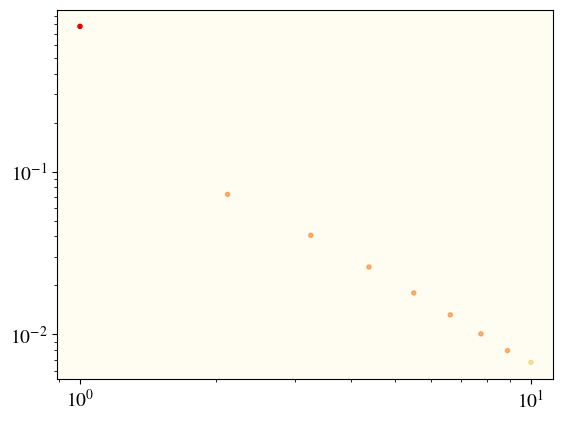

In [ ]:
colors = ['xkcd:red', 'xkcd:orange', 'xkcd:gold', 'xkcd:green', 'xkcd:blue', "xkcd:purple", "xkcd:black"]
degrees = np.array([monomial.degree() for monomial in monomials[:int(locs[-1])]])
indices = np.linspace(1, int(locs[-1])+1, int(locs[-1]))
for degree in np.unique(degrees):
    idxs = np.where(np.array(degrees) == degree)[0]
    plt.scatter(indices[idxs], fra_eigvals[idxs].cpu(), color=colors[degree%7], linestyle='', marker='.', alpha=1/(degree+1),)
plt.yscale("log")
plt.xscale('log')

In [ ]:
ntrials = 10
max_iter = int(1e4)
max_loss = 1e-3
all_losses = np.ones((len(target_monomials), ntrials, max_iter))*max_loss
breakpoints = np.empty((len(target_monomials), ntrials))
for idx, target_monomial in enumerate(target_monomials):
    print(f"Target = {target_monomial}")
    model = StandardMLP(d_in=dim, depth=2, d_out=1, width=width).to(device)
    for trial in range(ntrials):
        print(f"Trial {trial}")
        tm = list(target_monomial.keys())[0]
        model, losses, breakpoint = train_network_online_minibatch_test(X, y[:, tm:tm+1], model, lambdas, Vt, target_monomial, offset, alpha, data_eigvals, lr=lr, bsz=bsz, max_loss=5e-4,
                                                                   max_iter=max_iter, N_original = N)
        all_losses[idx, trial] = losses
        breakpoints[idx, trial] = breakpoint
        print(f"Breakpoint {breakpoint}")
# all_losses = all_losses[all_losses > 10] = max_loss

Target = $x_{0}$
Trial 0
Breakpoint 10000
Trial 1


KeyboardInterrupt: 

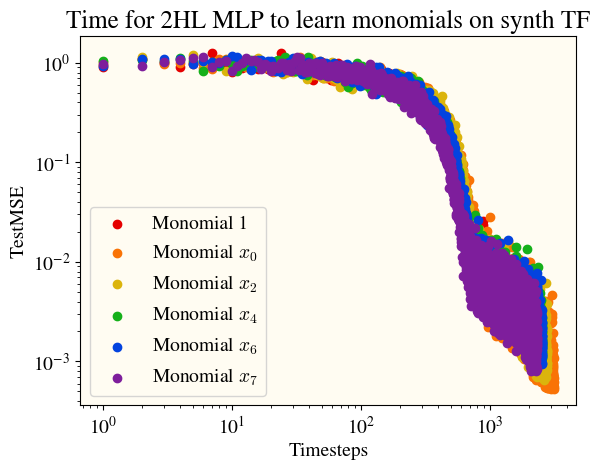

In [ ]:
mean_breakpoint = breakpoints.mean(axis=1)
for idx, target_monomial in enumerate(target_monomials):
    degree = target_monomial.degree()
    plt.scatter(np.linspace(1, int(mean_breakpoint[idx])+2, int(mean_breakpoint[idx])+1), all_losses[:, idx, :int(mean_breakpoint[idx])+1].mean(axis=0),
                color=colors[idx%7], label=f"Monomial {target_monomial}")
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Timesteps")
plt.ylabel("TestMSE")
plt.title("Time for 2HL MLP to learn monomials on synth TF")
plt.legend()

## testing timekey training

In [ ]:
def train_network_online_percents(lambdas, Vt, monomial, dim, bsz, data_eigvals, N, lr, max_iter=int(1e3), loss_checkpoints=(5e-1,), gamma=1.,
                                  percent_thresholds=(0.9, 0.75, 0.5, 0.25, 0.1), **kwargs):
    """
    Trains online and returns once all absolute loss thresholds are crossed.
    Also records when loss drops below specified percentages of the initial loss.

    Returns:
        model, losses, timekeys, pct_timekeys, init_loss

        - losses: per-iteration loss (EMA if ema_smoothing=True)
        - timekeys[i]: first iteration where raw loss < loss_checkpoints[i] (or max_iter if never)
        - pct_timekeys[j]: first iteration where metric < percent_thresholds[j] * init_loss
                           (metric = EMA if pct_use_ema and ema_smoothing=True, else raw loss)
        - init_loss: the loss at iteration 0 before any update (raw)
    """
    ##model inits
    model = MLP(d_in=dim, depth=2, d_out=1, width=width).to(device)
    lr = lr*gamma if gamma >= 1 else lr*(gamma**2.)
    opt = torch.optim.SGD(model.parameters(), lr=lr)
    mupify(model, opt, param="mup")
    rescale(model, gamma)
    loss_fn = torch.nn.MSELoss()

    ##knowing when to stop
    loss_checkpoints = np.asarray(loss_checkpoints, dtype=float)
    loss_checkpoints = np.sort(loss_checkpoints)[::-1]
    timekeys = np.full(loss_checkpoints.shape, fill_value=max_iter, dtype=int)

    percent_thresholds = np.asarray(percent_thresholds, dtype=float)
    percent_thresholds = np.sort(percent_thresholds)[::-1]
    pct_timekeys = np.full(percent_thresholds.shape, fill_value=max_iter, dtype=int)

    max_loss = float(min(loss_checkpoints)) if len(loss_checkpoints) else 0.0
    losses = np.ones(max_iter, dtype=float) * max_loss

    pointer_abs = 0
    pointer_pct = 0

    ema = None
    ema_on = bool(kwargs.get("ema_smoothing", False))
    ema_alpha = float(kwargs.get("ema_smoother", 0.98))

    for i in range(max_iter):
        with torch.no_grad():
            X_new, y_new = get_new_data(lambdas, Vt, monomial, dim, bsz, data_eigvals, N)
        X_new, y_new = map(ensure_torch, (X_new, y_new))

        opt.zero_grad()
        out = model(X_new)
        loss = loss_fn(out, y_new)
        loss.backward()
        opt.step()

        loss_val = float(loss.item())

        if i == 0:
            init_loss = loss_val
            abs_thresholds = init_loss * percent_thresholds

        ema = loss_val if i == 0 else (ema_alpha * ema + (1.0 - ema_alpha) * loss_val)
        losses[i] = ema if ema_on else loss_val

        while pointer_abs < len(loss_checkpoints) and loss_val < loss_checkpoints[pointer_abs]:
            timekeys[pointer_abs] = i
            losses[i:] = ema if ema_on else loss_val
            pointer_abs += 1
            # if pointer_abs == len(timekeys):
            #     return model, losses, timekeys, pct_timekeys, init_loss

        metric = losses[i] if (kwargs.get("pct_use_ema", False) and ema_on) else loss_val
        while pointer_pct < len(abs_thresholds) and metric < abs_thresholds[pointer_pct]:
            pct_timekeys[pointer_pct] = i
            losses[i:] = ema if ema_on else loss_val
            pointer_pct += 1
            if pointer_pct == len(timekeys):
                return model, losses, timekeys, pct_timekeys

    return model, losses, timekeys, pct_timekeys


def train_network_online(lambdas, Vt, monomial, dim, bsz, data_eigvals, N, lr, max_iter=int(1e3),
                         loss_checkpoints = [5e-1,], gamma=1., **kwargs):
    """
    Switched max loss -> loss_checkpoints, will stop once max(loss_checkpoints is reached)
    """
    model = MLP(d_in=dim, depth=2, d_out=1, width=width).to(device)
    lr = lr*gamma if gamma >= 1 else lr*(gamma**2.)
    opt    = torch.optim.SGD(model.parameters(), lr=lr)
    mupify(model, opt, param="mup")
    rescale(model, gamma)
    loss_fn = torch.nn.MSELoss()

    max_loss = min(loss_checkpoints)
    losses = np.ones(max_iter)*max_loss
    loss_checkpoints = np.sort(np.asarray(loss_checkpoints))[::-1]
    timekeys = np.ones_like(loss_checkpoints)*max_iter
    pointer = 0

    for i in range(max_iter):
        with torch.no_grad():
            X_new, y_new = get_new_data(lambdas, Vt, monomial,
                                        dim, bsz,
                                        data_eigvals, N)
        X_new, y_new = X_new.to(device), y_new.to(device)

        opt.zero_grad()
        loss = loss_fn(model(X_new), y_new)
        loss.backward()
        opt.step()

        loss_val = loss.item()
        if kwargs.get("ema_smoothing", False):
            ema = loss_val if i == 0 else kwargs.get("ema_smoother", 0.98) * ema + (1 - kwargs.get("ema_smoother", 0.98)) * loss_val
            losses[i] = ema
        else:
            losses[i] = loss_val

        if loss_val < loss_checkpoints[pointer]:
            timekeys[pointer] = i
            pointer += 1
            if pointer == len(timekeys):
                return model, losses, timekeys
    return model, losses, timekeys

In [ ]:
def train_network_online(lambdas, Vt, monomial, dim, bsz, data_eigvals, N, lr, max_iter=int(1e3),
                         loss_checkpoints = [5e-1,], **kwargs):
    """
    Switched max loss -> loss_checkpoints, will stop once max(loss_checkpoints is reached)
    """
    model = MLP(d_in=dim, depth=2, d_out=1, width=width).to(device)
    opt    = torch.optim.SGD(model.parameters(), lr=lr)
    mupify(model, opt, param="mup")
    loss_fn = torch.nn.MSELoss()

    max_loss = min(loss_checkpoints)
    losses = np.ones(max_iter)*max_loss
    loss_checkpoints = np.sort(np.asarray(loss_checkpoints))[::-1]
    timekeys = np.ones_like(loss_checkpoints)*max_iter
    pointer = 0

    for i in range(max_iter):
        with torch.no_grad():
            X_new, y_new = get_new_data(lambdas, Vt, monomial,
                                        dim, bsz,
                                        data_eigvals, N)
        X_new, y_new = X_new.to(device), y_new.to(device)

        opt.zero_grad()
        loss = loss_fn(model(X_new), y_new)
        loss.backward()
        opt.step()

        loss_val = loss.item()
        if kwargs.get("ema_smoothing", False):
            ema = loss_val if i == 0 else kwargs.get("ema_smoother", 0.98) * ema + (1 - kwargs.get("ema_smoother", 0.98)) * loss_val
            losses[i] = ema
        else:
            losses[i] = loss_val

        if loss_val < loss_checkpoints[pointer]:
            timekeys[pointer] = i
            pointer += 1
            if pointer == len(timekeys):
                return model, losses, timekeys
    return model, losses, timekeys

def plot_time_to_learn_eigenvalue(eigvals, timekeys, target_monomials, scale='log', **kwargs):
    degrees = np.array([target_monomial.degree() for target_monomial in target_monomials])
    for degree in np.unique(degrees):
        idxs = np.where(np.array(degrees) == degree)[0]
        plt.scatter((eigvals[idxs])**(-1), timekeys[idxs])
        plt.xscale(scale)
        plt.yscale(scale)
        plt.xlabel(f"FRA Eigval $\lambda^{{-1}}$")
        plt.ylabel(f"Time to learn "+kwargs.get("breakpoint", ""))

In [ ]:
dim = 10
N = 10_000
offset=3
alpha=2.01
train_percent = 0.9
bsz = 512
target_monomials = [Monomial({}), Monomial({0:1}), Monomial({0:2}), Monomial({9: 1}), Monomial({0: 2, 1:1}), Monomial({1:3})]
lr = 1e-2
width = 64

num_trials = 5
max_iter = int(5e4)
loss_checkpoints = [5e-1, 2e-1]

X, y, locs, H, monomials, fra_eigvals, data_eigvals = get_all_targets(target_monomials=target_monomials, dim=dim, N=N)
U, lambdas, Vt = torch.linalg.svd(X, full_matrices=False)

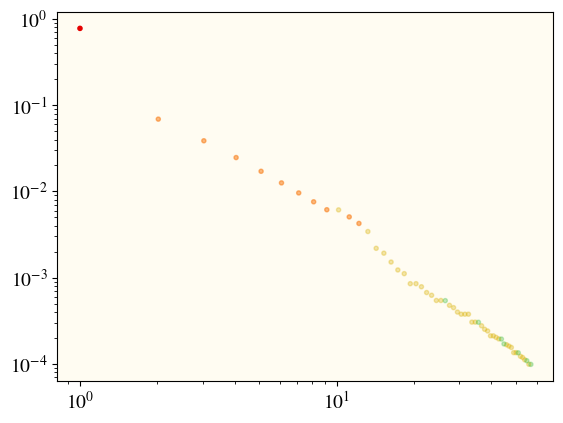

In [ ]:
colors = ['xkcd:red', 'xkcd:orange', 'xkcd:gold', 'xkcd:green', 'xkcd:blue', "xkcd:purple", "xkcd:black"]
degrees = np.array([monomial.degree() for monomial in monomials[:int(locs[-1])]])
indices = np.linspace(1, int(locs[-1])+1, int(locs[-1]))
for degree in np.unique(degrees):
    idxs = np.where(np.array(degrees) == degree)[0]
    plt.scatter(indices[idxs], fra_eigvals[idxs].cpu(), color=colors[degree%7], linestyle='', marker='.', alpha=1/(degree+1),)
plt.yscale("log")
plt.xscale('log')

In [ ]:
all_losses = np.ones((len(target_monomials), num_trials, max_iter))*max(loss_checkpoints)
breakpoints = np.empty((len(target_monomials), len(loss_checkpoints), num_trials))
for idx, target_monomial in enumerate(target_monomials):
    print(f"Target = {target_monomial}")
    model = MLP(d_in=dim, depth=2, d_out=1, width=width).to(device)
    for trial in range(num_trials):
        model, losses, breakpoint = train_network_online(lambdas, Vt, target_monomial, dim, bsz=bsz, data_eigvals=data_eigvals, N=N, lr=lr, max_iter=max_iter, loss_checkpoints=loss_checkpoints,)
        all_losses[idx, trial] = losses
        breakpoints[idx, :, trial] = breakpoint
        print(f"Trial {trial} Breakpoint {breakpoint}")

Target = 1
Trial 0 Breakpoint [45. 76.]
Trial 1 Breakpoint [ 73. 105.]
Trial 2 Breakpoint [60. 91.]
Trial 3 Breakpoint [33. 60.]
Trial 4 Breakpoint [48. 74.]
Target = $x_{0}$
Trial 0 Breakpoint [155. 224.]
Trial 1 Breakpoint [103. 178.]
Trial 2 Breakpoint [139. 223.]
Trial 3 Breakpoint [133. 213.]
Trial 4 Breakpoint [105. 189.]
Target = $x_{0}^2$
Trial 0 Breakpoint [414. 655.]
Trial 1 Breakpoint [499. 712.]
Trial 2 Breakpoint [389. 630.]
Trial 3 Breakpoint [332. 533.]
Trial 4 Breakpoint [528. 668.]
Target = $x_{9}$
Trial 0 Breakpoint [666. 803.]
Trial 1 Breakpoint [822. 955.]
Trial 2 Breakpoint [643. 782.]
Trial 3 Breakpoint [778. 918.]
Trial 4 Breakpoint [875. 998.]
Target = $x_{0}^2x_{1}$
Trial 0 Breakpoint [  10. 2883.]
Trial 1 Breakpoint [ 119. 2906.]
Trial 2 Breakpoint [  97. 2922.]
Trial 3 Breakpoint [ 234. 2893.]
Trial 4 Breakpoint [ 147. 2313.]
Target = $x_{1}^3$
Trial 0 Breakpoint [   6. 2245.]
Trial 1 Breakpoint [2.000e+00 2.532e+03]
Trial 2 Breakpoint [  86. 3014.]
Trial 3 B

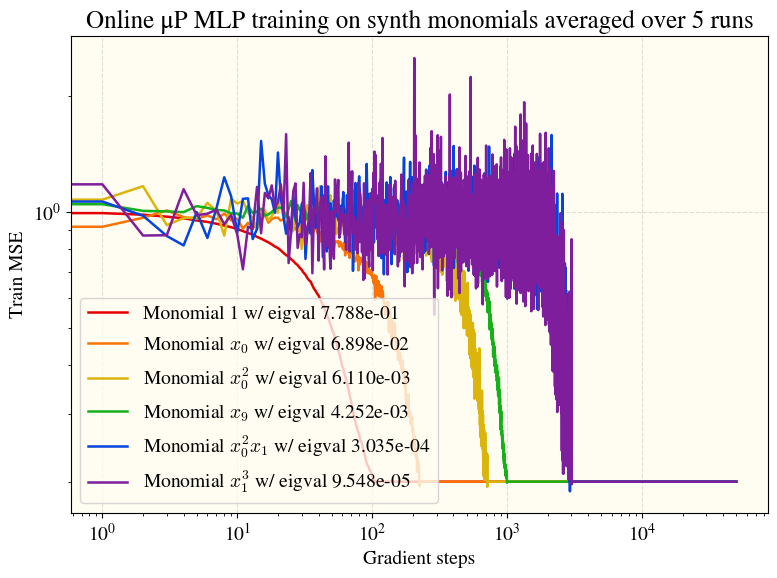

In [ ]:
plt.figure(figsize=(8,6))
for idx, target_monomial in enumerate(target_monomials):
    plt.plot(all_losses[idx].mean(axis=0), label=f"Monomial {target_monomial} w/ eigval {fra_eigvals[int(locs[idx].cpu().numpy())]:.3e}", color=colors[idx%7], lw=1.8)
plt.xscale('log')
plt.yscale('log')
plt.grid(True, ls='--', alpha=.4)
plt.xlabel("Gradient steps")
plt.ylabel("Train MSE")
plt.title(f"Online μP MLP training on synth monomials averaged over {num_trials} runs")
plt.legend(); plt.tight_layout(); plt.show()

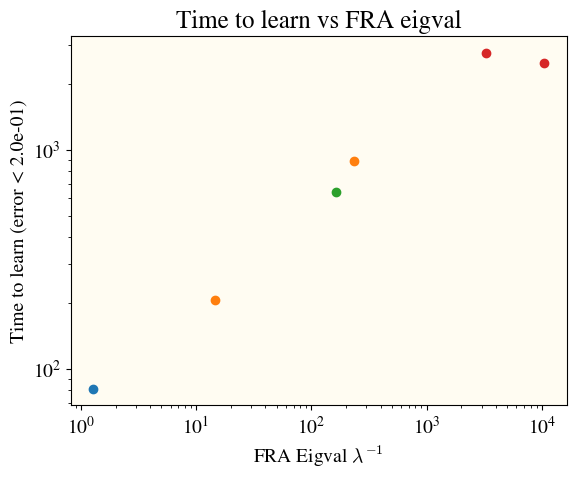

In [ ]:
breakindex = -1
plot_time_to_learn_eigenvalue(fra_eigvals[locs.long()].cpu(), breakpoints.mean(axis=-1)[:, breakindex], target_monomials, scale='log', breakpoint=f"(error < {loss_checkpoints[breakindex]:.1e})")
plt.title("Time to learn vs FRA eigval")
plt.show()

## testing new percentage based stopping
this showed an issue when gamma was small

In [ ]:
dim = 10
N = 10_000
offset=3
alpha=2.01
bsz = 512

X, y, locs, H, monomials, fra_eigvals, data_eigvals = get_all_targets(target_monomials=Monomial({}), dim=dim, N=N)
target_monomials = [Monomial({}), Monomial({0:1}), Monomial({0:2}), Monomial({9: 1}), Monomial({0: 2, 1:1}), Monomial({1:3})]#monomials[:100]#
lr = 1e-2
width = 64
gamma = 0.001

num_trials = 10
max_iter = int(5e4)
loss_checkpoints = (5e-1, 2e-1)
percent_thresholds = (0.75, 0.5, .2)

X, y, locs, H, monomials, fra_eigvals, data_eigvals = get_all_targets(target_monomials=target_monomials, dim=dim, N=N)
U, lambdas, Vt = torch.linalg.svd(X, full_matrices=False)

Generating monomials: 100%|██████████| 1000/1000 [00:00<00:00, 7353.10step/s]


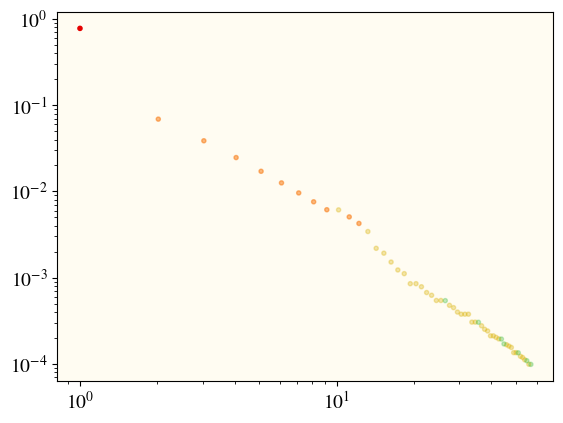

In [ ]:
colors = ['xkcd:red', 'xkcd:orange', 'xkcd:gold', 'xkcd:green', 'xkcd:blue', "xkcd:purple", "xkcd:black"]
degrees = np.array([monomial.degree() for monomial in monomials[:int(locs[-1])]])
indices = np.linspace(1, int(locs[-1])+1, int(locs[-1]))
for degree in np.unique(degrees):
    idxs = np.where(np.array(degrees) == degree)[0]
    plt.scatter(indices[idxs], fra_eigvals[idxs].cpu(), color=colors[degree%7], linestyle='', marker='.', alpha=1/(degree+1),)
plt.yscale("log")
plt.xscale('log')

In [ ]:
all_losses = np.ones((len(target_monomials), num_trials, max_iter))*max(loss_checkpoints)
breakpoints = np.empty((len(target_monomials), len(loss_checkpoints), num_trials))
pct_breakpoints = np.empty((len(target_monomials), len(loss_checkpoints), num_trials))
pbar = tqdm(enumerate(target_monomials), total=len(target_monomials), desc="Processing items")


# for idx, target_monomial in tenumerate(target_monomials, desc="Target fitting", unit="step", total=len(monomials), ):
for idx, target_monomial in pbar:
    # print(f"Target = {target_monomial}")
    model = MLP(d_in=dim, depth=2, d_out=1, width=width).to(device)
    for trial in range(num_trials):
        model, losses, breakpoint, pct_breakpoint = train_network_online_percents(lambdas, Vt, target_monomial, dim, bsz=bsz, data_eigvals=data_eigvals, N=N, lr=lr, max_iter=max_iter,
                                                         loss_checkpoints=loss_checkpoints, gamma=gamma, percent_thresholds=(0.75, 0.5), pct_use_ema=False)
        all_losses[idx, trial] = losses
        breakpoints[idx, :, trial] = breakpoint
        pct_breakpoints[idx, :, trial] = pct_breakpoint
    pbar.set_postfix(current_item=target_monomial, iteration=idx + 1)
        # print(f"Trial {trial} Breakpoint {breakpoint}")

Processing items: 100%|██████████| 6/6 [00:31<00:00,  5.31s/it, current_item=$x_{1}^3$, iteration=6]


<>:13: SyntaxWarning: invalid escape sequence '\l'
<>:21: SyntaxWarning: invalid escape sequence '\g'
<>:13: SyntaxWarning: invalid escape sequence '\l'
<>:21: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipython-input-3703044497.py:13: SyntaxWarning: invalid escape sequence '\l'
  ax.plot(all_losses[idx].mean(axis=0), label=f"{target_monomial}, $\lambda_{{FRA}}={fra_eigvals[int(locs[idx].cpu().numpy())]:.2e}$", color=colors[idx%7], lw=1.8)
/tmp/ipython-input-3703044497.py:21: SyntaxWarning: invalid escape sequence '\g'
  fig.suptitle(f"Online μP MLP training on synth monomials averaged over {num_trials} runs, $\gamma$={gamma}")


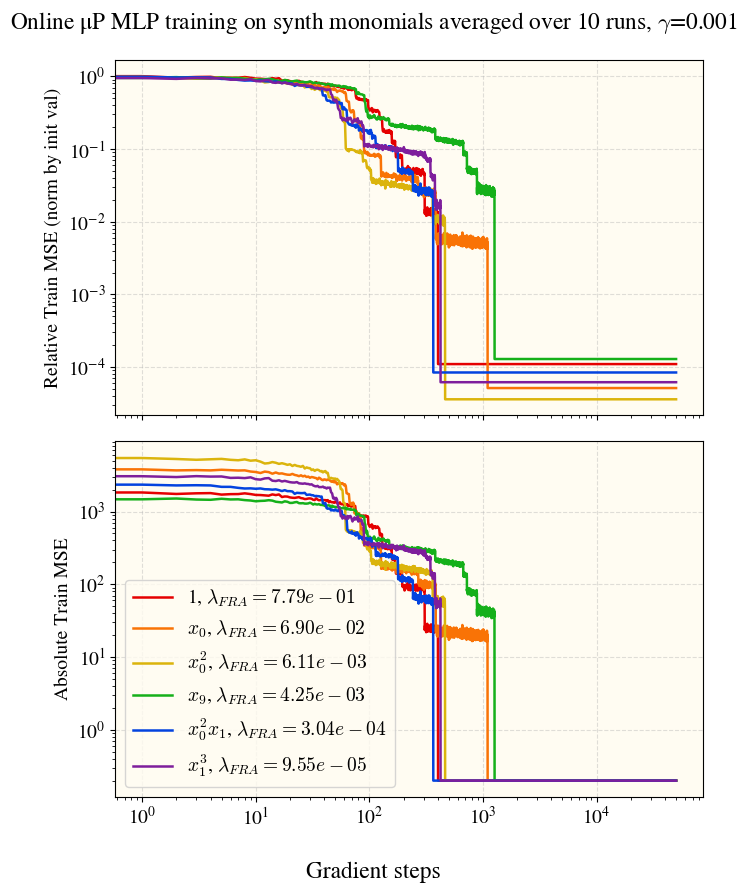

In [ ]:
# target_monomials = [Monomial({})]#, Monomial({0:1}), Monomial({0:2}), Monomial({9: 1}), Monomial({0: 2, 1:1}), Monomial({1:3})]#monomials[:100]#
fig, axes = plt.subplots(2, 1, figsize=(7,9), sharex=True)
ax = axes[0]
for idx, target_monomial in enumerate(target_monomials):
    ax.plot(all_losses[idx].mean(axis=0)/all_losses[idx].mean(axis=0)[0], label=f"Monomial {target_monomial} w/ eigval {fra_eigvals[int(locs[idx].cpu().numpy())]:.3e}", color=colors[idx%7], lw=1.8)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel("Relative Train MSE (norm by init val)")
ax.grid(True, ls='--', alpha=.4)
# ax.legend()
ax = axes[1]
for idx, target_monomial in enumerate(target_monomials):
    ax.plot(all_losses[idx].mean(axis=0), label=f"{target_monomial}, $\lambda_{{FRA}}={fra_eigvals[int(locs[idx].cpu().numpy())]:.2e}$", color=colors[idx%7], lw=1.8)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel("Absolute Train MSE")
ax.grid(True, ls='--', alpha=.4)
ax.legend()

fig.supxlabel("Gradient steps")
fig.suptitle(f"Online μP MLP training on synth monomials averaged over {num_trials} runs, $\gamma$={gamma}")
# plt.legend()
plt.tight_layout(); plt.show()

In [ ]:
breakindex = -1
xaxis = (fra_eigvals[locs.long()].cpu())**(-1.)
log_x = torch.log10(ensure_torch(xaxis))
log_x_centered_w_intercept = torch.column_stack((log_x, torch.ones_like(log_x)))

sol = torch.linalg.lstsq(log_x_centered_w_intercept, ensure_torch(torch.log10(ensure_torch(pct_breakpoints).mean(axis=-1)[:, breakindex])).unsqueeze(1)).solution.squeeze()
slope          = float(sol[0])
intercept     = float(sol[1])

<>:7: SyntaxWarning: invalid escape sequence '\g'
<>:7: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipython-input-1677226743.py:7: SyntaxWarning: invalid escape sequence '\g'
  plt.title(f"Time to learn vs FRA eigval, MLP $\gamma ={gamma}$")
/tmp/ipython-input-2131616977.py:164: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar((eigvals[idxs])**(-1), timekeys[idxs], yerr=kwargs.get("yerr")[idxs], marker=kwargs.get("marker", None), color=colors[degree%7], alpha=kwargs.get("alpha", 1),


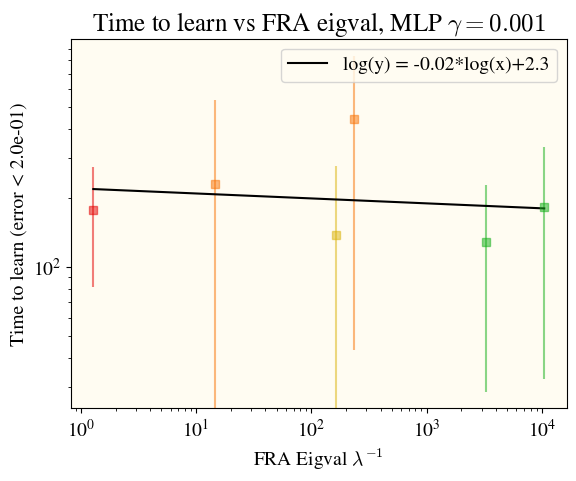

In [ ]:
plot_time_to_learn_eigenvalue(fra_eigvals[locs.long()].cpu(), pct_breakpoints.mean(axis=-1)[:, breakindex], target_monomials, scale='log', breakpoint=f"(error < {loss_checkpoints[breakindex]:.1e})",
                              marker='s', alpha=0.5, errorbar=True, yerr=pct_breakpoints.var(axis=-1)[:, breakindex]**(0.5))
plt.plot(xaxis, 10**(intercept)*xaxis**(slope), color='k', label=f"log(y) = {slope:.2f}*log(x)+{intercept:.1f}")
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.title(f"Time to learn vs FRA eigval, MLP $\gamma ={gamma}$")
plt.show()